In [ ]:
!pip install optuna

     |████████████████████████████████| 296kB 7.2MB/s 
     |████████████████████████████████| 81kB 7.5MB/s 
     |████████████████████████████████| 163kB 7.9MB/s 
     |████████████████████████████████| 112kB 14.3MB/s 
     |████████████████████████████████| 143kB 14.6MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=2ce4bc649edcdaae722a22dd62017d95cc6f796eeb3708909383d1621385bf18
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [ ]:
from glob import glob
from keras import optimizers
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, models
import cv2
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os

In [ ]:
path = glob("kurita/*/")
data = []
label = []
total = 0
x = 32
y = 18

def append_data(directory, total):
  files = os.listdir(directory)
  print(files)
  for image in files:
    if image.endswith(".jpg"):
      image = cv2.imread(directory + image)
      image = cv2.resize(image, (x, y))
      image_gs = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image_gs = image_gs.flatten()
      data.append(image_gs)
      label.append(total)

for i in path:
    append_data(i, total)
    total += 1

['kurita_145.jpg', 'kurita_146.jpg', 'kurita_147.jpg', 'kurita_148.jpg', 'kurita_149.jpg', 'kurita_150.jpg', 'kurita_151.jpg', 'kurita_152.jpg', 'kurita_153.jpg', 'kurita_154.jpg', 'kurita_155.jpg', 'kurita_157.jpg', 'kurita_158.jpg', 'kurita_160.jpg', 'kurita_162.jpg', 'kurita_163.jpg', 'kurita_164.jpg', 'kurita_165.jpg', 'kurita_166.jpg', 'kurita_167.jpg', 'kurita_168.jpg', 'kurita_169.jpg', 'kurita_170.jpg', 'kurita_171.jpg', 'kurita_172.jpg', 'kurita_173.jpg', 'kurita_174.jpg', 'kurita_127.jpg', 'kurita_126.jpg', 'kurita_124.jpg', 'kurita_125.jpg', 'kurita_132.jpg', 'kurita_133.jpg', 'kurita_129.jpg', 'kurita_134.jpg', 'kurita_128.jpg', 'kurita_131.jpg', 'kurita_130.jpg', 'kurita_137.jpg', 'kurita_141.jpg', 'kurita_143.jpg', 'kurita_135.jpg', 'kurita_144.jpg', 'kurita_136.jpg', 'kurita_138.jpg', 'kurita_142.jpg', 'kurita_159.jpg', 'kurita_140.jpg', 'kurita_176.jpg', 'kurita_200.jpg', 'kurita_004.jpg', 'kurita_062.jpg', 'kurita_067.jpg', 'kurita_097.jpg', 'kurita_118.jpg', 'kurita_1

In [ ]:
data = np.array(data, dtype=np.float64)
label = np.array(label, dtype=np.float64)

train_data, test_data, train_label, test_label = train_test_split(data, label, random_state=1, stratify=label, test_size=0.1)

train_data = train_data.reshape((len(train_data)), x, y, 1)
test_data = test_data.reshape((len(test_data)), x, y, 1)

train_data /= 255
test_data /= 255

train_label = to_categorical(train_label, num_classes=2)
test_label = to_categorical(test_label, num_classes=2)
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(1152, 32, 18, 1)
(1152, 2)
(129, 32, 18, 1)
(129, 2)


In [ ]:
model_list = []
result_list = []

def create_model(layer, filter_size, filters, activation, dropout_rate):
  model = model = models.Sequential()
  model.add(layers.Conv2D(16, (filter_size, filter_size), activation="relu", padding="same", input_shape=(x, y, 1)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2), strides=(1, 1)))
  model.add(layers.Flatten())
  for i in range(layer):
    model.add(layers.Dense(filters, activation=activation))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=dropout_rate))
  model.add(layers.Dense(2, activation="softmax"))
  return model

def optimisation(choice):
  K.clear_session()
  layer = choice.suggest_int("layer", 1, 8)
  filter_size = choice.suggest_int("filter_size", 3, 7, 2)
  filters = choice.suggest_int("filters", 32, 256, 32)
  optimizer = choice.suggest_categorical("optimizer", ["SGD", "RMSprop", "Adagrad", "Adadelta", "Adam", "Adamax", "Nadam"])
  activation = choice.suggest_categorical("activation", ["softmax", "elu", "selu", "softplus", "softsign", "relu", "tanh", "sigmoid", "hard_sigmoid", "linear"])
  dropout_rate = choice.suggest_uniform("dropout_rate", 0.25, 0.5)
  model = create_model(layer, filter_size, filters, activation, dropout_rate)
  model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  result = model.fit(train_data, train_label, batch_size=batchsize, epochs=epoch, verbose=2, validation_data=(test_data, test_label))
  model_list.append(model)
  result_list.append(result)
  return 1 - result.history["val_accuracy"][-1]

In [ ]:
batchsize = train_data.shape[0] // 64
print(batchsize)
epoch = 16
study = optuna.create_study()
study.optimize(optimisation, n_trials=256)

[I 2021-03-17 07:35:45,303] A new study created in memory with name: no-name-aa704664-174d-4a35-8489-2aedb992c398


18
Epoch 1/16
64/64 - 34s - loss: 1.2361 - accuracy: 0.5122 - val_loss: 0.5913 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 1.0762 - accuracy: 0.5434 - val_loss: 0.5733 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 1.0161 - accuracy: 0.5781 - val_loss: 0.5381 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 1.0186 - accuracy: 0.5547 - val_loss: 0.4847 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.9542 - accuracy: 0.5825 - val_loss: 0.4508 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.8619 - accuracy: 0.6181 - val_loss: 0.4253 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.8626 - accuracy: 0.6215 - val_loss: 0.4125 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.8459 - accuracy: 0.6155 - val_loss: 0.3864 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.8196 - accuracy: 0.6059 - val_loss: 0.3743 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.7756 - accuracy: 0.6380 - val_loss: 0.3650 - val_accuracy: 0.8527
Epoch 11/16
64/

[I 2021-03-17 07:36:29,716] Trial 0 finished with value: 0.13953489065170288 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adagrad', 'activation': 'softplus', 'dropout_rate': 0.44462800708882244}. Best is trial 0 with value: 0.13953489065170288.


Epoch 1/16
64/64 - 2s - loss: 1.3219 - accuracy: 0.4783 - val_loss: 0.5777 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 1.2493 - accuracy: 0.4913 - val_loss: 0.6857 - val_accuracy: 0.7054
Epoch 3/16
64/64 - 0s - loss: 1.1739 - accuracy: 0.5052 - val_loss: 0.7471 - val_accuracy: 0.1550
Epoch 4/16
64/64 - 0s - loss: 1.2203 - accuracy: 0.4965 - val_loss: 0.7718 - val_accuracy: 0.1628
Epoch 5/16
64/64 - 0s - loss: 1.2821 - accuracy: 0.4878 - val_loss: 0.7687 - val_accuracy: 0.2171
Epoch 6/16
64/64 - 0s - loss: 1.2327 - accuracy: 0.5095 - val_loss: 0.7897 - val_accuracy: 0.2481
Epoch 7/16
64/64 - 0s - loss: 1.2055 - accuracy: 0.5069 - val_loss: 0.7853 - val_accuracy: 0.2403
Epoch 8/16
64/64 - 0s - loss: 1.2486 - accuracy: 0.4826 - val_loss: 0.7896 - val_accuracy: 0.2558
Epoch 9/16
64/64 - 0s - loss: 1.2253 - accuracy: 0.4948 - val_loss: 0.7960 - val_accuracy: 0.2946
Epoch 10/16
64/64 - 0s - loss: 1.2180 - accuracy: 0.5052 - val_loss: 0.7852 - val_accuracy: 0.3333
Epoch 11/16
64/64 -

[I 2021-03-17 07:36:35,742] Trial 1 finished with value: 0.6201550364494324 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adadelta', 'activation': 'softplus', 'dropout_rate': 0.4832416508484927}. Best is trial 0 with value: 0.13953489065170288.


Epoch 1/16
64/64 - 1s - loss: 0.8920 - accuracy: 0.6649 - val_loss: 0.7290 - val_accuracy: 0.3643
Epoch 2/16
64/64 - 0s - loss: 0.5073 - accuracy: 0.8030 - val_loss: 0.3759 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.3620 - accuracy: 0.8681 - val_loss: 0.3282 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3012 - accuracy: 0.8898 - val_loss: 0.3224 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2443 - accuracy: 0.9054 - val_loss: 0.3239 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2131 - accuracy: 0.9358 - val_loss: 0.2888 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1797 - accuracy: 0.9375 - val_loss: 0.2679 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1380 - accuracy: 0.9644 - val_loss: 0.1993 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1121 - accuracy: 0.9696 - val_loss: 0.1984 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1030 - accuracy: 0.9722 - val_loss: 0.2320 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:36:39,423] Trial 2 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.37627329272324683}. Best is trial 2 with value: 0.062015533447265625.


Epoch 1/16
64/64 - 1s - loss: 0.7174 - accuracy: 0.7292 - val_loss: 0.4323 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3652 - accuracy: 0.8646 - val_loss: 0.3328 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2997 - accuracy: 0.8872 - val_loss: 0.3418 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3061 - accuracy: 0.8845 - val_loss: 0.2612 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2811 - accuracy: 0.8906 - val_loss: 0.2070 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2582 - accuracy: 0.8950 - val_loss: 0.2990 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2265 - accuracy: 0.9141 - val_loss: 0.2089 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.2269 - accuracy: 0.9175 - val_loss: 0.2377 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1702 - accuracy: 0.9436 - val_loss: 0.4443 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1728 - accuracy: 0.9375 - val_loss: 5.3101 - val_accuracy: 0.4651
Epoch 11/16
64/64 -

[I 2021-03-17 07:36:43,048] Trial 3 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 7, 'filters': 160, 'optimizer': 'Adam', 'activation': 'sigmoid', 'dropout_rate': 0.3665021856042587}. Best is trial 2 with value: 0.062015533447265625.


Epoch 1/16
64/64 - 2s - loss: 0.9306 - accuracy: 0.5712 - val_loss: 0.4952 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6537 - accuracy: 0.6806 - val_loss: 0.4263 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5800 - accuracy: 0.7431 - val_loss: 0.3720 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4926 - accuracy: 0.7821 - val_loss: 0.3692 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4812 - accuracy: 0.7986 - val_loss: 0.4368 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4431 - accuracy: 0.8168 - val_loss: 0.4412 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4315 - accuracy: 0.8307 - val_loss: 0.4290 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3961 - accuracy: 0.8507 - val_loss: 0.4059 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.3992 - accuracy: 0.8464 - val_loss: 0.3709 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.3985 - accuracy: 0.8507 - val_loss: 0.3664 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:36:49,397] Trial 4 finished with value: 0.09302324056625366 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.2504094420026324}. Best is trial 2 with value: 0.062015533447265625.


Epoch 1/16
64/64 - 2s - loss: 0.7971 - accuracy: 0.6033 - val_loss: 0.4049 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5850 - accuracy: 0.7170 - val_loss: 0.3640 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4591 - accuracy: 0.7804 - val_loss: 0.3654 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3840 - accuracy: 0.8290 - val_loss: 0.3477 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3493 - accuracy: 0.8481 - val_loss: 0.4219 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3410 - accuracy: 0.8741 - val_loss: 0.3729 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3279 - accuracy: 0.8655 - val_loss: 0.5108 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.3099 - accuracy: 0.8672 - val_loss: 0.3117 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2914 - accuracy: 0.8793 - val_loss: 0.2742 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2655 - accuracy: 0.9019 - val_loss: 0.2339 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:36:55,817] Trial 5 finished with value: 0.1782945990562439 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 32, 'optimizer': 'RMSprop', 'activation': 'selu', 'dropout_rate': 0.34651247257873063}. Best is trial 2 with value: 0.062015533447265625.


Epoch 1/16
64/64 - 1s - loss: 0.7800 - accuracy: 0.6623 - val_loss: 0.4703 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5017 - accuracy: 0.7795 - val_loss: 0.4036 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4085 - accuracy: 0.8377 - val_loss: 0.3515 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3116 - accuracy: 0.8828 - val_loss: 0.3178 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2548 - accuracy: 0.9097 - val_loss: 0.2329 - val_accuracy: 0.9070
Epoch 6/16
64/64 - 0s - loss: 0.2446 - accuracy: 0.9123 - val_loss: 0.2127 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.2019 - accuracy: 0.9271 - val_loss: 0.1712 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.1873 - accuracy: 0.9384 - val_loss: 0.2130 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.1475 - accuracy: 0.9392 - val_loss: 0.0952 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.1433 - accuracy: 0.9523 - val_loss: 0.0998 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:37:00,002] Trial 6 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.3282213707169609}. Best is trial 2 with value: 0.062015533447265625.


Epoch 1/16
Epoch 2/16
64/64 - 0s - loss: 1.1701 - accuracy: 0.5365 - val_loss: 0.4221 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 1.1486 - accuracy: 0.5503 - val_loss: 0.4213 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 1.2120 - accuracy: 0.5148 - val_loss: 0.4191 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 1.2058 - accuracy: 0.5069 - val_loss: 0.4093 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 1.1555 - accuracy: 0.5156 - val_loss: 0.4089 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 1.2675 - accuracy: 0.4991 - val_loss: 0.4365 - val_accuracy: 0.8217
Epoch 8/16
64/64 - 0s - loss: 1.2177 - accuracy: 0.5182 - val_loss: 0.5034 - val_accuracy: 0.7752
Epoch 9/16
64/64 - 0s - loss: 1.2640 - accuracy: 0.4939 - val_loss: 0.5867 - val_accuracy: 0.6822
Epoch 10/16
64/64 - 0s - loss: 1.1695 - accuracy: 0.5148 - val_loss: 0.6480 - val_accuracy: 0.6124
Epoch 11/16
64/64 - 0s - loss: 1.2748 - accuracy: 0.5035 - val_loss: 0.6763 - val_accuracy: 0.6047
Epoch 1

[I 2021-03-17 07:37:05,501] Trial 7 finished with value: 0.43410855531692505 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 32, 'optimizer': 'Adadelta', 'activation': 'selu', 'dropout_rate': 0.39700802106331856}. Best is trial 2 with value: 0.062015533447265625.


Epoch 1/16
64/64 - 1s - loss: 0.8686 - accuracy: 0.6519 - val_loss: 0.5657 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.6090 - accuracy: 0.7344 - val_loss: 0.3986 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5017 - accuracy: 0.8030 - val_loss: 0.4083 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3933 - accuracy: 0.8403 - val_loss: 0.4286 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3807 - accuracy: 0.8516 - val_loss: 0.3959 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3394 - accuracy: 0.8724 - val_loss: 0.4291 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2796 - accuracy: 0.8924 - val_loss: 0.3694 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2252 - accuracy: 0.9132 - val_loss: 0.3612 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2604 - accuracy: 0.9036 - val_loss: 0.2852 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2004 - accuracy: 0.9262 - val_loss: 0.1645 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:37:10,359] Trial 8 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.42236172442224185}. Best is trial 8 with value: 0.05426359176635742.


Epoch 1/16
64/64 - 3s - loss: 0.7688 - accuracy: 0.6649 - val_loss: 0.4366 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5243 - accuracy: 0.7743 - val_loss: 0.2787 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.4795 - accuracy: 0.8151 - val_loss: 0.6117 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3835 - accuracy: 0.8377 - val_loss: 0.8554 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3547 - accuracy: 0.8672 - val_loss: 0.4775 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.3374 - accuracy: 0.8837 - val_loss: 0.8387 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3207 - accuracy: 0.8715 - val_loss: 0.4106 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.3063 - accuracy: 0.8750 - val_loss: 0.2982 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.2846 - accuracy: 0.8993 - val_loss: 0.3962 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2565 - accuracy: 0.9062 - val_loss: 0.2059 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:37:19,009] Trial 9 finished with value: 0.11627906560897827 and parameters: {'layer': 7, 'filter_size': 7, 'filters': 256, 'optimizer': 'RMSprop', 'activation': 'softsign', 'dropout_rate': 0.2513216786451}. Best is trial 8 with value: 0.05426359176635742.


Epoch 1/16
64/64 - 2s - loss: 0.9560 - accuracy: 0.5911 - val_loss: 0.4730 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6868 - accuracy: 0.7153 - val_loss: 0.4332 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6145 - accuracy: 0.7613 - val_loss: 0.4260 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5677 - accuracy: 0.7786 - val_loss: 0.4331 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5691 - accuracy: 0.7917 - val_loss: 0.4447 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5487 - accuracy: 0.7882 - val_loss: 0.4286 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5070 - accuracy: 0.8134 - val_loss: 0.3798 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.4989 - accuracy: 0.8194 - val_loss: 0.4776 - val_accuracy: 0.8062
Epoch 9/16
64/64 - 0s - loss: 0.4680 - accuracy: 0.8160 - val_loss: 0.4418 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4940 - accuracy: 0.8134 - val_loss: 0.4112 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:37:27,346] Trial 10 finished with value: 0.1550387740135193 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.496040386565013}. Best is trial 8 with value: 0.05426359176635742.


Epoch 1/16
64/64 - 1s - loss: 0.8630 - accuracy: 0.6840 - val_loss: 0.3452 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4418 - accuracy: 0.8203 - val_loss: 0.3428 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3381 - accuracy: 0.8767 - val_loss: 0.3523 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2768 - accuracy: 0.9062 - val_loss: 0.3285 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1928 - accuracy: 0.9436 - val_loss: 0.3179 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1934 - accuracy: 0.9392 - val_loss: 0.3888 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1706 - accuracy: 0.9488 - val_loss: 0.3008 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1479 - accuracy: 0.9557 - val_loss: 0.2461 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1025 - accuracy: 0.9679 - val_loss: 0.1435 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.0970 - accuracy: 0.9740 - val_loss: 0.1615 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:37:31,088] Trial 11 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.40909995737236726}. Best is trial 11 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8298 - accuracy: 0.6528 - val_loss: 0.4499 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.5141 - accuracy: 0.7700 - val_loss: 0.3461 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3707 - accuracy: 0.8429 - val_loss: 0.3501 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3086 - accuracy: 0.8828 - val_loss: 0.3753 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3071 - accuracy: 0.8819 - val_loss: 0.3462 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2770 - accuracy: 0.9028 - val_loss: 0.2545 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2442 - accuracy: 0.9167 - val_loss: 0.2304 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.2116 - accuracy: 0.9280 - val_loss: 0.2182 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2020 - accuracy: 0.9227 - val_loss: 0.1727 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1748 - accuracy: 0.9314 - val_loss: 0.2405 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:37:35,132] Trial 12 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'SGD', 'activation': 'elu', 'dropout_rate': 0.425677630021532}. Best is trial 11 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8677 - accuracy: 0.6623 - val_loss: 0.3630 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5571 - accuracy: 0.7535 - val_loss: 0.3650 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4536 - accuracy: 0.8229 - val_loss: 0.4247 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3280 - accuracy: 0.8785 - val_loss: 0.4328 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3348 - accuracy: 0.8828 - val_loss: 0.3861 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2764 - accuracy: 0.9028 - val_loss: 0.3398 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2997 - accuracy: 0.9036 - val_loss: 0.3670 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2140 - accuracy: 0.9149 - val_loss: 0.2687 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1794 - accuracy: 0.9280 - val_loss: 0.1500 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1666 - accuracy: 0.9297 - val_loss: 0.1699 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:37:39,723] Trial 13 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.4431991695799265}. Best is trial 11 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5267 - accuracy: 0.8342 - val_loss: 0.4487 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3403 - accuracy: 0.8559 - val_loss: 0.4327 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2674 - accuracy: 0.8984 - val_loss: 0.4465 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1959 - accuracy: 0.9349 - val_loss: 0.4650 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1762 - accuracy: 0.9418 - val_loss: 0.4747 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1405 - accuracy: 0.9557 - val_loss: 0.4876 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1234 - accuracy: 0.9627 - val_loss: 0.5017 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1008 - accuracy: 0.9696 - val_loss: 0.4817 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.0947 - accuracy: 0.9688 - val_loss: 0.3853 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.0753 - accuracy: 0.9766 - val_loss: 0.3064 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:37:44,707] Trial 14 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.30319878634661923}. Best is trial 11 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7460 - accuracy: 0.6849 - val_loss: 0.3660 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5680 - accuracy: 0.7526 - val_loss: 0.3621 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4153 - accuracy: 0.8203 - val_loss: 0.3562 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3376 - accuracy: 0.8733 - val_loss: 0.3890 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2852 - accuracy: 0.8828 - val_loss: 0.3242 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2420 - accuracy: 0.9045 - val_loss: 0.3225 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1950 - accuracy: 0.9271 - val_loss: 0.2605 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1808 - accuracy: 0.9401 - val_loss: 0.2470 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.1459 - accuracy: 0.9462 - val_loss: 0.1988 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1302 - accuracy: 0.9592 - val_loss: 0.1653 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:37:48,559] Trial 15 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.410654725225029}. Best is trial 11 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8766 - accuracy: 0.6241 - val_loss: 0.6974 - val_accuracy: 0.3953
Epoch 2/16
64/64 - 0s - loss: 0.6274 - accuracy: 0.7188 - val_loss: 0.4040 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4227 - accuracy: 0.8212 - val_loss: 0.3961 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3823 - accuracy: 0.8325 - val_loss: 0.4211 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3503 - accuracy: 0.8568 - val_loss: 0.3691 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3137 - accuracy: 0.8741 - val_loss: 0.3552 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2686 - accuracy: 0.8958 - val_loss: 0.2912 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2657 - accuracy: 0.9054 - val_loss: 0.2552 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2650 - accuracy: 0.8915 - val_loss: 0.2102 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2322 - accuracy: 0.9123 - val_loss: 0.1628 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:37:53,084] Trial 16 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 256, 'optimizer': 'SGD', 'activation': 'softplus', 'dropout_rate': 0.46229919544731407}. Best is trial 11 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.9196 - accuracy: 0.5816 - val_loss: 0.4209 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.6531 - accuracy: 0.7040 - val_loss: 0.4237 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.6162 - accuracy: 0.7370 - val_loss: 0.5011 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.5595 - accuracy: 0.7795 - val_loss: 0.5362 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.5513 - accuracy: 0.7882 - val_loss: 0.4888 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5446 - accuracy: 0.7865 - val_loss: 0.4381 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4954 - accuracy: 0.8142 - val_loss: 0.4524 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4922 - accuracy: 0.8099 - val_loss: 0.4099 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4949 - accuracy: 0.8082 - val_loss: 0.4774 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4873 - accuracy: 0.8116 - val_loss: 0.5287 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:38:03,276] Trial 17 finished with value: 0.1550387740135193 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'tanh', 'dropout_rate': 0.3908358701578691}. Best is trial 11 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 1.0034 - accuracy: 0.5885 - val_loss: 0.4824 - val_accuracy: 0.8682
Epoch 2/16
64/64 - 0s - loss: 0.7515 - accuracy: 0.6667 - val_loss: 0.3700 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.7243 - accuracy: 0.6962 - val_loss: 0.3365 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.6893 - accuracy: 0.6823 - val_loss: 0.3129 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.6251 - accuracy: 0.7179 - val_loss: 0.2738 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.5875 - accuracy: 0.7491 - val_loss: 0.2368 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.5352 - accuracy: 0.7578 - val_loss: 0.1971 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.5521 - accuracy: 0.7821 - val_loss: 0.2183 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.5208 - accuracy: 0.7708 - val_loss: 0.1797 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.4711 - accuracy: 0.7908 - val_loss: 0.2160 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:38:07,519] Trial 18 finished with value: 0.031007766723632812 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adagrad', 'activation': 'elu', 'dropout_rate': 0.4221440666139918}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9452 - accuracy: 0.6155 - val_loss: 0.4152 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7703 - accuracy: 0.6658 - val_loss: 0.3515 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.6753 - accuracy: 0.7057 - val_loss: 0.3183 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.6114 - accuracy: 0.7257 - val_loss: 0.2899 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.5892 - accuracy: 0.7457 - val_loss: 0.2421 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.5566 - accuracy: 0.7856 - val_loss: 0.2049 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.5085 - accuracy: 0.7717 - val_loss: 0.1703 - val_accuracy: 0.9380
Epoch 8/16
64/64 - 0s - loss: 0.5399 - accuracy: 0.7578 - val_loss: 0.1916 - val_accuracy: 0.9690
Epoch 9/16
64/64 - 0s - loss: 0.5122 - accuracy: 0.7795 - val_loss: 0.1468 - val_accuracy: 0.9690
Epoch 10/16
64/64 - 0s - loss: 0.5019 - accuracy: 0.7717 - val_loss: 0.2538 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:38:11,096] Trial 19 finished with value: 0.10852712392807007 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adagrad', 'activation': 'elu', 'dropout_rate': 0.4817314223833824}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9124 - accuracy: 0.6094 - val_loss: 0.5039 - val_accuracy: 0.9147
Epoch 2/16
64/64 - 0s - loss: 0.7060 - accuracy: 0.6727 - val_loss: 0.3964 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5784 - accuracy: 0.7491 - val_loss: 0.3277 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.5681 - accuracy: 0.7352 - val_loss: 0.2934 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.5190 - accuracy: 0.7587 - val_loss: 0.3253 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.4836 - accuracy: 0.7812 - val_loss: 0.2396 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.4817 - accuracy: 0.7925 - val_loss: 0.2222 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.4099 - accuracy: 0.8134 - val_loss: 0.1649 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.3897 - accuracy: 0.8229 - val_loss: 0.3161 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.4188 - accuracy: 0.7995 - val_loss: 0.3080 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:38:15,123] Trial 20 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adagrad', 'activation': 'elu', 'dropout_rate': 0.2963910786469245}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9046 - accuracy: 0.6163 - val_loss: 0.3723 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.6283 - accuracy: 0.7248 - val_loss: 0.3753 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4460 - accuracy: 0.8003 - val_loss: 0.3527 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4074 - accuracy: 0.8351 - val_loss: 0.3602 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3832 - accuracy: 0.8359 - val_loss: 0.2739 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3285 - accuracy: 0.8576 - val_loss: 0.3042 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3017 - accuracy: 0.8698 - val_loss: 0.2986 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2919 - accuracy: 0.8906 - val_loss: 0.2943 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2550 - accuracy: 0.8915 - val_loss: 0.1867 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2459 - accuracy: 0.9106 - val_loss: 0.1698 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:38:19,633] Trial 21 finished with value: 0.08527129888534546 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 256, 'optimizer': 'SGD', 'activation': 'elu', 'dropout_rate': 0.4566548995529812}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8829 - accuracy: 0.6519 - val_loss: 0.3626 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5541 - accuracy: 0.7587 - val_loss: 0.4055 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4192 - accuracy: 0.8247 - val_loss: 0.4072 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3369 - accuracy: 0.8576 - val_loss: 0.3525 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2986 - accuracy: 0.8681 - val_loss: 0.3729 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2749 - accuracy: 0.8906 - val_loss: 0.3052 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2547 - accuracy: 0.9089 - val_loss: 0.2608 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2216 - accuracy: 0.9219 - val_loss: 0.1885 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1813 - accuracy: 0.9349 - val_loss: 0.2056 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.2031 - accuracy: 0.9219 - val_loss: 0.1840 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:38:23,975] Trial 22 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 256, 'optimizer': 'SGD', 'activation': 'elu', 'dropout_rate': 0.471546240335031}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 1.0226 - accuracy: 0.5720 - val_loss: 0.4413 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.8042 - accuracy: 0.6606 - val_loss: 0.3867 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.7307 - accuracy: 0.6840 - val_loss: 0.3411 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6556 - accuracy: 0.7266 - val_loss: 0.3123 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.6490 - accuracy: 0.7231 - val_loss: 0.2651 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.5897 - accuracy: 0.7457 - val_loss: 0.2315 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.5193 - accuracy: 0.7595 - val_loss: 0.2025 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.5487 - accuracy: 0.7500 - val_loss: 0.2304 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.5207 - accuracy: 0.7821 - val_loss: 0.1943 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.5045 - accuracy: 0.7743 - val_loss: 0.2164 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:38:28,215] Trial 23 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adagrad', 'activation': 'elu', 'dropout_rate': 0.43100056892406624}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9326 - accuracy: 0.6944 - val_loss: 0.5309 - val_accuracy: 0.9302
Epoch 2/16
64/64 - 0s - loss: 0.4007 - accuracy: 0.8411 - val_loss: 0.3820 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2654 - accuracy: 0.9132 - val_loss: 0.3995 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2228 - accuracy: 0.9201 - val_loss: 0.4622 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1902 - accuracy: 0.9375 - val_loss: 0.3772 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.1352 - accuracy: 0.9523 - val_loss: 0.3173 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1023 - accuracy: 0.9653 - val_loss: 0.2663 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0938 - accuracy: 0.9661 - val_loss: 0.3029 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0767 - accuracy: 0.9748 - val_loss: 0.4628 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.0633 - accuracy: 0.9792 - val_loss: 0.3240 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:38:31,881] Trial 24 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.468999483951972}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5552 - accuracy: 0.8220 - val_loss: 0.4813 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4393 - accuracy: 0.8438 - val_loss: 0.4428 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4038 - accuracy: 0.8438 - val_loss: 0.4338 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3873 - accuracy: 0.8438 - val_loss: 0.4317 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3687 - accuracy: 0.8438 - val_loss: 0.4308 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3503 - accuracy: 0.8455 - val_loss: 0.4293 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3340 - accuracy: 0.8507 - val_loss: 0.4241 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3190 - accuracy: 0.8568 - val_loss: 0.4074 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3011 - accuracy: 0.8663 - val_loss: 0.3766 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2924 - accuracy: 0.8724 - val_loss: 0.3559 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:38:35,946] Trial 25 finished with value: 0.12403100728988647 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 256, 'optimizer': 'SGD', 'activation': 'softmax', 'dropout_rate': 0.3984801651647616}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9703 - accuracy: 0.5859 - val_loss: 0.4250 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6452 - accuracy: 0.7144 - val_loss: 0.3730 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5131 - accuracy: 0.7691 - val_loss: 0.3762 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4772 - accuracy: 0.8003 - val_loss: 0.3427 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3904 - accuracy: 0.8385 - val_loss: 0.3206 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3833 - accuracy: 0.8351 - val_loss: 0.2864 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.3540 - accuracy: 0.8550 - val_loss: 0.2811 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.3452 - accuracy: 0.8611 - val_loss: 0.2051 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2978 - accuracy: 0.8759 - val_loss: 0.2153 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.3165 - accuracy: 0.8707 - val_loss: 0.2091 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:38:41,158] Trial 26 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 128, 'optimizer': 'SGD', 'activation': 'elu', 'dropout_rate': 0.4993958522572167}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8197 - accuracy: 0.6458 - val_loss: 0.4567 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.6919 - accuracy: 0.6745 - val_loss: 0.3937 - val_accuracy: 0.8605
Epoch 3/16
64/64 - 0s - loss: 0.5809 - accuracy: 0.7144 - val_loss: 0.3315 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.5630 - accuracy: 0.7491 - val_loss: 0.3198 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.5201 - accuracy: 0.7648 - val_loss: 0.3216 - val_accuracy: 0.9070
Epoch 6/16
64/64 - 0s - loss: 0.5150 - accuracy: 0.7535 - val_loss: 0.3140 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.4443 - accuracy: 0.7873 - val_loss: 0.3580 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.4402 - accuracy: 0.8047 - val_loss: 0.2558 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.4642 - accuracy: 0.7786 - val_loss: 0.2623 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.4036 - accuracy: 0.8168 - val_loss: 0.3396 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:38:44,917] Trial 27 finished with value: 0.12403100728988647 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adagrad', 'activation': 'linear', 'dropout_rate': 0.36368455315826026}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 4s - loss: 1.0135 - accuracy: 0.5642 - val_loss: 0.4327 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.6955 - accuracy: 0.6944 - val_loss: 0.4308 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.6103 - accuracy: 0.7491 - val_loss: 0.4690 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.6004 - accuracy: 0.7535 - val_loss: 0.4607 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.5567 - accuracy: 0.7821 - val_loss: 0.4752 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.5064 - accuracy: 0.7977 - val_loss: 0.4597 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 1s - loss: 0.5288 - accuracy: 0.7977 - val_loss: 0.4202 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 1s - loss: 0.4873 - accuracy: 0.8177 - val_loss: 0.3778 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 1s - loss: 0.4814 - accuracy: 0.8108 - val_loss: 0.3860 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 1s - loss: 0.4765 - accuracy: 0.8220 - val_loss: 0.3591 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:38:57,958] Trial 28 finished with value: 0.08527129888534546 and parameters: {'layer': 8, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'relu', 'dropout_rate': 0.4434678630218693}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9795 - accuracy: 0.5816 - val_loss: 0.4460 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7411 - accuracy: 0.6519 - val_loss: 0.4480 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.7234 - accuracy: 0.6727 - val_loss: 0.4383 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6231 - accuracy: 0.7205 - val_loss: 0.3822 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.6152 - accuracy: 0.7257 - val_loss: 0.3386 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.5746 - accuracy: 0.7491 - val_loss: 0.3090 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.5187 - accuracy: 0.7578 - val_loss: 0.2712 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.5049 - accuracy: 0.7639 - val_loss: 0.2508 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.4756 - accuracy: 0.7873 - val_loss: 0.4392 - val_accuracy: 0.8140
Epoch 10/16
64/64 - 0s - loss: 0.4899 - accuracy: 0.7917 - val_loss: 0.2433 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:39:02,234] Trial 29 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adagrad', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4117489739554572}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.6278 - accuracy: 0.7326 - val_loss: 0.4181 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4146 - accuracy: 0.8524 - val_loss: 0.9466 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4266 - accuracy: 0.8403 - val_loss: 1.3765 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3805 - accuracy: 0.8542 - val_loss: 0.7810 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3708 - accuracy: 0.8602 - val_loss: 0.6628 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3399 - accuracy: 0.8689 - val_loss: 0.6412 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3320 - accuracy: 0.8741 - val_loss: 0.6731 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.3137 - accuracy: 0.8802 - val_loss: 1.1818 - val_accuracy: 0.6434
Epoch 9/16
64/64 - 0s - loss: 0.3285 - accuracy: 0.8707 - val_loss: 0.8916 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2688 - accuracy: 0.8958 - val_loss: 0.4189 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:39:06,571] Trial 30 finished with value: 0.5503875911235809 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 192, 'optimizer': 'RMSprop', 'activation': 'tanh', 'dropout_rate': 0.447090244065822}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8569 - accuracy: 0.6345 - val_loss: 0.4681 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5650 - accuracy: 0.7517 - val_loss: 0.4045 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4941 - accuracy: 0.7804 - val_loss: 0.3896 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3768 - accuracy: 0.8568 - val_loss: 0.3576 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3741 - accuracy: 0.8576 - val_loss: 0.3668 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3429 - accuracy: 0.8628 - val_loss: 0.3354 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2853 - accuracy: 0.8950 - val_loss: 0.3121 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2692 - accuracy: 0.9002 - val_loss: 0.2534 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2613 - accuracy: 0.8984 - val_loss: 0.1787 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2748 - accuracy: 0.8967 - val_loss: 0.1779 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:39:11,185] Trial 31 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 256, 'optimizer': 'SGD', 'activation': 'softplus', 'dropout_rate': 0.4647137880830578}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8271 - accuracy: 0.6536 - val_loss: 0.4699 - val_accuracy: 0.8682
Epoch 2/16
64/64 - 0s - loss: 0.5268 - accuracy: 0.7630 - val_loss: 0.4188 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4762 - accuracy: 0.7865 - val_loss: 0.3597 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4148 - accuracy: 0.8273 - val_loss: 0.3523 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3558 - accuracy: 0.8646 - val_loss: 0.3247 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2658 - accuracy: 0.8976 - val_loss: 0.3043 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2373 - accuracy: 0.9167 - val_loss: 0.2480 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2473 - accuracy: 0.9132 - val_loss: 0.2798 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1860 - accuracy: 0.9392 - val_loss: 0.2268 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1784 - accuracy: 0.9358 - val_loss: 0.2137 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:39:15,415] Trial 32 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.4091378090739722}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9247 - accuracy: 0.6146 - val_loss: 0.4944 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5800 - accuracy: 0.7326 - val_loss: 0.4059 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4869 - accuracy: 0.7856 - val_loss: 0.3924 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4289 - accuracy: 0.8203 - val_loss: 0.3843 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3433 - accuracy: 0.8594 - val_loss: 0.3341 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3329 - accuracy: 0.8698 - val_loss: 0.3190 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3240 - accuracy: 0.8811 - val_loss: 0.2790 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2916 - accuracy: 0.8759 - val_loss: 0.2021 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2544 - accuracy: 0.9036 - val_loss: 0.1854 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2571 - accuracy: 0.9080 - val_loss: 0.2042 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:39:19,945] Trial 33 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 256, 'optimizer': 'SGD', 'activation': 'softplus', 'dropout_rate': 0.4803046655931653}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 1.1469 - accuracy: 0.5009 - val_loss: 0.6534 - val_accuracy: 0.7442
Epoch 2/16
64/64 - 0s - loss: 1.1055 - accuracy: 0.5165 - val_loss: 0.6089 - val_accuracy: 0.8062
Epoch 3/16
64/64 - 0s - loss: 1.1330 - accuracy: 0.4757 - val_loss: 0.5535 - val_accuracy: 0.8062
Epoch 4/16
64/64 - 0s - loss: 1.1049 - accuracy: 0.5052 - val_loss: 0.5230 - val_accuracy: 0.7907
Epoch 5/16
64/64 - 0s - loss: 1.0343 - accuracy: 0.5373 - val_loss: 0.4973 - val_accuracy: 0.7907
Epoch 6/16
64/64 - 0s - loss: 1.0763 - accuracy: 0.5321 - val_loss: 0.4879 - val_accuracy: 0.7984
Epoch 7/16
64/64 - 0s - loss: 1.0289 - accuracy: 0.5443 - val_loss: 0.4961 - val_accuracy: 0.7829
Epoch 8/16
64/64 - 0s - loss: 1.0219 - accuracy: 0.5347 - val_loss: 0.5162 - val_accuracy: 0.7519
Epoch 9/16
64/64 - 0s - loss: 1.0206 - accuracy: 0.5399 - val_loss: 0.5525 - val_accuracy: 0.7287
Epoch 10/16
64/64 - 0s - loss: 1.0805 - accuracy: 0.5312 - val_loss: 0.5991 - val_accuracy: 0.6899
Epoch 11/16
64/64 -

[I 2021-03-17 07:39:24,194] Trial 34 finished with value: 0.40310078859329224 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adadelta', 'activation': 'softsign', 'dropout_rate': 0.381791922132749}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8933 - accuracy: 0.6094 - val_loss: 0.4899 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5993 - accuracy: 0.7352 - val_loss: 0.4275 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5114 - accuracy: 0.7743 - val_loss: 0.3910 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4062 - accuracy: 0.8194 - val_loss: 0.3733 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3869 - accuracy: 0.8351 - val_loss: 0.3770 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3513 - accuracy: 0.8602 - val_loss: 0.3483 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3291 - accuracy: 0.8707 - val_loss: 0.2895 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2982 - accuracy: 0.8845 - val_loss: 0.2374 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2862 - accuracy: 0.8845 - val_loss: 0.2061 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2621 - accuracy: 0.8941 - val_loss: 0.2038 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:39:29,391] Trial 35 finished with value: 0.05426359176635742 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'SGD', 'activation': 'softplus', 'dropout_rate': 0.45649703621489124}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8948 - accuracy: 0.5885 - val_loss: 0.4275 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6178 - accuracy: 0.6988 - val_loss: 0.4489 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5014 - accuracy: 0.7821 - val_loss: 0.6443 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4565 - accuracy: 0.8125 - val_loss: 0.5437 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4185 - accuracy: 0.8333 - val_loss: 0.4538 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3863 - accuracy: 0.8429 - val_loss: 0.5218 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3506 - accuracy: 0.8602 - val_loss: 0.6631 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3546 - accuracy: 0.8646 - val_loss: 0.3622 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.3300 - accuracy: 0.8776 - val_loss: 0.2818 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2986 - accuracy: 0.8785 - val_loss: 0.1931 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:39:35,857] Trial 36 finished with value: 0.06976741552352905 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.44109087314795603}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8772 - accuracy: 0.5842 - val_loss: 0.5283 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.6208 - accuracy: 0.6962 - val_loss: 0.4458 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.5307 - accuracy: 0.7465 - val_loss: 0.3987 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.4539 - accuracy: 0.7908 - val_loss: 0.3292 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 0s - loss: 0.3801 - accuracy: 0.8429 - val_loss: 0.2669 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.3664 - accuracy: 0.8507 - val_loss: 0.2460 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.3405 - accuracy: 0.8672 - val_loss: 0.2775 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.3406 - accuracy: 0.8646 - val_loss: 0.2831 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3125 - accuracy: 0.8724 - val_loss: 0.2320 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.3113 - accuracy: 0.8741 - val_loss: 0.1903 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:39:41,801] Trial 37 finished with value: 0.10077518224716187 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 224, 'optimizer': 'SGD', 'activation': 'elu', 'dropout_rate': 0.43077185592140016}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9452 - accuracy: 0.5885 - val_loss: 0.4784 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7001 - accuracy: 0.6736 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5967 - accuracy: 0.7057 - val_loss: 0.4110 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5043 - accuracy: 0.7760 - val_loss: 0.4216 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4611 - accuracy: 0.8003 - val_loss: 0.3934 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4233 - accuracy: 0.8186 - val_loss: 0.3730 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3938 - accuracy: 0.8359 - val_loss: 0.3474 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.3800 - accuracy: 0.8333 - val_loss: 0.3225 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3628 - accuracy: 0.8550 - val_loss: 0.3170 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.3498 - accuracy: 0.8655 - val_loss: 0.3095 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:39:46,858] Trial 38 finished with value: 0.09302324056625366 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 160, 'optimizer': 'SGD', 'activation': 'relu', 'dropout_rate': 0.49226095264108843}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 1.2065 - accuracy: 0.5052 - val_loss: 0.8220 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 1.2234 - accuracy: 0.4878 - val_loss: 0.6493 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 1.2563 - accuracy: 0.5000 - val_loss: 0.5776 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 1.2719 - accuracy: 0.4878 - val_loss: 0.5215 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 1.1403 - accuracy: 0.5347 - val_loss: 0.5076 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 1.1160 - accuracy: 0.5417 - val_loss: 0.5083 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 1.1033 - accuracy: 0.5608 - val_loss: 0.5030 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 1.2629 - accuracy: 0.4931 - val_loss: 0.5090 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 1.1633 - accuracy: 0.5252 - val_loss: 0.5204 - val_accuracy: 0.8140
Epoch 10/16
64/64 - 0s - loss: 1.2306 - accuracy: 0.4896 - val_loss: 0.5276 - val_accuracy: 0.8140
Epoch 11/16
64/64 -

[I 2021-03-17 07:39:52,283] Trial 39 finished with value: 0.21705424785614014 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adadelta', 'activation': 'softplus', 'dropout_rate': 0.4757472587477775}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9084 - accuracy: 0.6319 - val_loss: 0.4997 - val_accuracy: 0.8915
Epoch 2/16
64/64 - 0s - loss: 0.4577 - accuracy: 0.7969 - val_loss: 0.3820 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4062 - accuracy: 0.8403 - val_loss: 0.3540 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3516 - accuracy: 0.8672 - val_loss: 0.3396 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2975 - accuracy: 0.8828 - val_loss: 0.3378 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2793 - accuracy: 0.9054 - val_loss: 0.3049 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2489 - accuracy: 0.9158 - val_loss: 0.2593 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2164 - accuracy: 0.9245 - val_loss: 0.2649 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1871 - accuracy: 0.9271 - val_loss: 0.2371 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1649 - accuracy: 0.9514 - val_loss: 0.1998 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:39:56,071] Trial 40 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.36122125262767024}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8219 - accuracy: 0.6155 - val_loss: 0.7519 - val_accuracy: 0.2636
Epoch 2/16
64/64 - 0s - loss: 0.6427 - accuracy: 0.7005 - val_loss: 0.6026 - val_accuracy: 0.8605
Epoch 3/16
64/64 - 0s - loss: 0.5482 - accuracy: 0.7674 - val_loss: 0.4857 - val_accuracy: 0.8837
Epoch 4/16
64/64 - 0s - loss: 0.4552 - accuracy: 0.8116 - val_loss: 0.3931 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3832 - accuracy: 0.8438 - val_loss: 0.3512 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.4185 - accuracy: 0.8472 - val_loss: 0.3268 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.3477 - accuracy: 0.8733 - val_loss: 0.2556 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.3164 - accuracy: 0.8837 - val_loss: 0.2091 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.2759 - accuracy: 0.9123 - val_loss: 0.1952 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2959 - accuracy: 0.8984 - val_loss: 0.1830 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:40:00,316] Trial 41 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.4063739210112271}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8516 - accuracy: 0.6181 - val_loss: 0.4521 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5728 - accuracy: 0.7370 - val_loss: 0.3944 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4785 - accuracy: 0.8047 - val_loss: 0.3578 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3638 - accuracy: 0.8481 - val_loss: 0.3606 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3780 - accuracy: 0.8446 - val_loss: 0.3318 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3523 - accuracy: 0.8689 - val_loss: 0.3324 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3115 - accuracy: 0.8785 - val_loss: 0.2514 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2928 - accuracy: 0.8984 - val_loss: 0.2153 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2649 - accuracy: 0.8958 - val_loss: 0.1881 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.2556 - accuracy: 0.9089 - val_loss: 0.2271 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:40:04,835] Trial 42 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 256, 'optimizer': 'SGD', 'activation': 'softplus', 'dropout_rate': 0.46042200608317}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8299 - accuracy: 0.6328 - val_loss: 0.5993 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5392 - accuracy: 0.7526 - val_loss: 0.4018 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4393 - accuracy: 0.8108 - val_loss: 0.3823 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3792 - accuracy: 0.8472 - val_loss: 0.3956 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3523 - accuracy: 0.8628 - val_loss: 0.3710 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2999 - accuracy: 0.8854 - val_loss: 0.4172 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2931 - accuracy: 0.8828 - val_loss: 0.3272 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2684 - accuracy: 0.9028 - val_loss: 0.3076 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2657 - accuracy: 0.9054 - val_loss: 0.2701 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2684 - accuracy: 0.9002 - val_loss: 0.2382 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:40:09,763] Trial 43 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 224, 'optimizer': 'SGD', 'activation': 'softplus', 'dropout_rate': 0.4607866495705586}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8797 - accuracy: 0.6181 - val_loss: 0.5187 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6258 - accuracy: 0.7274 - val_loss: 0.4029 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4828 - accuracy: 0.7943 - val_loss: 0.3960 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3875 - accuracy: 0.8385 - val_loss: 0.3861 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3285 - accuracy: 0.8689 - val_loss: 0.4067 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3175 - accuracy: 0.8828 - val_loss: 0.3244 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2903 - accuracy: 0.9002 - val_loss: 0.3129 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2773 - accuracy: 0.8984 - val_loss: 0.2746 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2490 - accuracy: 0.9010 - val_loss: 0.2685 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2210 - accuracy: 0.9236 - val_loss: 0.1664 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:40:14,414] Trial 44 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 256, 'optimizer': 'SGD', 'activation': 'softplus', 'dropout_rate': 0.4881854037963946}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.9083 - accuracy: 0.6102 - val_loss: 0.3551 - val_accuracy: 0.8837
Epoch 2/16
64/64 - 0s - loss: 0.6115 - accuracy: 0.7118 - val_loss: 0.3857 - val_accuracy: 0.8915
Epoch 3/16
64/64 - 0s - loss: 0.4984 - accuracy: 0.7717 - val_loss: 0.3229 - val_accuracy: 0.8915
Epoch 4/16
64/64 - 0s - loss: 0.4216 - accuracy: 0.8212 - val_loss: 0.2596 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3746 - accuracy: 0.8464 - val_loss: 0.2820 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.3504 - accuracy: 0.8663 - val_loss: 0.2192 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3098 - accuracy: 0.8828 - val_loss: 0.2043 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.2916 - accuracy: 0.8802 - val_loss: 0.1791 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.2824 - accuracy: 0.8906 - val_loss: 0.2053 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2656 - accuracy: 0.8993 - val_loss: 0.1878 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:40:20,074] Trial 45 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 224, 'optimizer': 'SGD', 'activation': 'selu', 'dropout_rate': 0.45323296032604427}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8405 - accuracy: 0.6684 - val_loss: 0.3983 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4196 - accuracy: 0.8342 - val_loss: 0.5562 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3762 - accuracy: 0.8559 - val_loss: 0.6586 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2689 - accuracy: 0.8941 - val_loss: 0.6850 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2455 - accuracy: 0.9253 - val_loss: 0.6806 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1888 - accuracy: 0.9340 - val_loss: 0.5621 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1799 - accuracy: 0.9392 - val_loss: 0.5267 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1291 - accuracy: 0.9566 - val_loss: 0.3893 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1423 - accuracy: 0.9531 - val_loss: 0.4301 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1124 - accuracy: 0.9635 - val_loss: 0.2656 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:40:25,069] Trial 46 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 256, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.42218255606231736}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 1.2088 - accuracy: 0.5356 - val_loss: 0.5821 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.9908 - accuracy: 0.5903 - val_loss: 0.6250 - val_accuracy: 0.6357
Epoch 3/16
64/64 - 0s - loss: 0.9260 - accuracy: 0.6146 - val_loss: 0.4984 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.8591 - accuracy: 0.6337 - val_loss: 0.3348 - val_accuracy: 0.9225
Epoch 5/16
64/64 - 0s - loss: 0.7910 - accuracy: 0.6562 - val_loss: 0.3258 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.7870 - accuracy: 0.6684 - val_loss: 0.3202 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.8196 - accuracy: 0.6701 - val_loss: 0.2862 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.6981 - accuracy: 0.7005 - val_loss: 0.3997 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.6812 - accuracy: 0.7049 - val_loss: 0.4980 - val_accuracy: 0.7907
Epoch 10/16
64/64 - 0s - loss: 0.6775 - accuracy: 0.7127 - val_loss: 0.4770 - val_accuracy: 0.8062
Epoch 11/16
64/64 -

[I 2021-03-17 07:40:29,868] Trial 47 finished with value: 0.08527129888534546 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adagrad', 'activation': 'softsign', 'dropout_rate': 0.4925779005032808}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8614 - accuracy: 0.5946 - val_loss: 0.4355 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5741 - accuracy: 0.7431 - val_loss: 0.4280 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4653 - accuracy: 0.7821 - val_loss: 0.4082 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3938 - accuracy: 0.8264 - val_loss: 0.3571 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3731 - accuracy: 0.8576 - val_loss: 0.3111 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3476 - accuracy: 0.8455 - val_loss: 0.2316 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.3045 - accuracy: 0.8785 - val_loss: 0.2178 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2937 - accuracy: 0.8785 - val_loss: 0.1726 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.2903 - accuracy: 0.8793 - val_loss: 0.1668 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.2539 - accuracy: 0.9115 - val_loss: 0.1841 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:40:34,974] Trial 48 finished with value: 0.05426359176635742 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'SGD', 'activation': 'sigmoid', 'dropout_rate': 0.4352916339788442}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9236 - accuracy: 0.5938 - val_loss: 0.5182 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6201 - accuracy: 0.7214 - val_loss: 0.4491 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5499 - accuracy: 0.7517 - val_loss: 0.4261 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4399 - accuracy: 0.8056 - val_loss: 0.3911 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4168 - accuracy: 0.8247 - val_loss: 0.3253 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3781 - accuracy: 0.8481 - val_loss: 0.2509 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3820 - accuracy: 0.8524 - val_loss: 0.2387 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.3300 - accuracy: 0.8611 - val_loss: 0.1806 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.3413 - accuracy: 0.8611 - val_loss: 0.1623 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.3240 - accuracy: 0.8802 - val_loss: 0.1980 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:40:40,579] Trial 49 finished with value: 0.05426359176635742 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 160, 'optimizer': 'SGD', 'activation': 'sigmoid', 'dropout_rate': 0.4348381139947368}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8636 - accuracy: 0.6128 - val_loss: 0.4406 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6334 - accuracy: 0.6997 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5682 - accuracy: 0.7630 - val_loss: 0.4350 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5438 - accuracy: 0.7873 - val_loss: 0.3978 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4462 - accuracy: 0.8099 - val_loss: 0.4485 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4830 - accuracy: 0.8056 - val_loss: 0.3458 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.4246 - accuracy: 0.8403 - val_loss: 0.3277 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3825 - accuracy: 0.8420 - val_loss: 0.3011 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.4209 - accuracy: 0.8247 - val_loss: 0.3211 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.4059 - accuracy: 0.8325 - val_loss: 0.2366 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:40:46,856] Trial 50 finished with value: 0.10077518224716187 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adam', 'activation': 'sigmoid', 'dropout_rate': 0.38484657121892407}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8938 - accuracy: 0.5877 - val_loss: 0.4688 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6223 - accuracy: 0.7083 - val_loss: 0.4055 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5101 - accuracy: 0.7595 - val_loss: 0.3766 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.4414 - accuracy: 0.8047 - val_loss: 0.3181 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3981 - accuracy: 0.8247 - val_loss: 0.2991 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3732 - accuracy: 0.8455 - val_loss: 0.2621 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.3497 - accuracy: 0.8550 - val_loss: 0.2169 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.3232 - accuracy: 0.8542 - val_loss: 0.2088 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2995 - accuracy: 0.8785 - val_loss: 0.2142 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2784 - accuracy: 0.8950 - val_loss: 0.2073 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:40:52,765] Trial 51 finished with value: 0.062015533447265625 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 160, 'optimizer': 'SGD', 'activation': 'elu', 'dropout_rate': 0.4191152600908948}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8789 - accuracy: 0.6016 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6385 - accuracy: 0.7101 - val_loss: 0.4287 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5111 - accuracy: 0.7630 - val_loss: 0.4189 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4545 - accuracy: 0.7925 - val_loss: 0.3859 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4405 - accuracy: 0.8082 - val_loss: 0.3240 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3769 - accuracy: 0.8481 - val_loss: 0.2510 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.3676 - accuracy: 0.8481 - val_loss: 0.2112 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.3467 - accuracy: 0.8655 - val_loss: 0.1695 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.3268 - accuracy: 0.8672 - val_loss: 0.2864 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.3191 - accuracy: 0.8715 - val_loss: 0.1715 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:40:58,223] Trial 52 finished with value: 0.04651165008544922 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 192, 'optimizer': 'SGD', 'activation': 'sigmoid', 'dropout_rate': 0.4340863480263919}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9055 - accuracy: 0.6788 - val_loss: 0.3883 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5315 - accuracy: 0.7630 - val_loss: 0.3671 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4224 - accuracy: 0.8368 - val_loss: 0.3516 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3384 - accuracy: 0.8681 - val_loss: 0.3438 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3161 - accuracy: 0.8698 - val_loss: 0.3404 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2324 - accuracy: 0.9089 - val_loss: 0.3115 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2352 - accuracy: 0.9167 - val_loss: 0.2726 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2169 - accuracy: 0.9323 - val_loss: 0.2257 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1747 - accuracy: 0.9375 - val_loss: 0.1707 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1464 - accuracy: 0.9488 - val_loss: 0.1459 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:41:01,993] Trial 53 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.41778891430592446}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.9282 - accuracy: 0.5773 - val_loss: 0.4326 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7409 - accuracy: 0.6545 - val_loss: 0.4308 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5967 - accuracy: 0.7257 - val_loss: 0.4303 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5469 - accuracy: 0.7569 - val_loss: 0.4193 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5198 - accuracy: 0.7760 - val_loss: 0.3929 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4742 - accuracy: 0.7995 - val_loss: 0.3608 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4539 - accuracy: 0.8099 - val_loss: 0.3035 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.4192 - accuracy: 0.8247 - val_loss: 0.2888 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.4090 - accuracy: 0.8333 - val_loss: 0.1918 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.3721 - accuracy: 0.8568 - val_loss: 0.1737 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:41:08,818] Trial 54 finished with value: 0.062015533447265625 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4038862752280574}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9310 - accuracy: 0.6484 - val_loss: 0.5217 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4590 - accuracy: 0.8064 - val_loss: 0.3536 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3151 - accuracy: 0.8698 - val_loss: 0.3640 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2826 - accuracy: 0.8993 - val_loss: 0.3460 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2409 - accuracy: 0.9158 - val_loss: 0.3777 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1887 - accuracy: 0.9349 - val_loss: 0.3173 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1536 - accuracy: 0.9488 - val_loss: 0.3513 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1363 - accuracy: 0.9557 - val_loss: 0.2479 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1079 - accuracy: 0.9635 - val_loss: 0.1503 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1022 - accuracy: 0.9722 - val_loss: 0.2034 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:41:12,605] Trial 55 finished with value: 0.031007766723632812 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.39067321921611303}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7795 - accuracy: 0.6832 - val_loss: 0.3629 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4752 - accuracy: 0.7969 - val_loss: 0.3827 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3789 - accuracy: 0.8342 - val_loss: 0.4197 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3126 - accuracy: 0.8863 - val_loss: 0.4513 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2792 - accuracy: 0.8958 - val_loss: 0.4296 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2235 - accuracy: 0.9262 - val_loss: 0.4733 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2004 - accuracy: 0.9288 - val_loss: 0.3146 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1917 - accuracy: 0.9340 - val_loss: 0.3463 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1734 - accuracy: 0.9297 - val_loss: 0.1968 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1709 - accuracy: 0.9366 - val_loss: 0.1881 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:41:16,849] Trial 56 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.35342816023639906}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8219 - accuracy: 0.6892 - val_loss: 0.5303 - val_accuracy: 0.8915
Epoch 2/16
64/64 - 0s - loss: 0.4269 - accuracy: 0.8168 - val_loss: 0.3621 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3009 - accuracy: 0.8967 - val_loss: 0.3507 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2373 - accuracy: 0.9193 - val_loss: 0.4152 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1775 - accuracy: 0.9366 - val_loss: 0.4218 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1610 - accuracy: 0.9418 - val_loss: 0.3380 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1350 - accuracy: 0.9609 - val_loss: 0.3460 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1052 - accuracy: 0.9661 - val_loss: 0.2505 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.0935 - accuracy: 0.9635 - val_loss: 0.1992 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0844 - accuracy: 0.9757 - val_loss: 0.2944 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:41:20,637] Trial 57 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3715167160208004}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8673 - accuracy: 0.6762 - val_loss: 0.4100 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3996 - accuracy: 0.8307 - val_loss: 0.3585 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3130 - accuracy: 0.8793 - val_loss: 0.3301 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2358 - accuracy: 0.9175 - val_loss: 0.3689 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2137 - accuracy: 0.9245 - val_loss: 0.2875 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1754 - accuracy: 0.9488 - val_loss: 0.3382 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1503 - accuracy: 0.9575 - val_loss: 0.2362 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1228 - accuracy: 0.9653 - val_loss: 0.2424 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1126 - accuracy: 0.9705 - val_loss: 0.1715 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.0720 - accuracy: 0.9826 - val_loss: 0.1598 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:41:24,508] Trial 58 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3749450757046541}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9046 - accuracy: 0.6762 - val_loss: 0.3985 - val_accuracy: 0.8605
Epoch 2/16
64/64 - 0s - loss: 0.4615 - accuracy: 0.8021 - val_loss: 0.3788 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3446 - accuracy: 0.8741 - val_loss: 0.3830 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2706 - accuracy: 0.8984 - val_loss: 0.3780 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2175 - accuracy: 0.9236 - val_loss: 0.3810 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1909 - accuracy: 0.9349 - val_loss: 0.2721 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1491 - accuracy: 0.9514 - val_loss: 0.2440 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1491 - accuracy: 0.9523 - val_loss: 0.2236 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1286 - accuracy: 0.9592 - val_loss: 0.1626 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.0987 - accuracy: 0.9705 - val_loss: 0.1967 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:41:28,460] Trial 59 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3945322564426413}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8808 - accuracy: 0.6927 - val_loss: 0.3702 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4617 - accuracy: 0.8082 - val_loss: 0.4050 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3553 - accuracy: 0.8533 - val_loss: 0.4358 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2900 - accuracy: 0.8906 - val_loss: 0.4551 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2224 - accuracy: 0.9227 - val_loss: 0.3767 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1803 - accuracy: 0.9358 - val_loss: 0.3973 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1763 - accuracy: 0.9410 - val_loss: 0.2935 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1541 - accuracy: 0.9514 - val_loss: 0.2740 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1130 - accuracy: 0.9696 - val_loss: 0.1728 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1050 - accuracy: 0.9653 - val_loss: 0.2094 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:41:32,461] Trial 60 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3708179014865999}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 1.0939 - accuracy: 0.5200 - val_loss: 0.5201 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.8969 - accuracy: 0.5868 - val_loss: 0.4533 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.8761 - accuracy: 0.5938 - val_loss: 0.4005 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.7984 - accuracy: 0.6007 - val_loss: 0.3444 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.7790 - accuracy: 0.6094 - val_loss: 0.3069 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.7604 - accuracy: 0.6267 - val_loss: 0.3005 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.6980 - accuracy: 0.6658 - val_loss: 0.2794 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.6687 - accuracy: 0.6875 - val_loss: 0.2741 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.6743 - accuracy: 0.6858 - val_loss: 0.2806 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.6444 - accuracy: 0.6745 - val_loss: 0.2582 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:41:40,039] Trial 61 finished with value: 0.09302324056625366 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adagrad', 'activation': 'elu', 'dropout_rate': 0.33917174518456955}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.5291 - accuracy: 0.8264 - val_loss: 0.4341 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4379 - accuracy: 0.8438 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4338 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4351 - accuracy: 0.8438 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4350 - accuracy: 0.8438 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4366 - accuracy: 0.8438 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4370 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4352 - accuracy: 0.8438 - val_loss: 0.4329 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4363 - accuracy: 0.8438 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4385 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:41:47,170] Trial 62 finished with value: 0.1550387740135193 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'softmax', 'dropout_rate': 0.38693974807399284}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8262 - accuracy: 0.6528 - val_loss: 0.3788 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5348 - accuracy: 0.7648 - val_loss: 0.3449 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4138 - accuracy: 0.8359 - val_loss: 0.3457 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3232 - accuracy: 0.8750 - val_loss: 0.3288 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3024 - accuracy: 0.8906 - val_loss: 0.2916 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2283 - accuracy: 0.9193 - val_loss: 0.2889 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2132 - accuracy: 0.9123 - val_loss: 0.2600 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1855 - accuracy: 0.9392 - val_loss: 0.2041 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1502 - accuracy: 0.9470 - val_loss: 0.1674 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1319 - accuracy: 0.9635 - val_loss: 0.1736 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:41:50,957] Trial 63 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.4131416001032256}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9622 - accuracy: 0.6632 - val_loss: 0.4891 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.5978 - accuracy: 0.7257 - val_loss: 0.4060 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4543 - accuracy: 0.8021 - val_loss: 0.3590 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3828 - accuracy: 0.8568 - val_loss: 0.3212 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3014 - accuracy: 0.8898 - val_loss: 0.2961 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2832 - accuracy: 0.8950 - val_loss: 0.2935 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2249 - accuracy: 0.9210 - val_loss: 0.2547 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1834 - accuracy: 0.9401 - val_loss: 0.1813 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1849 - accuracy: 0.9384 - val_loss: 0.1710 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1528 - accuracy: 0.9505 - val_loss: 0.2005 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:41:54,886] Trial 64 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3953195430990963}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8674 - accuracy: 0.6215 - val_loss: 0.4440 - val_accuracy: 0.8605
Epoch 2/16
64/64 - 0s - loss: 0.6457 - accuracy: 0.7127 - val_loss: 0.3927 - val_accuracy: 0.8915
Epoch 3/16
64/64 - 0s - loss: 0.5551 - accuracy: 0.7665 - val_loss: 0.4311 - val_accuracy: 0.8915
Epoch 4/16
64/64 - 0s - loss: 0.5015 - accuracy: 0.7873 - val_loss: 0.3117 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3997 - accuracy: 0.8455 - val_loss: 0.2832 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.3973 - accuracy: 0.8533 - val_loss: 0.2770 - val_accuracy: 0.9302
Epoch 7/16
64/64 - 0s - loss: 0.3961 - accuracy: 0.8542 - val_loss: 0.2925 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.3532 - accuracy: 0.8819 - val_loss: 0.3267 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3651 - accuracy: 0.8672 - val_loss: 0.1748 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.3372 - accuracy: 0.8672 - val_loss: 0.2446 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:41:59,238] Trial 65 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'tanh', 'dropout_rate': 0.40019718909087865}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 1.1480 - accuracy: 0.5208 - val_loss: 0.5653 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.9933 - accuracy: 0.5790 - val_loss: 0.5395 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.8609 - accuracy: 0.6076 - val_loss: 0.5140 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.7973 - accuracy: 0.6311 - val_loss: 0.4622 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.8220 - accuracy: 0.6502 - val_loss: 0.4079 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.7488 - accuracy: 0.6641 - val_loss: 0.3490 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.6949 - accuracy: 0.6727 - val_loss: 0.3722 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.7268 - accuracy: 0.6771 - val_loss: 0.3421 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.7200 - accuracy: 0.6658 - val_loss: 0.3611 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.7141 - accuracy: 0.6589 - val_loss: 0.3397 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:42:05,145] Trial 66 finished with value: 0.14728683233261108 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adagrad', 'activation': 'sigmoid', 'dropout_rate': 0.43501678771580343}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8224 - accuracy: 0.6623 - val_loss: 0.3990 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4948 - accuracy: 0.8099 - val_loss: 0.5270 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3816 - accuracy: 0.8724 - val_loss: 0.8680 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3132 - accuracy: 0.8880 - val_loss: 0.7714 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2913 - accuracy: 0.9028 - val_loss: 0.7716 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2348 - accuracy: 0.9106 - val_loss: 0.3987 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2181 - accuracy: 0.9219 - val_loss: 0.4472 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1905 - accuracy: 0.9375 - val_loss: 0.2644 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1708 - accuracy: 0.9323 - val_loss: 0.3353 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1333 - accuracy: 0.9523 - val_loss: 0.4534 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:42:10,058] Trial 67 finished with value: 0.05426359176635742 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'elu', 'dropout_rate': 0.4488087411941024}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8159 - accuracy: 0.6875 - val_loss: 0.3749 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4935 - accuracy: 0.7899 - val_loss: 0.5912 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3796 - accuracy: 0.8620 - val_loss: 0.7737 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3252 - accuracy: 0.8837 - val_loss: 0.6819 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2286 - accuracy: 0.9028 - val_loss: 0.7709 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2187 - accuracy: 0.9280 - val_loss: 0.9000 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1864 - accuracy: 0.9280 - val_loss: 0.5617 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1426 - accuracy: 0.9549 - val_loss: 0.4643 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1577 - accuracy: 0.9401 - val_loss: 0.2318 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1340 - accuracy: 0.9514 - val_loss: 0.5052 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:42:15,172] Trial 68 finished with value: 0.09302324056625366 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 192, 'optimizer': 'RMSprop', 'activation': 'elu', 'dropout_rate': 0.47212462485283746}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 1.2541 - accuracy: 0.4957 - val_loss: 0.7573 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 1.2853 - accuracy: 0.4679 - val_loss: 0.7372 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 1.2677 - accuracy: 0.4948 - val_loss: 0.7076 - val_accuracy: 0.1550
Epoch 4/16
64/64 - 0s - loss: 1.1944 - accuracy: 0.5226 - val_loss: 0.6706 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 1.1909 - accuracy: 0.5182 - val_loss: 0.6054 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 1.2490 - accuracy: 0.4800 - val_loss: 0.5696 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 1.2134 - accuracy: 0.5052 - val_loss: 0.5573 - val_accuracy: 0.7984
Epoch 8/16
64/64 - 0s - loss: 1.2040 - accuracy: 0.5095 - val_loss: 0.5702 - val_accuracy: 0.7287
Epoch 9/16
64/64 - 0s - loss: 1.2084 - accuracy: 0.5000 - val_loss: 0.6169 - val_accuracy: 0.6512
Epoch 10/16
64/64 - 0s - loss: 1.1881 - accuracy: 0.5269 - val_loss: 0.6650 - val_accuracy: 0.5969
Epoch 11/16
64/64 -

[I 2021-03-17 07:42:21,694] Trial 69 finished with value: 0.5038759708404541 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adadelta', 'activation': 'sigmoid', 'dropout_rate': 0.4245142239914242}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 1.0483 - accuracy: 0.5538 - val_loss: 0.4844 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.9504 - accuracy: 0.5677 - val_loss: 0.4950 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.8833 - accuracy: 0.5868 - val_loss: 0.5056 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.8662 - accuracy: 0.5877 - val_loss: 0.4907 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.7942 - accuracy: 0.6102 - val_loss: 0.4380 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.7222 - accuracy: 0.6337 - val_loss: 0.3428 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.7159 - accuracy: 0.6580 - val_loss: 0.2787 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.6987 - accuracy: 0.6562 - val_loss: 0.3647 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.6666 - accuracy: 0.6710 - val_loss: 0.3084 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.6605 - accuracy: 0.6667 - val_loss: 0.3009 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:42:28,688] Trial 70 finished with value: 0.22480618953704834 and parameters: {'layer': 8, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adagrad', 'activation': 'sigmoid', 'dropout_rate': 0.3304233168779831}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.9634 - accuracy: 0.5747 - val_loss: 0.4130 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7323 - accuracy: 0.6684 - val_loss: 0.3862 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6020 - accuracy: 0.7361 - val_loss: 0.3847 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4990 - accuracy: 0.7769 - val_loss: 0.4100 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4627 - accuracy: 0.8012 - val_loss: 0.3744 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4090 - accuracy: 0.8238 - val_loss: 0.3702 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3982 - accuracy: 0.8516 - val_loss: 0.3199 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.3472 - accuracy: 0.8620 - val_loss: 0.3049 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.3366 - accuracy: 0.8646 - val_loss: 0.2849 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.3373 - accuracy: 0.8620 - val_loss: 0.1928 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:42:34,511] Trial 71 finished with value: 0.05426359176635742 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.4174119053713725}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8137 - accuracy: 0.6797 - val_loss: 0.3978 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4730 - accuracy: 0.8116 - val_loss: 0.6941 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3557 - accuracy: 0.8707 - val_loss: 0.6798 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2954 - accuracy: 0.9010 - val_loss: 0.9394 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2710 - accuracy: 0.9123 - val_loss: 0.7846 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2098 - accuracy: 0.9288 - val_loss: 1.1825 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1979 - accuracy: 0.9323 - val_loss: 0.9789 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1566 - accuracy: 0.9410 - val_loss: 0.6255 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1264 - accuracy: 0.9531 - val_loss: 0.3988 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1300 - accuracy: 0.9540 - val_loss: 0.4067 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:42:39,794] Trial 72 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'elu', 'dropout_rate': 0.4511591061261878}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8860 - accuracy: 0.6389 - val_loss: 0.5508 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5753 - accuracy: 0.7370 - val_loss: 0.4165 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4783 - accuracy: 0.7934 - val_loss: 0.3928 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3833 - accuracy: 0.8420 - val_loss: 0.4082 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3791 - accuracy: 0.8559 - val_loss: 0.3482 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3519 - accuracy: 0.8576 - val_loss: 0.3074 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3194 - accuracy: 0.8863 - val_loss: 0.2520 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2759 - accuracy: 0.9002 - val_loss: 0.2585 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2672 - accuracy: 0.9019 - val_loss: 0.2500 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2614 - accuracy: 0.8950 - val_loss: 0.1916 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:42:44,756] Trial 73 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 256, 'optimizer': 'SGD', 'activation': 'softplus', 'dropout_rate': 0.4638039320753116}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 1.1743 - accuracy: 0.6632 - val_loss: 0.6855 - val_accuracy: 0.5194
Epoch 2/16
64/64 - 0s - loss: 0.4941 - accuracy: 0.7908 - val_loss: 0.4874 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3319 - accuracy: 0.8759 - val_loss: 0.3876 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.2881 - accuracy: 0.9097 - val_loss: 0.3313 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.2473 - accuracy: 0.9193 - val_loss: 0.2668 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2146 - accuracy: 0.9280 - val_loss: 0.2633 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1849 - accuracy: 0.9470 - val_loss: 0.2261 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1525 - accuracy: 0.9557 - val_loss: 0.2188 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1224 - accuracy: 0.9583 - val_loss: 0.2470 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0976 - accuracy: 0.9809 - val_loss: 0.1658 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:42:48,760] Trial 74 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.38175013995315565}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8071 - accuracy: 0.6944 - val_loss: 0.3579 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.4553 - accuracy: 0.8047 - val_loss: 0.3496 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3422 - accuracy: 0.8715 - val_loss: 0.3828 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2926 - accuracy: 0.8967 - val_loss: 0.3545 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2455 - accuracy: 0.9097 - val_loss: 0.3140 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.1869 - accuracy: 0.9436 - val_loss: 0.2862 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1557 - accuracy: 0.9523 - val_loss: 0.2604 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1232 - accuracy: 0.9635 - val_loss: 0.2435 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1114 - accuracy: 0.9688 - val_loss: 0.1844 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1120 - accuracy: 0.9601 - val_loss: 0.1632 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:42:52,607] Trial 75 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.37028205477977744}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7856 - accuracy: 0.6814 - val_loss: 0.4077 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4243 - accuracy: 0.8047 - val_loss: 0.3562 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3203 - accuracy: 0.8707 - val_loss: 0.3673 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2456 - accuracy: 0.9175 - val_loss: 0.3707 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2134 - accuracy: 0.9280 - val_loss: 0.3590 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.1717 - accuracy: 0.9444 - val_loss: 0.3383 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1341 - accuracy: 0.9514 - val_loss: 0.2517 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1107 - accuracy: 0.9688 - val_loss: 0.2189 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1018 - accuracy: 0.9705 - val_loss: 0.1717 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0909 - accuracy: 0.9714 - val_loss: 0.2200 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:42:56,495] Trial 76 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.35642698715215554}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8225 - accuracy: 0.6780 - val_loss: 0.4500 - val_accuracy: 0.9070
Epoch 2/16
64/64 - 0s - loss: 0.4346 - accuracy: 0.8186 - val_loss: 0.3529 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3296 - accuracy: 0.8811 - val_loss: 0.3191 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2531 - accuracy: 0.9010 - val_loss: 0.3465 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1925 - accuracy: 0.9306 - val_loss: 0.3232 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.1836 - accuracy: 0.9401 - val_loss: 0.2897 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1326 - accuracy: 0.9601 - val_loss: 0.2177 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1118 - accuracy: 0.9618 - val_loss: 0.2029 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.0934 - accuracy: 0.9722 - val_loss: 0.2367 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.0743 - accuracy: 0.9809 - val_loss: 0.1915 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:43:00,586] Trial 77 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3766438554215257}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9159 - accuracy: 0.6901 - val_loss: 0.3626 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4117 - accuracy: 0.8368 - val_loss: 0.3949 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3242 - accuracy: 0.8819 - val_loss: 0.3719 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2379 - accuracy: 0.9141 - val_loss: 0.4039 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1865 - accuracy: 0.9384 - val_loss: 0.3842 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1654 - accuracy: 0.9549 - val_loss: 0.3067 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1304 - accuracy: 0.9670 - val_loss: 0.3231 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1094 - accuracy: 0.9705 - val_loss: 0.1378 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.0927 - accuracy: 0.9757 - val_loss: 0.1353 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.0779 - accuracy: 0.9826 - val_loss: 0.0962 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 07:43:04,710] Trial 78 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3458078082213633}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8829 - accuracy: 0.6571 - val_loss: 0.4044 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4496 - accuracy: 0.8125 - val_loss: 0.3864 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3557 - accuracy: 0.8715 - val_loss: 0.3656 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2960 - accuracy: 0.8889 - val_loss: 0.3242 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2538 - accuracy: 0.9071 - val_loss: 0.3301 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.1936 - accuracy: 0.9401 - val_loss: 0.3193 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1525 - accuracy: 0.9566 - val_loss: 0.2962 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1350 - accuracy: 0.9575 - val_loss: 0.1743 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.1353 - accuracy: 0.9592 - val_loss: 0.1729 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1034 - accuracy: 0.9653 - val_loss: 0.1776 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:43:08,541] Trial 79 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3489192388639664}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7174 - accuracy: 0.6840 - val_loss: 0.6813 - val_accuracy: 0.4806
Epoch 2/16
64/64 - 0s - loss: 0.4047 - accuracy: 0.8377 - val_loss: 0.3982 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3205 - accuracy: 0.8872 - val_loss: 0.3277 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.2566 - accuracy: 0.9080 - val_loss: 0.3115 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.1836 - accuracy: 0.9470 - val_loss: 0.3207 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1616 - accuracy: 0.9453 - val_loss: 0.2829 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1232 - accuracy: 0.9609 - val_loss: 0.3063 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0883 - accuracy: 0.9766 - val_loss: 0.2700 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.0904 - accuracy: 0.9696 - val_loss: 0.2456 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0730 - accuracy: 0.9826 - val_loss: 0.1233 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 07:43:12,450] Trial 80 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.31830831337043525}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8253 - accuracy: 0.6927 - val_loss: 0.4481 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4441 - accuracy: 0.8247 - val_loss: 0.5517 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3049 - accuracy: 0.8828 - val_loss: 0.5979 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2542 - accuracy: 0.9115 - val_loss: 0.5882 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2053 - accuracy: 0.9306 - val_loss: 0.5687 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1783 - accuracy: 0.9497 - val_loss: 0.4652 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1545 - accuracy: 0.9514 - val_loss: 0.4366 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1293 - accuracy: 0.9566 - val_loss: 0.3518 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1179 - accuracy: 0.9670 - val_loss: 0.1997 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1004 - accuracy: 0.9740 - val_loss: 0.2166 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:43:16,956] Trial 81 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.34035366882844276}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8282 - accuracy: 0.6788 - val_loss: 0.4226 - val_accuracy: 0.8605
Epoch 2/16
64/64 - 0s - loss: 0.4727 - accuracy: 0.8125 - val_loss: 0.3537 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3502 - accuracy: 0.8637 - val_loss: 0.3326 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2966 - accuracy: 0.8932 - val_loss: 0.3144 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2351 - accuracy: 0.9245 - val_loss: 0.3452 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2182 - accuracy: 0.9306 - val_loss: 0.2523 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1861 - accuracy: 0.9462 - val_loss: 0.2671 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1442 - accuracy: 0.9661 - val_loss: 0.2005 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1406 - accuracy: 0.9618 - val_loss: 0.1725 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0878 - accuracy: 0.9757 - val_loss: 0.2141 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:43:21,055] Trial 82 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.31730106843888567}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8148 - accuracy: 0.6580 - val_loss: 0.3974 - val_accuracy: 0.8915
Epoch 2/16
64/64 - 0s - loss: 0.4457 - accuracy: 0.8108 - val_loss: 0.3340 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3546 - accuracy: 0.8542 - val_loss: 0.3364 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2720 - accuracy: 0.9019 - val_loss: 0.3144 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2011 - accuracy: 0.9340 - val_loss: 0.3112 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.1908 - accuracy: 0.9366 - val_loss: 0.2886 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1609 - accuracy: 0.9427 - val_loss: 0.2806 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1147 - accuracy: 0.9601 - val_loss: 0.1998 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1287 - accuracy: 0.9601 - val_loss: 0.1495 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.0937 - accuracy: 0.9740 - val_loss: 0.1218 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:43:24,922] Trial 83 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3447385798318597}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8813 - accuracy: 0.6780 - val_loss: 0.8928 - val_accuracy: 0.1938
Epoch 2/16
64/64 - 0s - loss: 0.4209 - accuracy: 0.8368 - val_loss: 0.4924 - val_accuracy: 0.9147
Epoch 3/16
64/64 - 0s - loss: 0.3294 - accuracy: 0.8689 - val_loss: 0.3283 - val_accuracy: 0.8915
Epoch 4/16
64/64 - 0s - loss: 0.2430 - accuracy: 0.9132 - val_loss: 0.2903 - val_accuracy: 0.8915
Epoch 5/16
64/64 - 0s - loss: 0.2063 - accuracy: 0.9245 - val_loss: 0.2287 - val_accuracy: 0.9070
Epoch 6/16
64/64 - 0s - loss: 0.1666 - accuracy: 0.9418 - val_loss: 0.2685 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1278 - accuracy: 0.9635 - val_loss: 0.1964 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.1137 - accuracy: 0.9696 - val_loss: 0.1409 - val_accuracy: 0.9612
Epoch 9/16
64/64 - 0s - loss: 0.0966 - accuracy: 0.9766 - val_loss: 0.1651 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.0833 - accuracy: 0.9748 - val_loss: 0.1466 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 07:43:28,750] Trial 84 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3474755196176268}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7630 - accuracy: 0.6884 - val_loss: 0.3682 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4345 - accuracy: 0.8160 - val_loss: 0.3480 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2952 - accuracy: 0.8828 - val_loss: 0.3490 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2357 - accuracy: 0.9141 - val_loss: 0.3638 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2161 - accuracy: 0.9262 - val_loss: 0.3588 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1680 - accuracy: 0.9462 - val_loss: 0.3100 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1214 - accuracy: 0.9661 - val_loss: 0.3256 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1113 - accuracy: 0.9696 - val_loss: 0.2352 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0805 - accuracy: 0.9792 - val_loss: 0.1809 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.0908 - accuracy: 0.9722 - val_loss: 0.1424 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 07:43:32,666] Trial 85 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3360487270015925}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7358 - accuracy: 0.6910 - val_loss: 0.3813 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4215 - accuracy: 0.8299 - val_loss: 0.3967 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2956 - accuracy: 0.8906 - val_loss: 0.4301 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2751 - accuracy: 0.9045 - val_loss: 0.4925 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2364 - accuracy: 0.9167 - val_loss: 0.4385 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1793 - accuracy: 0.9470 - val_loss: 0.3699 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1557 - accuracy: 0.9523 - val_loss: 0.3634 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1407 - accuracy: 0.9601 - val_loss: 0.2737 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1304 - accuracy: 0.9575 - val_loss: 0.2754 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1009 - accuracy: 0.9748 - val_loss: 0.1841 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:43:36,667] Trial 86 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.36336138559450515}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.7563 - accuracy: 0.6745 - val_loss: 0.4478 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4041 - accuracy: 0.8325 - val_loss: 0.4514 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3170 - accuracy: 0.8724 - val_loss: 0.4830 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2365 - accuracy: 0.9132 - val_loss: 0.4342 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2164 - accuracy: 0.9262 - val_loss: 0.4546 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1986 - accuracy: 0.9323 - val_loss: 0.5090 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1842 - accuracy: 0.9427 - val_loss: 0.4011 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1376 - accuracy: 0.9497 - val_loss: 0.5636 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1447 - accuracy: 0.9470 - val_loss: 0.3102 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0903 - accuracy: 0.9705 - val_loss: 0.2088 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:43:44,012] Trial 87 finished with value: 0.10852712392807007 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'relu', 'dropout_rate': 0.36242157120018276}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7838 - accuracy: 0.6658 - val_loss: 0.3875 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4550 - accuracy: 0.8160 - val_loss: 0.4076 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3421 - accuracy: 0.8724 - val_loss: 0.4429 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2829 - accuracy: 0.9002 - val_loss: 0.4548 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2354 - accuracy: 0.9141 - val_loss: 0.4112 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2028 - accuracy: 0.9314 - val_loss: 0.4510 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1927 - accuracy: 0.9323 - val_loss: 0.3525 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1471 - accuracy: 0.9523 - val_loss: 0.2651 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1405 - accuracy: 0.9505 - val_loss: 0.2846 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1092 - accuracy: 0.9661 - val_loss: 0.2252 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:43:47,726] Trial 88 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.3811582599608669}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7260 - accuracy: 0.6997 - val_loss: 0.3802 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4349 - accuracy: 0.8307 - val_loss: 0.3945 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3409 - accuracy: 0.8724 - val_loss: 0.4898 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2862 - accuracy: 0.8880 - val_loss: 0.5456 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2392 - accuracy: 0.9175 - val_loss: 0.6352 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2239 - accuracy: 0.9184 - val_loss: 0.5817 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1999 - accuracy: 0.9306 - val_loss: 0.3703 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1710 - accuracy: 0.9392 - val_loss: 0.3827 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1222 - accuracy: 0.9514 - val_loss: 0.2876 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1290 - accuracy: 0.9540 - val_loss: 0.2512 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:43:52,131] Trial 89 finished with value: 0.031007766723632812 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.3740131108045219}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8359 - accuracy: 0.7153 - val_loss: 0.3674 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3333 - accuracy: 0.8767 - val_loss: 0.4628 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2524 - accuracy: 0.9193 - val_loss: 0.5061 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1778 - accuracy: 0.9470 - val_loss: 0.6492 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1412 - accuracy: 0.9514 - val_loss: 0.5492 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1140 - accuracy: 0.9549 - val_loss: 0.5553 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0832 - accuracy: 0.9696 - val_loss: 0.3417 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.0753 - accuracy: 0.9757 - val_loss: 0.2858 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0560 - accuracy: 0.9852 - val_loss: 0.2764 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0649 - accuracy: 0.9774 - val_loss: 0.3308 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:43:55,843] Trial 90 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.3525600677282123}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7818 - accuracy: 0.6615 - val_loss: 0.4505 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.4370 - accuracy: 0.8238 - val_loss: 0.3858 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3454 - accuracy: 0.8681 - val_loss: 0.5465 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2714 - accuracy: 0.9089 - val_loss: 0.6595 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2258 - accuracy: 0.9106 - val_loss: 0.6393 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1864 - accuracy: 0.9332 - val_loss: 0.5876 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1769 - accuracy: 0.9306 - val_loss: 0.6650 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1944 - accuracy: 0.9366 - val_loss: 0.4314 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1437 - accuracy: 0.9514 - val_loss: 0.2087 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1109 - accuracy: 0.9566 - val_loss: 0.2567 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:44:00,089] Trial 91 finished with value: 0.05426359176635742 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.36986470653230785}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7610 - accuracy: 0.7127 - val_loss: 0.3741 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3765 - accuracy: 0.8672 - val_loss: 0.4613 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2573 - accuracy: 0.9167 - val_loss: 0.5023 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1989 - accuracy: 0.9392 - val_loss: 0.5532 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1633 - accuracy: 0.9557 - val_loss: 0.6014 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1387 - accuracy: 0.9575 - val_loss: 0.6308 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1001 - accuracy: 0.9679 - val_loss: 0.3781 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.0931 - accuracy: 0.9644 - val_loss: 0.3375 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.0750 - accuracy: 0.9740 - val_loss: 0.2946 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0729 - accuracy: 0.9757 - val_loss: 0.2011 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:44:04,113] Trial 92 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.38914817628816756}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7145 - accuracy: 0.6771 - val_loss: 0.4197 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4090 - accuracy: 0.8377 - val_loss: 0.4744 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3176 - accuracy: 0.8750 - val_loss: 0.5563 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3020 - accuracy: 0.8950 - val_loss: 0.7048 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2197 - accuracy: 0.9253 - val_loss: 0.6348 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2017 - accuracy: 0.9332 - val_loss: 0.5809 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2179 - accuracy: 0.9280 - val_loss: 0.5070 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2110 - accuracy: 0.9306 - val_loss: 0.3083 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1452 - accuracy: 0.9557 - val_loss: 0.2814 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1246 - accuracy: 0.9566 - val_loss: 0.2588 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:44:08,488] Trial 93 finished with value: 0.031007766723632812 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.3369863069515272}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7754 - accuracy: 0.6641 - val_loss: 0.4096 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4245 - accuracy: 0.8030 - val_loss: 0.3355 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.3867 - accuracy: 0.8559 - val_loss: 0.3114 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3162 - accuracy: 0.8785 - val_loss: 0.3561 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2657 - accuracy: 0.9062 - val_loss: 0.7677 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2475 - accuracy: 0.9045 - val_loss: 0.7303 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2422 - accuracy: 0.9115 - val_loss: 0.4507 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2135 - accuracy: 0.9245 - val_loss: 0.4590 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1845 - accuracy: 0.9297 - val_loss: 0.8332 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1621 - accuracy: 0.9410 - val_loss: 0.1366 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 07:44:12,788] Trial 94 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softsign', 'dropout_rate': 0.32285607730950533}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7165 - accuracy: 0.6849 - val_loss: 0.4185 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3979 - accuracy: 0.8559 - val_loss: 0.6425 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3219 - accuracy: 0.8845 - val_loss: 0.4647 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2453 - accuracy: 0.9062 - val_loss: 0.3921 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1950 - accuracy: 0.9340 - val_loss: 0.4036 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1844 - accuracy: 0.9349 - val_loss: 0.3212 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1789 - accuracy: 0.9332 - val_loss: 0.2490 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1660 - accuracy: 0.9427 - val_loss: 0.3163 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1420 - accuracy: 0.9479 - val_loss: 0.2418 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1167 - accuracy: 0.9583 - val_loss: 0.2118 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:44:17,065] Trial 95 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.30556989070994056}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.6926 - accuracy: 0.7066 - val_loss: 0.4328 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4381 - accuracy: 0.8290 - val_loss: 0.5608 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3262 - accuracy: 0.8776 - val_loss: 0.4567 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2779 - accuracy: 0.9071 - val_loss: 0.4465 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2334 - accuracy: 0.9115 - val_loss: 0.5498 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2300 - accuracy: 0.9210 - val_loss: 0.5950 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1809 - accuracy: 0.9297 - val_loss: 0.5072 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1572 - accuracy: 0.9427 - val_loss: 0.4184 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1431 - accuracy: 0.9444 - val_loss: 0.3826 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1201 - accuracy: 0.9549 - val_loss: 0.2870 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:44:21,544] Trial 96 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.34899113421706623}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7290 - accuracy: 0.6701 - val_loss: 0.3684 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4427 - accuracy: 0.8238 - val_loss: 0.3706 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2808 - accuracy: 0.8950 - val_loss: 0.4733 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2574 - accuracy: 0.9062 - val_loss: 0.4825 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2018 - accuracy: 0.9288 - val_loss: 0.4208 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1828 - accuracy: 0.9392 - val_loss: 0.4827 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1386 - accuracy: 0.9462 - val_loss: 0.4346 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1676 - accuracy: 0.9384 - val_loss: 0.2607 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1231 - accuracy: 0.9566 - val_loss: 0.2788 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1002 - accuracy: 0.9609 - val_loss: 0.1831 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:44:26,156] Trial 97 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.3585838741306776}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9075 - accuracy: 0.6441 - val_loss: 0.7696 - val_accuracy: 0.2326
Epoch 2/16
64/64 - 0s - loss: 0.4710 - accuracy: 0.7908 - val_loss: 0.6882 - val_accuracy: 0.4729
Epoch 3/16
64/64 - 0s - loss: 0.3452 - accuracy: 0.8689 - val_loss: 0.5938 - val_accuracy: 0.7519
Epoch 4/16
64/64 - 0s - loss: 0.3184 - accuracy: 0.8915 - val_loss: 0.4919 - val_accuracy: 0.8372
Epoch 5/16
64/64 - 0s - loss: 0.2382 - accuracy: 0.9210 - val_loss: 0.4092 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.1856 - accuracy: 0.9505 - val_loss: 0.4466 - val_accuracy: 0.8062
Epoch 7/16
64/64 - 0s - loss: 0.1759 - accuracy: 0.9470 - val_loss: 0.3604 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1590 - accuracy: 0.9523 - val_loss: 0.3271 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1045 - accuracy: 0.9783 - val_loss: 0.2090 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1127 - accuracy: 0.9705 - val_loss: 0.1972 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:44:30,084] Trial 98 finished with value: 0.038759708404541016 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3430588339477784}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.6591 - accuracy: 0.8229 - val_loss: 0.6356 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6166 - accuracy: 0.8438 - val_loss: 0.6029 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5889 - accuracy: 0.8438 - val_loss: 0.5791 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5685 - accuracy: 0.8438 - val_loss: 0.5605 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5517 - accuracy: 0.8438 - val_loss: 0.5451 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5382 - accuracy: 0.8438 - val_loss: 0.5320 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5258 - accuracy: 0.8438 - val_loss: 0.5207 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5144 - accuracy: 0.8438 - val_loss: 0.5108 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.5049 - accuracy: 0.8438 - val_loss: 0.5020 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4973 - accuracy: 0.8438 - val_loss: 0.4941 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:44:35,384] Trial 99 finished with value: 0.1550387740135193 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adagrad', 'activation': 'softmax', 'dropout_rate': 0.3675543997923174}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 1.2420 - accuracy: 0.4965 - val_loss: 0.7751 - val_accuracy: 0.1938
Epoch 2/16
64/64 - 0s - loss: 1.2084 - accuracy: 0.4905 - val_loss: 0.9478 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 1.2307 - accuracy: 0.4878 - val_loss: 1.0662 - val_accuracy: 0.1628
Epoch 4/16
64/64 - 0s - loss: 1.2059 - accuracy: 0.4957 - val_loss: 1.1158 - val_accuracy: 0.1860
Epoch 5/16
64/64 - 0s - loss: 1.1848 - accuracy: 0.5148 - val_loss: 1.0725 - val_accuracy: 0.2481
Epoch 6/16
64/64 - 0s - loss: 1.1755 - accuracy: 0.5069 - val_loss: 0.9909 - val_accuracy: 0.3101
Epoch 7/16
64/64 - 0s - loss: 1.1717 - accuracy: 0.5130 - val_loss: 0.8893 - val_accuracy: 0.3798
Epoch 8/16
64/64 - 0s - loss: 1.1171 - accuracy: 0.5156 - val_loss: 0.7947 - val_accuracy: 0.4806
Epoch 9/16
64/64 - 0s - loss: 1.1520 - accuracy: 0.5104 - val_loss: 0.7591 - val_accuracy: 0.5426
Epoch 10/16
64/64 - 0s - loss: 1.1340 - accuracy: 0.5200 - val_loss: 0.7458 - val_accuracy: 0.5659
Epoch 11/16
64/64 -

[I 2021-03-17 07:44:39,859] Trial 100 finished with value: 0.40310078859329224 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adadelta', 'activation': 'relu', 'dropout_rate': 0.331177473692545}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.6164 - accuracy: 0.7292 - val_loss: 0.3967 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.2949 - accuracy: 0.8854 - val_loss: 0.4954 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2041 - accuracy: 0.9253 - val_loss: 0.5799 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1477 - accuracy: 0.9514 - val_loss: 0.6277 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.0972 - accuracy: 0.9618 - val_loss: 0.6562 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1069 - accuracy: 0.9627 - val_loss: 0.6662 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0817 - accuracy: 0.9714 - val_loss: 0.4265 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.0671 - accuracy: 0.9809 - val_loss: 0.2688 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.0452 - accuracy: 0.9861 - val_loss: 0.2626 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0364 - accuracy: 0.9922 - val_loss: 0.5767 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:44:43,640] Trial 101 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.392514451399784}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8064 - accuracy: 0.6806 - val_loss: 0.7040 - val_accuracy: 0.4341
Epoch 2/16
64/64 - 0s - loss: 0.4822 - accuracy: 0.8116 - val_loss: 0.5146 - val_accuracy: 0.8837
Epoch 3/16
64/64 - 0s - loss: 0.3423 - accuracy: 0.8741 - val_loss: 0.3631 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.2847 - accuracy: 0.9149 - val_loss: 0.3332 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.2576 - accuracy: 0.9097 - val_loss: 0.3040 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.1967 - accuracy: 0.9384 - val_loss: 0.2650 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.1827 - accuracy: 0.9323 - val_loss: 0.2983 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1446 - accuracy: 0.9575 - val_loss: 0.2204 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1113 - accuracy: 0.9696 - val_loss: 0.1885 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1143 - accuracy: 0.9635 - val_loss: 0.1770 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:44:47,560] Trial 102 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.33733793352870217}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7757 - accuracy: 0.6875 - val_loss: 0.4649 - val_accuracy: 0.8837
Epoch 2/16
64/64 - 0s - loss: 0.4444 - accuracy: 0.8229 - val_loss: 0.3578 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.3234 - accuracy: 0.8785 - val_loss: 0.3730 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2747 - accuracy: 0.9123 - val_loss: 0.3411 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2229 - accuracy: 0.9262 - val_loss: 0.3373 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.1734 - accuracy: 0.9470 - val_loss: 0.3027 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1451 - accuracy: 0.9627 - val_loss: 0.2077 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1236 - accuracy: 0.9601 - val_loss: 0.1914 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1113 - accuracy: 0.9688 - val_loss: 0.2162 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0953 - accuracy: 0.9714 - val_loss: 0.1261 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:44:51,582] Trial 103 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.33662233857270746}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8125 - accuracy: 0.6849 - val_loss: 0.5089 - val_accuracy: 0.8605
Epoch 2/16
64/64 - 0s - loss: 0.4221 - accuracy: 0.8247 - val_loss: 0.4168 - val_accuracy: 0.8605
Epoch 3/16
64/64 - 0s - loss: 0.3006 - accuracy: 0.8915 - val_loss: 0.3680 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2579 - accuracy: 0.9210 - val_loss: 0.3289 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1802 - accuracy: 0.9505 - val_loss: 0.3060 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.1736 - accuracy: 0.9444 - val_loss: 0.2787 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1472 - accuracy: 0.9627 - val_loss: 0.2394 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.1040 - accuracy: 0.9748 - val_loss: 0.2302 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1096 - accuracy: 0.9670 - val_loss: 0.1603 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.0895 - accuracy: 0.9722 - val_loss: 0.1845 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:44:55,764] Trial 104 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3402736732836852}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7751 - accuracy: 0.6259 - val_loss: 0.3893 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5299 - accuracy: 0.7474 - val_loss: 0.3447 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.4402 - accuracy: 0.8116 - val_loss: 0.2769 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3903 - accuracy: 0.8403 - val_loss: 0.3222 - val_accuracy: 0.8915
Epoch 5/16
64/64 - 0s - loss: 0.3242 - accuracy: 0.8759 - val_loss: 0.2699 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.3326 - accuracy: 0.8750 - val_loss: 0.2421 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.3183 - accuracy: 0.8689 - val_loss: 0.2102 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.2973 - accuracy: 0.8906 - val_loss: 0.2607 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2377 - accuracy: 0.9184 - val_loss: 0.2663 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2634 - accuracy: 0.9062 - val_loss: 0.3288 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:45:00,252] Trial 105 finished with value: 0.05426359176635742 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 96, 'optimizer': 'SGD', 'activation': 'tanh', 'dropout_rate': 0.37973002567938535}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 1.0117 - accuracy: 0.6042 - val_loss: 0.4243 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7518 - accuracy: 0.6823 - val_loss: 0.3989 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.7135 - accuracy: 0.6962 - val_loss: 0.3114 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6947 - accuracy: 0.7144 - val_loss: 0.2899 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5967 - accuracy: 0.7396 - val_loss: 0.2379 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.5190 - accuracy: 0.7752 - val_loss: 0.2150 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.5348 - accuracy: 0.7569 - val_loss: 0.1937 - val_accuracy: 0.9457
Epoch 8/16
64/64 - 0s - loss: 0.4823 - accuracy: 0.7769 - val_loss: 0.1633 - val_accuracy: 0.9457
Epoch 9/16
64/64 - 0s - loss: 0.4669 - accuracy: 0.7960 - val_loss: 0.2063 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.4621 - accuracy: 0.7882 - val_loss: 0.2500 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:45:04,395] Trial 106 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adagrad', 'activation': 'elu', 'dropout_rate': 0.40208820773245174}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.6921 - accuracy: 0.6970 - val_loss: 0.7403 - val_accuracy: 0.3876
Epoch 2/16
64/64 - 0s - loss: 0.4771 - accuracy: 0.8064 - val_loss: 0.5962 - val_accuracy: 0.6899
Epoch 3/16
64/64 - 0s - loss: 0.3646 - accuracy: 0.8576 - val_loss: 0.4698 - val_accuracy: 0.9147
Epoch 4/16
64/64 - 0s - loss: 0.2702 - accuracy: 0.9071 - val_loss: 0.3660 - val_accuracy: 0.8915
Epoch 5/16
64/64 - 0s - loss: 0.2185 - accuracy: 0.9392 - val_loss: 0.3064 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.1939 - accuracy: 0.9453 - val_loss: 0.3075 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.1679 - accuracy: 0.9497 - val_loss: 0.3393 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1252 - accuracy: 0.9609 - val_loss: 0.3908 - val_accuracy: 0.8062
Epoch 9/16
64/64 - 0s - loss: 0.1218 - accuracy: 0.9627 - val_loss: 0.1701 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1008 - accuracy: 0.9740 - val_loss: 0.1806 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:45:08,323] Trial 107 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3479837216616449}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.9153 - accuracy: 0.5990 - val_loss: 0.4484 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.6379 - accuracy: 0.6814 - val_loss: 0.3874 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5142 - accuracy: 0.7726 - val_loss: 0.3982 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4511 - accuracy: 0.8134 - val_loss: 0.4640 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4332 - accuracy: 0.8151 - val_loss: 0.4203 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3919 - accuracy: 0.8333 - val_loss: 0.3597 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3541 - accuracy: 0.8533 - val_loss: 0.3923 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.3194 - accuracy: 0.8733 - val_loss: 0.3089 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.3049 - accuracy: 0.8793 - val_loss: 0.2637 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2741 - accuracy: 0.9002 - val_loss: 0.2364 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:45:14,370] Trial 108 finished with value: 0.05426359176635742 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.37307567561062366}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7306 - accuracy: 0.6745 - val_loss: 0.4608 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4205 - accuracy: 0.8316 - val_loss: 0.3556 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3256 - accuracy: 0.8698 - val_loss: 0.3448 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2575 - accuracy: 0.9080 - val_loss: 0.3537 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2151 - accuracy: 0.9332 - val_loss: 0.3638 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.1838 - accuracy: 0.9418 - val_loss: 0.2770 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1475 - accuracy: 0.9514 - val_loss: 0.2740 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1237 - accuracy: 0.9618 - val_loss: 0.2334 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.0943 - accuracy: 0.9679 - val_loss: 0.1760 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.0795 - accuracy: 0.9740 - val_loss: 0.1326 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:45:18,351] Trial 109 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3257219928018934}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8018 - accuracy: 0.6727 - val_loss: 0.5537 - val_accuracy: 0.8372
Epoch 2/16
64/64 - 0s - loss: 0.4400 - accuracy: 0.8290 - val_loss: 0.3605 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.3383 - accuracy: 0.8811 - val_loss: 0.3273 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2530 - accuracy: 0.9184 - val_loss: 0.3282 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2069 - accuracy: 0.9340 - val_loss: 0.3316 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.1723 - accuracy: 0.9453 - val_loss: 0.2847 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1478 - accuracy: 0.9531 - val_loss: 0.2842 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1278 - accuracy: 0.9635 - val_loss: 0.2211 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1125 - accuracy: 0.9670 - val_loss: 0.2290 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0953 - accuracy: 0.9783 - val_loss: 0.1629 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:45:22,383] Trial 110 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.32385465638049465}. Best is trial 18 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7731 - accuracy: 0.6615 - val_loss: 0.7140 - val_accuracy: 0.3101
Epoch 2/16
64/64 - 0s - loss: 0.4255 - accuracy: 0.8464 - val_loss: 0.4899 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3498 - accuracy: 0.8585 - val_loss: 0.4210 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2593 - accuracy: 0.9097 - val_loss: 0.3118 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2224 - accuracy: 0.9227 - val_loss: 0.2977 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.1777 - accuracy: 0.9488 - val_loss: 0.2576 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.1680 - accuracy: 0.9505 - val_loss: 0.2085 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.1389 - accuracy: 0.9592 - val_loss: 0.2160 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1086 - accuracy: 0.9696 - val_loss: 0.1821 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1110 - accuracy: 0.9661 - val_loss: 0.1314 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:45:26,184] Trial 111 finished with value: 0.02325582504272461 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.34283172322545985}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 2s - loss: 0.8449 - accuracy: 0.6832 - val_loss: 0.3626 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.4075 - accuracy: 0.8377 - val_loss: 0.3399 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3211 - accuracy: 0.8715 - val_loss: 0.3399 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2800 - accuracy: 0.9115 - val_loss: 0.3074 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.1868 - accuracy: 0.9444 - val_loss: 0.2967 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.1841 - accuracy: 0.9436 - val_loss: 0.2791 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1499 - accuracy: 0.9566 - val_loss: 0.2672 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1373 - accuracy: 0.9462 - val_loss: 0.2896 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1189 - accuracy: 0.9635 - val_loss: 0.2333 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1120 - accuracy: 0.9661 - val_loss: 0.1728 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:45:31,164] Trial 112 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.3074979044580266}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7341 - accuracy: 0.6615 - val_loss: 0.5239 - val_accuracy: 0.9225
Epoch 2/16
64/64 - 0s - loss: 0.4433 - accuracy: 0.8238 - val_loss: 0.3692 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3530 - accuracy: 0.8672 - val_loss: 0.3677 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2756 - accuracy: 0.9080 - val_loss: 0.3620 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2230 - accuracy: 0.9236 - val_loss: 0.3233 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.1920 - accuracy: 0.9401 - val_loss: 0.2749 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1623 - accuracy: 0.9505 - val_loss: 0.2360 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1265 - accuracy: 0.9592 - val_loss: 0.2166 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1420 - accuracy: 0.9592 - val_loss: 0.1718 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1137 - accuracy: 0.9635 - val_loss: 0.1401 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:45:35,387] Trial 113 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.3646747679141122}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8271 - accuracy: 0.6285 - val_loss: 0.5176 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.5014 - accuracy: 0.7769 - val_loss: 0.3931 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4169 - accuracy: 0.8342 - val_loss: 0.3757 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3327 - accuracy: 0.8741 - val_loss: 0.4212 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2985 - accuracy: 0.8924 - val_loss: 0.4634 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2791 - accuracy: 0.8880 - val_loss: 0.4824 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2170 - accuracy: 0.9271 - val_loss: 0.4491 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2206 - accuracy: 0.9167 - val_loss: 0.3460 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2368 - accuracy: 0.9210 - val_loss: 0.2331 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1872 - accuracy: 0.9271 - val_loss: 0.2044 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:45:40,322] Trial 114 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.36370607749410594}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7753 - accuracy: 0.6536 - val_loss: 0.4230 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4996 - accuracy: 0.7708 - val_loss: 0.4307 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4047 - accuracy: 0.8325 - val_loss: 0.4602 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3249 - accuracy: 0.8689 - val_loss: 0.4928 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3032 - accuracy: 0.8828 - val_loss: 0.4102 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2660 - accuracy: 0.8984 - val_loss: 0.4119 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2600 - accuracy: 0.9175 - val_loss: 0.3784 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2244 - accuracy: 0.9193 - val_loss: 0.2449 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2425 - accuracy: 0.9089 - val_loss: 0.2048 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1873 - accuracy: 0.9358 - val_loss: 0.2178 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:45:44,819] Trial 115 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'SGD', 'activation': 'relu', 'dropout_rate': 0.35493931646795623}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8148 - accuracy: 0.6997 - val_loss: 0.4136 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4135 - accuracy: 0.8238 - val_loss: 0.3342 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3040 - accuracy: 0.8854 - val_loss: 0.3952 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2312 - accuracy: 0.9253 - val_loss: 0.3565 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1936 - accuracy: 0.9323 - val_loss: 0.3701 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1671 - accuracy: 0.9410 - val_loss: 0.3400 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1153 - accuracy: 0.9679 - val_loss: 0.2778 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1078 - accuracy: 0.9653 - val_loss: 0.2741 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.0889 - accuracy: 0.9740 - val_loss: 0.1630 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.0783 - accuracy: 0.9800 - val_loss: 0.1683 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:45:49,018] Trial 116 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3445328217900664}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 2s - loss: 0.7342 - accuracy: 0.6632 - val_loss: 0.4066 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4689 - accuracy: 0.8073 - val_loss: 0.4299 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3318 - accuracy: 0.8681 - val_loss: 0.4586 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3014 - accuracy: 0.8872 - val_loss: 0.4533 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2678 - accuracy: 0.9089 - val_loss: 0.5438 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2469 - accuracy: 0.9045 - val_loss: 0.4589 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2222 - accuracy: 0.9236 - val_loss: 0.2929 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1774 - accuracy: 0.9427 - val_loss: 0.2549 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1847 - accuracy: 0.9306 - val_loss: 0.2208 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1948 - accuracy: 0.9323 - val_loss: 0.2066 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:45:55,903] Trial 117 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 128, 'optimizer': 'Nadam', 'activation': 'relu', 'dropout_rate': 0.35517815954099713}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7307 - accuracy: 0.7170 - val_loss: 0.4287 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.3749 - accuracy: 0.8472 - val_loss: 0.3636 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2951 - accuracy: 0.9036 - val_loss: 0.3574 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2331 - accuracy: 0.9280 - val_loss: 0.3602 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1933 - accuracy: 0.9436 - val_loss: 0.3275 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1489 - accuracy: 0.9540 - val_loss: 0.3005 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1210 - accuracy: 0.9688 - val_loss: 0.2660 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1058 - accuracy: 0.9688 - val_loss: 0.1763 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.0949 - accuracy: 0.9705 - val_loss: 0.1812 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.0869 - accuracy: 0.9774 - val_loss: 0.1341 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:45:59,901] Trial 118 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.2607764427643037}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8704 - accuracy: 0.6510 - val_loss: 0.4747 - val_accuracy: 0.8915
Epoch 2/16
64/64 - 0s - loss: 0.4571 - accuracy: 0.8186 - val_loss: 0.3582 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3540 - accuracy: 0.8750 - val_loss: 0.3344 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2877 - accuracy: 0.8976 - val_loss: 0.3227 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2657 - accuracy: 0.9184 - val_loss: 0.3003 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.2172 - accuracy: 0.9288 - val_loss: 0.2626 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1900 - accuracy: 0.9288 - val_loss: 0.2616 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1632 - accuracy: 0.9488 - val_loss: 0.2124 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1493 - accuracy: 0.9523 - val_loss: 0.2056 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1121 - accuracy: 0.9705 - val_loss: 0.1659 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:46:03,989] Trial 119 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.342109377131993}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7791 - accuracy: 0.6684 - val_loss: 0.3519 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4151 - accuracy: 0.8247 - val_loss: 0.3912 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3010 - accuracy: 0.8915 - val_loss: 0.3830 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2869 - accuracy: 0.8941 - val_loss: 0.3692 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2026 - accuracy: 0.9314 - val_loss: 0.4298 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1816 - accuracy: 0.9410 - val_loss: 0.3393 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1776 - accuracy: 0.9314 - val_loss: 0.3001 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1489 - accuracy: 0.9592 - val_loss: 0.2214 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1206 - accuracy: 0.9618 - val_loss: 0.1904 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1002 - accuracy: 0.9731 - val_loss: 0.1833 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:46:07,897] Trial 120 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3486199319995942}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7828 - accuracy: 0.6962 - val_loss: 0.4458 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4149 - accuracy: 0.8533 - val_loss: 0.3381 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.3229 - accuracy: 0.8837 - val_loss: 0.3353 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.2886 - accuracy: 0.8898 - val_loss: 0.2766 - val_accuracy: 0.9147
Epoch 5/16
64/64 - 0s - loss: 0.2702 - accuracy: 0.9028 - val_loss: 0.2379 - val_accuracy: 0.9070
Epoch 6/16
64/64 - 0s - loss: 0.2376 - accuracy: 0.9054 - val_loss: 0.2668 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2398 - accuracy: 0.9054 - val_loss: 0.1856 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.2113 - accuracy: 0.9262 - val_loss: 0.2289 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2352 - accuracy: 0.9236 - val_loss: 0.5286 - val_accuracy: 0.7984
Epoch 10/16
64/64 - 0s - loss: 0.2084 - accuracy: 0.9236 - val_loss: 0.2217 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:46:11,689] Trial 121 finished with value: 0.10852712392807007 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'sigmoid', 'dropout_rate': 0.35060568296585826}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8177 - accuracy: 0.6215 - val_loss: 0.7645 - val_accuracy: 0.2326
Epoch 2/16
64/64 - 0s - loss: 0.6218 - accuracy: 0.7075 - val_loss: 0.6544 - val_accuracy: 0.6822
Epoch 3/16
64/64 - 0s - loss: 0.5596 - accuracy: 0.7292 - val_loss: 0.5485 - val_accuracy: 0.8837
Epoch 4/16
64/64 - 0s - loss: 0.4794 - accuracy: 0.7734 - val_loss: 0.4506 - val_accuracy: 0.9380
Epoch 5/16
64/64 - 0s - loss: 0.4243 - accuracy: 0.7943 - val_loss: 0.4927 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.4108 - accuracy: 0.8090 - val_loss: 0.3420 - val_accuracy: 0.9302
Epoch 7/16
64/64 - 0s - loss: 0.3822 - accuracy: 0.8351 - val_loss: 0.3885 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3656 - accuracy: 0.8281 - val_loss: 0.3110 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.3498 - accuracy: 0.8533 - val_loss: 0.2828 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.3508 - accuracy: 0.8585 - val_loss: 0.3033 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:46:15,564] Trial 122 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adagrad', 'activation': 'relu', 'dropout_rate': 0.32441109228528686}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8214 - accuracy: 0.6649 - val_loss: 0.3785 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4335 - accuracy: 0.8177 - val_loss: 0.3843 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3353 - accuracy: 0.8750 - val_loss: 0.3958 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2701 - accuracy: 0.9019 - val_loss: 0.4406 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2279 - accuracy: 0.9236 - val_loss: 0.3983 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1795 - accuracy: 0.9401 - val_loss: 0.3482 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1599 - accuracy: 0.9523 - val_loss: 0.3113 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1182 - accuracy: 0.9670 - val_loss: 0.2443 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.0928 - accuracy: 0.9766 - val_loss: 0.2168 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0881 - accuracy: 0.9740 - val_loss: 0.1661 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:46:19,564] Trial 123 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.31136154806324084}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7221 - accuracy: 0.6432 - val_loss: 0.3839 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4392 - accuracy: 0.8247 - val_loss: 0.3947 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3389 - accuracy: 0.8594 - val_loss: 0.4428 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2711 - accuracy: 0.8924 - val_loss: 0.4390 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2436 - accuracy: 0.9062 - val_loss: 0.3735 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2085 - accuracy: 0.9340 - val_loss: 0.2762 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1848 - accuracy: 0.9375 - val_loss: 0.2921 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1655 - accuracy: 0.9462 - val_loss: 0.2967 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1474 - accuracy: 0.9488 - val_loss: 0.1457 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1298 - accuracy: 0.9601 - val_loss: 0.1608 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:46:23,926] Trial 124 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 128, 'optimizer': 'SGD', 'activation': 'elu', 'dropout_rate': 0.29437951252920175}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8324 - accuracy: 0.6450 - val_loss: 0.4307 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5540 - accuracy: 0.7691 - val_loss: 0.3957 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3793 - accuracy: 0.8550 - val_loss: 0.4249 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3163 - accuracy: 0.8715 - val_loss: 0.5087 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2584 - accuracy: 0.9028 - val_loss: 0.4719 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2621 - accuracy: 0.9019 - val_loss: 0.5514 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2490 - accuracy: 0.9115 - val_loss: 0.3841 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2162 - accuracy: 0.9271 - val_loss: 0.2994 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2069 - accuracy: 0.9236 - val_loss: 0.2717 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1810 - accuracy: 0.9401 - val_loss: 0.2610 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:46:28,355] Trial 125 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'SGD', 'activation': 'relu', 'dropout_rate': 0.3766711001280845}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7234 - accuracy: 0.6719 - val_loss: 0.5022 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4284 - accuracy: 0.8177 - val_loss: 0.4250 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3198 - accuracy: 0.8819 - val_loss: 0.4450 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2736 - accuracy: 0.8845 - val_loss: 0.4872 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2437 - accuracy: 0.9062 - val_loss: 0.4594 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2005 - accuracy: 0.9323 - val_loss: 0.4312 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1993 - accuracy: 0.9340 - val_loss: 0.3538 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1900 - accuracy: 0.9340 - val_loss: 0.2163 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1615 - accuracy: 0.9470 - val_loss: 0.2205 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1549 - accuracy: 0.9401 - val_loss: 0.1788 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:46:32,612] Trial 126 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'SGD', 'activation': 'relu', 'dropout_rate': 0.2819263182240142}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 2s - loss: 0.8094 - accuracy: 0.6441 - val_loss: 0.3799 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5256 - accuracy: 0.7847 - val_loss: 0.4199 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4253 - accuracy: 0.8255 - val_loss: 0.4149 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3654 - accuracy: 0.8646 - val_loss: 0.5560 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2940 - accuracy: 0.8889 - val_loss: 0.4966 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2620 - accuracy: 0.9054 - val_loss: 0.4303 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2696 - accuracy: 0.9010 - val_loss: 0.4087 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2441 - accuracy: 0.9002 - val_loss: 0.1659 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2474 - accuracy: 0.9080 - val_loss: 0.3550 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1924 - accuracy: 0.9323 - val_loss: 0.2971 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:46:38,901] Trial 127 finished with value: 0.05426359176635742 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.2985227527306164}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7686 - accuracy: 0.6597 - val_loss: 0.3889 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4606 - accuracy: 0.8003 - val_loss: 0.3972 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3679 - accuracy: 0.8472 - val_loss: 0.4483 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2903 - accuracy: 0.8837 - val_loss: 0.4196 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2455 - accuracy: 0.8932 - val_loss: 0.4618 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2413 - accuracy: 0.9106 - val_loss: 0.4592 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2108 - accuracy: 0.9262 - val_loss: 0.2850 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1936 - accuracy: 0.9340 - val_loss: 0.2787 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1930 - accuracy: 0.9332 - val_loss: 0.1599 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1928 - accuracy: 0.9227 - val_loss: 0.1943 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:46:44,036] Trial 128 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 128, 'optimizer': 'SGD', 'activation': 'elu', 'dropout_rate': 0.2908207265995849}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8311 - accuracy: 0.6606 - val_loss: 0.4712 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4694 - accuracy: 0.8082 - val_loss: 0.3683 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.3939 - accuracy: 0.8585 - val_loss: 0.3312 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.3205 - accuracy: 0.8819 - val_loss: 0.2886 - val_accuracy: 0.8915
Epoch 5/16
64/64 - 0s - loss: 0.2969 - accuracy: 0.9019 - val_loss: 0.2578 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2447 - accuracy: 0.9236 - val_loss: 0.2321 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2261 - accuracy: 0.9219 - val_loss: 0.2918 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2022 - accuracy: 0.9384 - val_loss: 0.2175 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1511 - accuracy: 0.9540 - val_loss: 0.2961 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1300 - accuracy: 0.9609 - val_loss: 0.1891 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:46:47,889] Trial 129 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.36183061939381833}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 1.0908 - accuracy: 0.6128 - val_loss: 0.9999 - val_accuracy: 0.1628
Epoch 2/16
64/64 - 0s - loss: 0.5077 - accuracy: 0.7908 - val_loss: 0.4742 - val_accuracy: 0.9225
Epoch 3/16
64/64 - 0s - loss: 0.3982 - accuracy: 0.8490 - val_loss: 0.3722 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3070 - accuracy: 0.8811 - val_loss: 0.3246 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2645 - accuracy: 0.9080 - val_loss: 0.2930 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.2157 - accuracy: 0.9271 - val_loss: 0.2507 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1770 - accuracy: 0.9523 - val_loss: 0.2148 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1613 - accuracy: 0.9514 - val_loss: 0.2715 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1196 - accuracy: 0.9714 - val_loss: 0.1935 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1029 - accuracy: 0.9731 - val_loss: 0.1629 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:46:51,764] Trial 130 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3301108033615118}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8919 - accuracy: 0.6042 - val_loss: 0.4700 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5731 - accuracy: 0.7604 - val_loss: 0.4071 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4439 - accuracy: 0.8420 - val_loss: 0.3636 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.3790 - accuracy: 0.8724 - val_loss: 0.3440 - val_accuracy: 0.9070
Epoch 5/16
64/64 - 0s - loss: 0.3163 - accuracy: 0.9062 - val_loss: 0.4010 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2919 - accuracy: 0.8984 - val_loss: 0.2929 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2418 - accuracy: 0.9253 - val_loss: 0.2386 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.2238 - accuracy: 0.9253 - val_loss: 0.2621 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.2135 - accuracy: 0.9401 - val_loss: 0.2056 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1888 - accuracy: 0.9392 - val_loss: 0.2004 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:46:55,723] Trial 131 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3335520780492644}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8511 - accuracy: 0.6476 - val_loss: 0.4265 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5646 - accuracy: 0.7413 - val_loss: 0.3982 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4466 - accuracy: 0.8273 - val_loss: 0.4213 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3383 - accuracy: 0.8620 - val_loss: 0.4073 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3341 - accuracy: 0.8689 - val_loss: 0.4289 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2757 - accuracy: 0.8967 - val_loss: 0.3920 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2546 - accuracy: 0.9036 - val_loss: 0.3391 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2082 - accuracy: 0.9262 - val_loss: 0.3419 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1882 - accuracy: 0.9314 - val_loss: 0.2455 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1735 - accuracy: 0.9384 - val_loss: 0.1953 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:47:00,338] Trial 132 finished with value: 0.05426359176635742 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.3238136451829425}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.5408 - accuracy: 0.8142 - val_loss: 0.4842 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4005 - accuracy: 0.8576 - val_loss: 0.4427 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3573 - accuracy: 0.8524 - val_loss: 0.4329 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3189 - accuracy: 0.8637 - val_loss: 0.4309 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3024 - accuracy: 0.8767 - val_loss: 0.4300 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2749 - accuracy: 0.8880 - val_loss: 0.4270 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2467 - accuracy: 0.9036 - val_loss: 0.4179 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2296 - accuracy: 0.9167 - val_loss: 0.3999 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2200 - accuracy: 0.9123 - val_loss: 0.3679 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2146 - accuracy: 0.9175 - val_loss: 0.2956 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 07:47:04,677] Trial 133 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'SGD', 'activation': 'softmax', 'dropout_rate': 0.37786362013316555}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7816 - accuracy: 0.6780 - val_loss: 0.4050 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4263 - accuracy: 0.8203 - val_loss: 0.4185 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2967 - accuracy: 0.8750 - val_loss: 0.4513 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2581 - accuracy: 0.9193 - val_loss: 0.4483 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2061 - accuracy: 0.9253 - val_loss: 0.4075 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1681 - accuracy: 0.9523 - val_loss: 0.3974 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1271 - accuracy: 0.9644 - val_loss: 0.4049 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1292 - accuracy: 0.9540 - val_loss: 0.2353 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1281 - accuracy: 0.9566 - val_loss: 0.1998 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0887 - accuracy: 0.9757 - val_loss: 0.1429 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:47:08,561] Trial 134 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.37213135784794366}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7810 - accuracy: 0.6884 - val_loss: 0.4116 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.4521 - accuracy: 0.8351 - val_loss: 0.3579 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3391 - accuracy: 0.8733 - val_loss: 0.3558 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2964 - accuracy: 0.9002 - val_loss: 0.3232 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2379 - accuracy: 0.9201 - val_loss: 0.3619 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1993 - accuracy: 0.9392 - val_loss: 0.3246 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1574 - accuracy: 0.9514 - val_loss: 0.2848 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1346 - accuracy: 0.9583 - val_loss: 0.2060 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1257 - accuracy: 0.9557 - val_loss: 0.1640 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1078 - accuracy: 0.9705 - val_loss: 0.1519 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:47:12,379] Trial 135 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3437274817434305}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7529 - accuracy: 0.6545 - val_loss: 0.4620 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4641 - accuracy: 0.7986 - val_loss: 0.4047 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3350 - accuracy: 0.8628 - val_loss: 0.3780 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2943 - accuracy: 0.8741 - val_loss: 0.3864 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2555 - accuracy: 0.8976 - val_loss: 0.3036 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2412 - accuracy: 0.9054 - val_loss: 0.2302 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1922 - accuracy: 0.9271 - val_loss: 0.2206 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1691 - accuracy: 0.9392 - val_loss: 0.1548 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.1841 - accuracy: 0.9323 - val_loss: 0.2095 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1477 - accuracy: 0.9427 - val_loss: 0.1152 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 07:47:16,392] Trial 136 finished with value: 0.09302324056625366 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'SGD', 'activation': 'sigmoid', 'dropout_rate': 0.3584780875723811}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 1.0031 - accuracy: 0.6832 - val_loss: 0.7520 - val_accuracy: 0.3721
Epoch 2/16
64/64 - 0s - loss: 0.4531 - accuracy: 0.8203 - val_loss: 0.4283 - val_accuracy: 0.9147
Epoch 3/16
64/64 - 0s - loss: 0.3283 - accuracy: 0.8837 - val_loss: 0.3275 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.2634 - accuracy: 0.9167 - val_loss: 0.3228 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.1953 - accuracy: 0.9392 - val_loss: 0.2952 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.1718 - accuracy: 0.9479 - val_loss: 0.2514 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1594 - accuracy: 0.9453 - val_loss: 0.3062 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1144 - accuracy: 0.9722 - val_loss: 0.2540 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1065 - accuracy: 0.9653 - val_loss: 0.1817 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.0891 - accuracy: 0.9774 - val_loss: 0.1479 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:47:20,199] Trial 137 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.36852253817777625}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8179 - accuracy: 0.6458 - val_loss: 0.4822 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5274 - accuracy: 0.7587 - val_loss: 0.3998 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4248 - accuracy: 0.8255 - val_loss: 0.4715 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3322 - accuracy: 0.8655 - val_loss: 0.4455 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2956 - accuracy: 0.8854 - val_loss: 0.4229 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2717 - accuracy: 0.8932 - val_loss: 0.3885 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2549 - accuracy: 0.9002 - val_loss: 0.3047 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2442 - accuracy: 0.9089 - val_loss: 0.2336 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1919 - accuracy: 0.9288 - val_loss: 0.1488 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1916 - accuracy: 0.9340 - val_loss: 0.1592 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:47:24,473] Trial 138 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'SGD', 'activation': 'relu', 'dropout_rate': 0.38510662062618095}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.9134 - accuracy: 0.6806 - val_loss: 0.9402 - val_accuracy: 0.1783
Epoch 2/16
64/64 - 0s - loss: 0.4258 - accuracy: 0.8238 - val_loss: 0.4857 - val_accuracy: 0.8915
Epoch 3/16
64/64 - 0s - loss: 0.3247 - accuracy: 0.8733 - val_loss: 0.3468 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.2592 - accuracy: 0.9097 - val_loss: 0.3138 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2229 - accuracy: 0.9332 - val_loss: 0.2809 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1774 - accuracy: 0.9410 - val_loss: 0.2575 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1591 - accuracy: 0.9514 - val_loss: 0.2379 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1326 - accuracy: 0.9618 - val_loss: 0.2660 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1022 - accuracy: 0.9748 - val_loss: 0.1642 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.0989 - accuracy: 0.9740 - val_loss: 0.1479 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:47:28,220] Trial 139 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3390776139762052}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 1.0945 - accuracy: 0.4991 - val_loss: 0.5807 - val_accuracy: 0.8372
Epoch 2/16
64/64 - 0s - loss: 1.0471 - accuracy: 0.5191 - val_loss: 0.5200 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.9943 - accuracy: 0.5278 - val_loss: 0.4974 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.9966 - accuracy: 0.5269 - val_loss: 0.5183 - val_accuracy: 0.8295
Epoch 5/16
64/64 - 0s - loss: 0.9171 - accuracy: 0.5512 - val_loss: 0.5652 - val_accuracy: 0.7364
Epoch 6/16
64/64 - 0s - loss: 0.9227 - accuracy: 0.5547 - val_loss: 0.5863 - val_accuracy: 0.6899
Epoch 7/16
64/64 - 0s - loss: 0.9273 - accuracy: 0.5582 - val_loss: 0.6083 - val_accuracy: 0.6589
Epoch 8/16
64/64 - 0s - loss: 0.9026 - accuracy: 0.5712 - val_loss: 0.6402 - val_accuracy: 0.5891
Epoch 9/16
64/64 - 0s - loss: 0.8644 - accuracy: 0.5920 - val_loss: 0.6555 - val_accuracy: 0.6202
Epoch 10/16
64/64 - 0s - loss: 0.8560 - accuracy: 0.5903 - val_loss: 0.6874 - val_accuracy: 0.5891
Epoch 11/16
64/64 -

[I 2021-03-17 07:47:32,327] Trial 140 finished with value: 0.41085273027420044 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adadelta', 'activation': 'elu', 'dropout_rate': 0.33383091280025545}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 1.0018 - accuracy: 0.7031 - val_loss: 0.4566 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4603 - accuracy: 0.8220 - val_loss: 0.4134 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3624 - accuracy: 0.8715 - val_loss: 0.4548 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2923 - accuracy: 0.8924 - val_loss: 0.4523 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2283 - accuracy: 0.9245 - val_loss: 0.4607 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1994 - accuracy: 0.9358 - val_loss: 0.3650 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1664 - accuracy: 0.9444 - val_loss: 0.3106 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1519 - accuracy: 0.9444 - val_loss: 0.3025 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1299 - accuracy: 0.9566 - val_loss: 0.1738 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1089 - accuracy: 0.9722 - val_loss: 0.1640 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:47:36,364] Trial 141 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3837849331131809}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7992 - accuracy: 0.6762 - val_loss: 0.3592 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4224 - accuracy: 0.8116 - val_loss: 0.3500 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3472 - accuracy: 0.8559 - val_loss: 0.3563 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2915 - accuracy: 0.8872 - val_loss: 0.3848 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2404 - accuracy: 0.9054 - val_loss: 0.3239 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1863 - accuracy: 0.9401 - val_loss: 0.3283 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1705 - accuracy: 0.9401 - val_loss: 0.2670 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1394 - accuracy: 0.9601 - val_loss: 0.2285 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1242 - accuracy: 0.9609 - val_loss: 0.1994 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1026 - accuracy: 0.9670 - val_loss: 0.2117 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:47:40,141] Trial 142 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.32890829522314424}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7784 - accuracy: 0.6823 - val_loss: 0.3639 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4886 - accuracy: 0.8186 - val_loss: 0.3419 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.3723 - accuracy: 0.8594 - val_loss: 0.3307 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3123 - accuracy: 0.8984 - val_loss: 0.2612 - val_accuracy: 0.8915
Epoch 5/16
64/64 - 0s - loss: 0.2590 - accuracy: 0.9149 - val_loss: 0.2460 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2222 - accuracy: 0.9193 - val_loss: 0.2767 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.1948 - accuracy: 0.9401 - val_loss: 0.2722 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1538 - accuracy: 0.9531 - val_loss: 0.2318 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1448 - accuracy: 0.9575 - val_loss: 0.2073 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1365 - accuracy: 0.9609 - val_loss: 0.1766 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:47:44,030] Trial 143 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'tanh', 'dropout_rate': 0.31934655418772095}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.6827 - accuracy: 0.7005 - val_loss: 0.3736 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4385 - accuracy: 0.8160 - val_loss: 0.3767 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3111 - accuracy: 0.8767 - val_loss: 0.4099 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2493 - accuracy: 0.9123 - val_loss: 0.4704 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2094 - accuracy: 0.9280 - val_loss: 0.4067 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1785 - accuracy: 0.9497 - val_loss: 0.3094 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1569 - accuracy: 0.9505 - val_loss: 0.3394 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1356 - accuracy: 0.9557 - val_loss: 0.2439 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1496 - accuracy: 0.9514 - val_loss: 0.1312 - val_accuracy: 0.9612
Epoch 10/16
64/64 - 0s - loss: 0.1178 - accuracy: 0.9653 - val_loss: 0.2145 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:47:48,194] Trial 144 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.3283313508141007}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7840 - accuracy: 0.6059 - val_loss: 0.6205 - val_accuracy: 0.9070
Epoch 2/16
64/64 - 0s - loss: 0.6396 - accuracy: 0.6892 - val_loss: 0.4815 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.5709 - accuracy: 0.7188 - val_loss: 0.4199 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.5500 - accuracy: 0.7378 - val_loss: 0.4180 - val_accuracy: 0.8915
Epoch 5/16
64/64 - 0s - loss: 0.4931 - accuracy: 0.7639 - val_loss: 0.3349 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.4743 - accuracy: 0.7839 - val_loss: 0.3744 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.4552 - accuracy: 0.7839 - val_loss: 0.3219 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.4298 - accuracy: 0.7969 - val_loss: 0.3196 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.4108 - accuracy: 0.8151 - val_loss: 0.3732 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.3886 - accuracy: 0.8411 - val_loss: 0.2135 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:47:51,978] Trial 145 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adagrad', 'activation': 'relu', 'dropout_rate': 0.3793910134141102}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7192 - accuracy: 0.6840 - val_loss: 0.4139 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4248 - accuracy: 0.8299 - val_loss: 0.4704 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2911 - accuracy: 0.8854 - val_loss: 0.5256 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2487 - accuracy: 0.9149 - val_loss: 0.4584 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2479 - accuracy: 0.9158 - val_loss: 0.4129 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1978 - accuracy: 0.9245 - val_loss: 0.4067 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1719 - accuracy: 0.9340 - val_loss: 0.5269 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1655 - accuracy: 0.9410 - val_loss: 0.3735 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1410 - accuracy: 0.9549 - val_loss: 0.2898 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1520 - accuracy: 0.9444 - val_loss: 0.1653 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:47:56,470] Trial 146 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.3123343571625061}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.6412 - accuracy: 0.7326 - val_loss: 0.4018 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3275 - accuracy: 0.8759 - val_loss: 0.4679 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2696 - accuracy: 0.9184 - val_loss: 0.5312 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2198 - accuracy: 0.9184 - val_loss: 0.5173 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2074 - accuracy: 0.9253 - val_loss: 0.4983 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1702 - accuracy: 0.9497 - val_loss: 0.3399 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1666 - accuracy: 0.9444 - val_loss: 0.4124 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1274 - accuracy: 0.9557 - val_loss: 0.3564 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.0872 - accuracy: 0.9740 - val_loss: 0.2793 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0708 - accuracy: 0.9766 - val_loss: 0.1849 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:48:00,385] Trial 147 finished with value: 0.10852712392807007 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.310535251020009}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7297 - accuracy: 0.6484 - val_loss: 0.4061 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4389 - accuracy: 0.7986 - val_loss: 0.4551 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3289 - accuracy: 0.8707 - val_loss: 0.6184 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2633 - accuracy: 0.9071 - val_loss: 0.4423 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2330 - accuracy: 0.9167 - val_loss: 0.5231 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1662 - accuracy: 0.9314 - val_loss: 0.4373 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1905 - accuracy: 0.9340 - val_loss: 0.4863 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1561 - accuracy: 0.9418 - val_loss: 0.3476 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1233 - accuracy: 0.9549 - val_loss: 0.3251 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1073 - accuracy: 0.9627 - val_loss: 0.1581 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:48:05,492] Trial 148 finished with value: 0.08527129888534546 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.27740469883503505}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7943 - accuracy: 0.6762 - val_loss: 0.3849 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3981 - accuracy: 0.8455 - val_loss: 0.3708 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2880 - accuracy: 0.8993 - val_loss: 0.3646 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2263 - accuracy: 0.9323 - val_loss: 0.3565 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1749 - accuracy: 0.9436 - val_loss: 0.3662 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1626 - accuracy: 0.9427 - val_loss: 0.3406 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1541 - accuracy: 0.9479 - val_loss: 0.2894 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1100 - accuracy: 0.9609 - val_loss: 0.2257 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.0977 - accuracy: 0.9679 - val_loss: 0.2264 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.0737 - accuracy: 0.9826 - val_loss: 0.1736 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:48:09,383] Trial 149 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.34368948625347623}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 2s - loss: 0.7590 - accuracy: 0.6806 - val_loss: 0.3771 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4456 - accuracy: 0.7986 - val_loss: 0.3830 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3375 - accuracy: 0.8681 - val_loss: 0.3660 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2535 - accuracy: 0.9132 - val_loss: 0.3374 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2174 - accuracy: 0.9201 - val_loss: 0.3706 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1781 - accuracy: 0.9462 - val_loss: 0.3066 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1717 - accuracy: 0.9470 - val_loss: 0.3954 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1505 - accuracy: 0.9557 - val_loss: 0.2857 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1196 - accuracy: 0.9627 - val_loss: 0.1978 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1058 - accuracy: 0.9705 - val_loss: 0.1556 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:48:14,584] Trial 150 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.35301302723548267}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.9087 - accuracy: 0.6806 - val_loss: 0.3831 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.4374 - accuracy: 0.8125 - val_loss: 0.3402 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3537 - accuracy: 0.8698 - val_loss: 0.3222 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2699 - accuracy: 0.9019 - val_loss: 0.3272 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2012 - accuracy: 0.9358 - val_loss: 0.3074 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.1653 - accuracy: 0.9505 - val_loss: 0.2725 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1477 - accuracy: 0.9540 - val_loss: 0.2577 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1204 - accuracy: 0.9531 - val_loss: 0.2276 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1191 - accuracy: 0.9635 - val_loss: 0.1531 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1099 - accuracy: 0.9670 - val_loss: 0.1799 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:48:18,803] Trial 151 finished with value: 0.038759708404541016 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.34726394305991354}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8967 - accuracy: 0.6858 - val_loss: 0.3477 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3961 - accuracy: 0.8394 - val_loss: 0.3551 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3087 - accuracy: 0.8837 - val_loss: 0.3387 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2355 - accuracy: 0.9167 - val_loss: 0.3026 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2016 - accuracy: 0.9366 - val_loss: 0.3104 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.1449 - accuracy: 0.9557 - val_loss: 0.2437 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.1434 - accuracy: 0.9514 - val_loss: 0.2281 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1158 - accuracy: 0.9679 - val_loss: 0.1663 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.0988 - accuracy: 0.9670 - val_loss: 0.1926 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0739 - accuracy: 0.9818 - val_loss: 0.1840 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:48:22,835] Trial 152 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3499418758888539}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8065 - accuracy: 0.6589 - val_loss: 0.4229 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4653 - accuracy: 0.8056 - val_loss: 0.4242 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3815 - accuracy: 0.8325 - val_loss: 0.4003 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3220 - accuracy: 0.8802 - val_loss: 0.3698 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2798 - accuracy: 0.8889 - val_loss: 0.3144 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2492 - accuracy: 0.8984 - val_loss: 0.3264 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2215 - accuracy: 0.9210 - val_loss: 0.3357 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2258 - accuracy: 0.9236 - val_loss: 0.3218 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2006 - accuracy: 0.9262 - val_loss: 0.2969 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1874 - accuracy: 0.9306 - val_loss: 0.2486 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:48:27,213] Trial 153 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'SGD', 'activation': 'relu', 'dropout_rate': 0.3648876263865098}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8336 - accuracy: 0.6615 - val_loss: 0.4077 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4565 - accuracy: 0.8099 - val_loss: 0.3815 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3092 - accuracy: 0.8793 - val_loss: 0.3720 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2643 - accuracy: 0.9019 - val_loss: 0.4225 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1912 - accuracy: 0.9418 - val_loss: 0.3730 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1596 - accuracy: 0.9531 - val_loss: 0.3438 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1408 - accuracy: 0.9523 - val_loss: 0.2873 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1073 - accuracy: 0.9670 - val_loss: 0.3331 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1029 - accuracy: 0.9644 - val_loss: 0.2187 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0831 - accuracy: 0.9740 - val_loss: 0.2399 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:48:31,008] Trial 154 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.38978154171654544}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8832 - accuracy: 0.6589 - val_loss: 0.3769 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4382 - accuracy: 0.8220 - val_loss: 0.3764 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3738 - accuracy: 0.8576 - val_loss: 0.3900 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3035 - accuracy: 0.8828 - val_loss: 0.4855 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2723 - accuracy: 0.8915 - val_loss: 0.4215 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2716 - accuracy: 0.8924 - val_loss: 0.2277 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2552 - accuracy: 0.9010 - val_loss: 0.2573 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.2372 - accuracy: 0.9167 - val_loss: 0.2008 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2389 - accuracy: 0.9054 - val_loss: 0.2723 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2165 - accuracy: 0.9175 - val_loss: 0.4405 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:48:34,957] Trial 155 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'sigmoid', 'dropout_rate': 0.4302644261385591}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8154 - accuracy: 0.6606 - val_loss: 0.3838 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5392 - accuracy: 0.7569 - val_loss: 0.4098 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4067 - accuracy: 0.8160 - val_loss: 0.3848 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3286 - accuracy: 0.8715 - val_loss: 0.3902 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2790 - accuracy: 0.8932 - val_loss: 0.3928 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2150 - accuracy: 0.9193 - val_loss: 0.4059 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2268 - accuracy: 0.9236 - val_loss: 0.3275 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1770 - accuracy: 0.9444 - val_loss: 0.3197 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1642 - accuracy: 0.9436 - val_loss: 0.2003 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1556 - accuracy: 0.9392 - val_loss: 0.1129 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 07:48:39,653] Trial 156 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.36054718662805435}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7635 - accuracy: 0.6840 - val_loss: 0.5455 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4254 - accuracy: 0.8099 - val_loss: 0.3592 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3208 - accuracy: 0.8715 - val_loss: 0.3091 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2788 - accuracy: 0.9054 - val_loss: 0.2997 - val_accuracy: 0.8915
Epoch 5/16
64/64 - 0s - loss: 0.2215 - accuracy: 0.9271 - val_loss: 0.2814 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.1832 - accuracy: 0.9479 - val_loss: 0.2824 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1500 - accuracy: 0.9497 - val_loss: 0.2481 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1186 - accuracy: 0.9635 - val_loss: 0.2006 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1036 - accuracy: 0.9722 - val_loss: 0.1559 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.0858 - accuracy: 0.9688 - val_loss: 0.1390 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:48:43,746] Trial 157 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.33523794615747143}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7951 - accuracy: 0.6788 - val_loss: 0.4042 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4583 - accuracy: 0.8038 - val_loss: 0.3662 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3494 - accuracy: 0.8646 - val_loss: 0.3996 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2837 - accuracy: 0.8976 - val_loss: 0.4024 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2121 - accuracy: 0.9358 - val_loss: 0.3539 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1818 - accuracy: 0.9358 - val_loss: 0.4019 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1658 - accuracy: 0.9436 - val_loss: 0.3159 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1335 - accuracy: 0.9575 - val_loss: 0.2564 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1207 - accuracy: 0.9618 - val_loss: 0.1863 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.0940 - accuracy: 0.9766 - val_loss: 0.1511 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:48:48,086] Trial 158 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3577985396474504}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 1.0220 - accuracy: 0.6719 - val_loss: 0.8592 - val_accuracy: 0.1783
Epoch 2/16
64/64 - 0s - loss: 0.4398 - accuracy: 0.8090 - val_loss: 0.4976 - val_accuracy: 0.9225
Epoch 3/16
64/64 - 0s - loss: 0.2977 - accuracy: 0.8984 - val_loss: 0.3694 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.2555 - accuracy: 0.9262 - val_loss: 0.3077 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.1891 - accuracy: 0.9436 - val_loss: 0.2848 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1610 - accuracy: 0.9557 - val_loss: 0.2526 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1321 - accuracy: 0.9670 - val_loss: 0.2213 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.1131 - accuracy: 0.9714 - val_loss: 0.2300 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1004 - accuracy: 0.9714 - val_loss: 0.1801 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.0814 - accuracy: 0.9783 - val_loss: 0.1604 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:48:52,064] Trial 159 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.34158585104813444}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 1.2070 - accuracy: 0.6814 - val_loss: 0.4386 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4680 - accuracy: 0.8238 - val_loss: 0.3907 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.3416 - accuracy: 0.8707 - val_loss: 0.3337 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.2647 - accuracy: 0.9106 - val_loss: 0.2972 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.2219 - accuracy: 0.9280 - val_loss: 0.2593 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2016 - accuracy: 0.9375 - val_loss: 0.2198 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1787 - accuracy: 0.9384 - val_loss: 0.2340 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1495 - accuracy: 0.9601 - val_loss: 0.2086 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1083 - accuracy: 0.9740 - val_loss: 0.1758 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1214 - accuracy: 0.9635 - val_loss: 0.1596 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:48:55,955] Trial 160 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3695847904721891}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7188 - accuracy: 0.6927 - val_loss: 0.3900 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4406 - accuracy: 0.8385 - val_loss: 0.5105 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3430 - accuracy: 0.8733 - val_loss: 0.5474 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2811 - accuracy: 0.9010 - val_loss: 0.7441 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2187 - accuracy: 0.9358 - val_loss: 0.6570 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1686 - accuracy: 0.9418 - val_loss: 0.6604 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1687 - accuracy: 0.9470 - val_loss: 0.3756 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1289 - accuracy: 0.9531 - val_loss: 0.4820 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1305 - accuracy: 0.9557 - val_loss: 0.2759 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1169 - accuracy: 0.9549 - val_loss: 0.1549 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:49:00,951] Trial 161 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'elu', 'dropout_rate': 0.32579563887279683}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 1.0358 - accuracy: 0.6771 - val_loss: 0.3922 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4116 - accuracy: 0.8229 - val_loss: 0.3807 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3273 - accuracy: 0.8707 - val_loss: 0.3746 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2380 - accuracy: 0.9297 - val_loss: 0.3682 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1832 - accuracy: 0.9470 - val_loss: 0.3691 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1743 - accuracy: 0.9453 - val_loss: 0.3839 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1286 - accuracy: 0.9653 - val_loss: 0.2897 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1241 - accuracy: 0.9618 - val_loss: 0.2625 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.0869 - accuracy: 0.9757 - val_loss: 0.2210 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0717 - accuracy: 0.9800 - val_loss: 0.1553 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:49:05,043] Trial 162 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.33121571892464746}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7941 - accuracy: 0.6797 - val_loss: 0.3559 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4439 - accuracy: 0.8108 - val_loss: 0.4189 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3254 - accuracy: 0.8837 - val_loss: 0.3940 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2635 - accuracy: 0.9106 - val_loss: 0.3731 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2223 - accuracy: 0.9262 - val_loss: 0.3396 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1873 - accuracy: 0.9497 - val_loss: 0.2952 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1579 - accuracy: 0.9523 - val_loss: 0.2592 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1406 - accuracy: 0.9549 - val_loss: 0.1841 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1250 - accuracy: 0.9592 - val_loss: 0.2228 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1038 - accuracy: 0.9670 - val_loss: 0.1187 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 07:49:09,175] Trial 163 finished with value: 0.038759708404541016 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3459982463968042}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8813 - accuracy: 0.6849 - val_loss: 0.9816 - val_accuracy: 0.1783
Epoch 2/16
64/64 - 0s - loss: 0.4251 - accuracy: 0.8186 - val_loss: 0.5870 - val_accuracy: 0.7519
Epoch 3/16
64/64 - 0s - loss: 0.3261 - accuracy: 0.8854 - val_loss: 0.3576 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2690 - accuracy: 0.9071 - val_loss: 0.2798 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2088 - accuracy: 0.9340 - val_loss: 0.2795 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1694 - accuracy: 0.9479 - val_loss: 0.2447 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1450 - accuracy: 0.9540 - val_loss: 0.2376 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1095 - accuracy: 0.9670 - val_loss: 0.2286 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1078 - accuracy: 0.9618 - val_loss: 0.2494 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0850 - accuracy: 0.9748 - val_loss: 0.1663 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:49:13,401] Trial 164 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.34700738631805145}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7468 - accuracy: 0.6719 - val_loss: 0.4256 - val_accuracy: 0.8915
Epoch 2/16
64/64 - 0s - loss: 0.4035 - accuracy: 0.8359 - val_loss: 0.3753 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2966 - accuracy: 0.8967 - val_loss: 0.4465 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2011 - accuracy: 0.9219 - val_loss: 0.4234 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1694 - accuracy: 0.9375 - val_loss: 0.4117 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1519 - accuracy: 0.9444 - val_loss: 0.3903 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1107 - accuracy: 0.9549 - val_loss: 0.2930 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.0837 - accuracy: 0.9696 - val_loss: 0.2594 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.0802 - accuracy: 0.9748 - val_loss: 0.2011 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.0587 - accuracy: 0.9818 - val_loss: 0.1554 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:49:19,136] Trial 165 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3982481431297369}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7339 - accuracy: 0.6710 - val_loss: 0.4181 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4236 - accuracy: 0.8255 - val_loss: 0.3954 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3469 - accuracy: 0.8733 - val_loss: 0.5366 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2889 - accuracy: 0.8967 - val_loss: 0.6520 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2543 - accuracy: 0.9158 - val_loss: 0.6907 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2459 - accuracy: 0.9123 - val_loss: 0.5675 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1676 - accuracy: 0.9444 - val_loss: 0.4251 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1619 - accuracy: 0.9384 - val_loss: 0.3562 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1343 - accuracy: 0.9531 - val_loss: 0.4276 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1364 - accuracy: 0.9436 - val_loss: 0.3078 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:49:23,619] Trial 166 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.35314854302446397}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.6763 - accuracy: 0.7405 - val_loss: 0.4612 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3238 - accuracy: 0.8802 - val_loss: 0.5846 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.1942 - accuracy: 0.9366 - val_loss: 0.7708 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1664 - accuracy: 0.9384 - val_loss: 0.8329 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1398 - accuracy: 0.9505 - val_loss: 0.8705 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1138 - accuracy: 0.9618 - val_loss: 0.6282 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0676 - accuracy: 0.9783 - val_loss: 0.5922 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0730 - accuracy: 0.9740 - val_loss: 0.5443 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.0773 - accuracy: 0.9722 - val_loss: 0.5032 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.0604 - accuracy: 0.9766 - val_loss: 0.6074 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 07:49:27,842] Trial 167 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.34568031171791275}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 1.0225 - accuracy: 0.6658 - val_loss: 0.3456 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4555 - accuracy: 0.8220 - val_loss: 0.3444 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3363 - accuracy: 0.8698 - val_loss: 0.4129 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2567 - accuracy: 0.9054 - val_loss: 0.3979 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2595 - accuracy: 0.9141 - val_loss: 0.4059 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1975 - accuracy: 0.9349 - val_loss: 0.3345 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1784 - accuracy: 0.9401 - val_loss: 0.3028 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1498 - accuracy: 0.9531 - val_loss: 0.2902 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1395 - accuracy: 0.9497 - val_loss: 0.2168 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1109 - accuracy: 0.9661 - val_loss: 0.1447 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:49:32,129] Trial 168 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.39022425596534693}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8212 - accuracy: 0.6536 - val_loss: 0.3616 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4368 - accuracy: 0.8177 - val_loss: 0.3716 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3556 - accuracy: 0.8550 - val_loss: 0.3571 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2959 - accuracy: 0.8872 - val_loss: 0.4441 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2491 - accuracy: 0.9071 - val_loss: 0.3939 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2084 - accuracy: 0.9245 - val_loss: 0.3649 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1837 - accuracy: 0.9453 - val_loss: 0.2282 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1879 - accuracy: 0.9262 - val_loss: 0.2534 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1756 - accuracy: 0.9366 - val_loss: 0.1383 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.1433 - accuracy: 0.9497 - val_loss: 0.1540 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:49:36,291] Trial 169 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'SGD', 'activation': 'elu', 'dropout_rate': 0.3537749357364138}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.9307 - accuracy: 0.6641 - val_loss: 0.3858 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4343 - accuracy: 0.8099 - val_loss: 0.3812 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3175 - accuracy: 0.8767 - val_loss: 0.4049 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2550 - accuracy: 0.9149 - val_loss: 0.4081 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1779 - accuracy: 0.9427 - val_loss: 0.3554 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1848 - accuracy: 0.9453 - val_loss: 0.3216 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1496 - accuracy: 0.9505 - val_loss: 0.3209 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1508 - accuracy: 0.9531 - val_loss: 0.2217 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1155 - accuracy: 0.9644 - val_loss: 0.2393 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0923 - accuracy: 0.9731 - val_loss: 0.2331 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:49:40,264] Trial 170 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.34011475599897206}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.6907 - accuracy: 0.7040 - val_loss: 0.5781 - val_accuracy: 0.7674
Epoch 2/16
64/64 - 0s - loss: 0.4113 - accuracy: 0.8464 - val_loss: 0.3517 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3224 - accuracy: 0.8750 - val_loss: 0.3443 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2738 - accuracy: 0.9062 - val_loss: 0.3357 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2018 - accuracy: 0.9314 - val_loss: 0.2682 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1491 - accuracy: 0.9514 - val_loss: 0.2397 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.1432 - accuracy: 0.9549 - val_loss: 0.2210 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1131 - accuracy: 0.9661 - val_loss: 0.2081 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.0832 - accuracy: 0.9766 - val_loss: 0.1715 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.0745 - accuracy: 0.9792 - val_loss: 0.2252 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:49:44,378] Trial 171 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.36678071831797837}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7836 - accuracy: 0.6632 - val_loss: 0.3820 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4973 - accuracy: 0.7778 - val_loss: 0.4111 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3611 - accuracy: 0.8550 - val_loss: 0.4191 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3290 - accuracy: 0.8611 - val_loss: 0.4331 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2760 - accuracy: 0.8889 - val_loss: 0.4024 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2560 - accuracy: 0.9054 - val_loss: 0.3126 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2155 - accuracy: 0.9184 - val_loss: 0.3517 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1960 - accuracy: 0.9314 - val_loss: 0.2231 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2054 - accuracy: 0.9280 - val_loss: 0.1968 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1714 - accuracy: 0.9375 - val_loss: 0.2381 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:49:49,134] Trial 172 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'SGD', 'activation': 'linear', 'dropout_rate': 0.441882429318881}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7837 - accuracy: 0.6814 - val_loss: 0.5606 - val_accuracy: 0.8837
Epoch 2/16
64/64 - 0s - loss: 0.4202 - accuracy: 0.8307 - val_loss: 0.3699 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.3001 - accuracy: 0.8793 - val_loss: 0.3160 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2465 - accuracy: 0.9167 - val_loss: 0.3027 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.1932 - accuracy: 0.9410 - val_loss: 0.2932 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.1690 - accuracy: 0.9470 - val_loss: 0.3029 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1302 - accuracy: 0.9557 - val_loss: 0.1999 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.0956 - accuracy: 0.9783 - val_loss: 0.2040 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.0938 - accuracy: 0.9818 - val_loss: 0.2179 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0899 - accuracy: 0.9696 - val_loss: 0.1801 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:49:53,221] Trial 173 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3366110853576152}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7524 - accuracy: 0.6467 - val_loss: 0.4259 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4994 - accuracy: 0.7700 - val_loss: 0.3887 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3761 - accuracy: 0.8316 - val_loss: 0.3690 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3498 - accuracy: 0.8663 - val_loss: 0.3498 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2903 - accuracy: 0.8915 - val_loss: 0.3593 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2685 - accuracy: 0.8976 - val_loss: 0.2784 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2347 - accuracy: 0.9158 - val_loss: 0.2432 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2507 - accuracy: 0.9106 - val_loss: 0.2720 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2154 - accuracy: 0.9253 - val_loss: 0.2019 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1847 - accuracy: 0.9358 - val_loss: 0.1699 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:49:57,826] Trial 174 finished with value: 0.05426359176635742 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 32, 'optimizer': 'SGD', 'activation': 'linear', 'dropout_rate': 0.4354402547266161}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 1.1692 - accuracy: 0.6476 - val_loss: 0.4875 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4354 - accuracy: 0.8160 - val_loss: 0.3424 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3487 - accuracy: 0.8681 - val_loss: 0.3727 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2451 - accuracy: 0.9201 - val_loss: 0.3541 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2430 - accuracy: 0.9210 - val_loss: 0.4150 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1912 - accuracy: 0.9340 - val_loss: 0.3725 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1506 - accuracy: 0.9566 - val_loss: 0.3147 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1374 - accuracy: 0.9583 - val_loss: 0.2054 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1192 - accuracy: 0.9635 - val_loss: 0.1913 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1184 - accuracy: 0.9644 - val_loss: 0.1555 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:01,829] Trial 175 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3429552684678109}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7930 - accuracy: 0.6606 - val_loss: 0.7712 - val_accuracy: 0.2713
Epoch 2/16
64/64 - 0s - loss: 0.4340 - accuracy: 0.8255 - val_loss: 0.5379 - val_accuracy: 0.8915
Epoch 3/16
64/64 - 0s - loss: 0.3149 - accuracy: 0.8854 - val_loss: 0.4562 - val_accuracy: 0.8837
Epoch 4/16
64/64 - 0s - loss: 0.2707 - accuracy: 0.8984 - val_loss: 0.3209 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 0s - loss: 0.2086 - accuracy: 0.9358 - val_loss: 0.2527 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.1887 - accuracy: 0.9375 - val_loss: 0.2166 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1637 - accuracy: 0.9453 - val_loss: 0.1951 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.1374 - accuracy: 0.9592 - val_loss: 0.2223 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.1159 - accuracy: 0.9670 - val_loss: 0.1679 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1020 - accuracy: 0.9705 - val_loss: 0.1846 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:05,923] Trial 176 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.35966854141639176}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8424 - accuracy: 0.6094 - val_loss: 0.4068 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5908 - accuracy: 0.7240 - val_loss: 0.3769 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.4771 - accuracy: 0.7795 - val_loss: 0.3327 - val_accuracy: 0.9070
Epoch 4/16
64/64 - 0s - loss: 0.4057 - accuracy: 0.8125 - val_loss: 0.2313 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 0s - loss: 0.3898 - accuracy: 0.8325 - val_loss: 0.2628 - val_accuracy: 0.9070
Epoch 6/16
64/64 - 0s - loss: 0.3799 - accuracy: 0.8420 - val_loss: 0.2156 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.3540 - accuracy: 0.8550 - val_loss: 0.2030 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.3364 - accuracy: 0.8602 - val_loss: 0.2861 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.3027 - accuracy: 0.8602 - val_loss: 0.2848 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2976 - accuracy: 0.8741 - val_loss: 0.2643 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:11,664] Trial 177 finished with value: 0.062015533447265625 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 192, 'optimizer': 'SGD', 'activation': 'softsign', 'dropout_rate': 0.32173864535037006}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8167 - accuracy: 0.6059 - val_loss: 0.5758 - val_accuracy: 0.9070
Epoch 2/16
64/64 - 0s - loss: 0.6229 - accuracy: 0.6988 - val_loss: 0.4690 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.5574 - accuracy: 0.7465 - val_loss: 0.4539 - val_accuracy: 0.8915
Epoch 4/16
64/64 - 0s - loss: 0.5182 - accuracy: 0.7613 - val_loss: 0.3973 - val_accuracy: 0.9070
Epoch 5/16
64/64 - 0s - loss: 0.4582 - accuracy: 0.7908 - val_loss: 0.3051 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.4454 - accuracy: 0.8003 - val_loss: 0.2670 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.4088 - accuracy: 0.8229 - val_loss: 0.3685 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3963 - accuracy: 0.8411 - val_loss: 0.3627 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.3899 - accuracy: 0.8403 - val_loss: 0.4156 - val_accuracy: 0.8295
Epoch 10/16
64/64 - 0s - loss: 0.3739 - accuracy: 0.8429 - val_loss: 0.2965 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:15,530] Trial 178 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adagrad', 'activation': 'relu', 'dropout_rate': 0.3260322835980432}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7772 - accuracy: 0.6918 - val_loss: 0.3779 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.4670 - accuracy: 0.8030 - val_loss: 0.3439 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3585 - accuracy: 0.8707 - val_loss: 0.3356 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2967 - accuracy: 0.8984 - val_loss: 0.3326 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2132 - accuracy: 0.9306 - val_loss: 0.3216 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1743 - accuracy: 0.9392 - val_loss: 0.2781 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1674 - accuracy: 0.9470 - val_loss: 0.2976 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1496 - accuracy: 0.9505 - val_loss: 0.1989 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1200 - accuracy: 0.9618 - val_loss: 0.1686 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1129 - accuracy: 0.9644 - val_loss: 0.1568 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:19,563] Trial 179 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3755281677186222}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 1.0855 - accuracy: 0.5399 - val_loss: 0.6862 - val_accuracy: 0.6589
Epoch 2/16
64/64 - 0s - loss: 1.0339 - accuracy: 0.5451 - val_loss: 0.6078 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 1.0016 - accuracy: 0.5486 - val_loss: 0.5445 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.9669 - accuracy: 0.5616 - val_loss: 0.4943 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.9345 - accuracy: 0.5677 - val_loss: 0.4732 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.9194 - accuracy: 0.5712 - val_loss: 0.4599 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.8580 - accuracy: 0.6111 - val_loss: 0.5091 - val_accuracy: 0.7907
Epoch 8/16
64/64 - 0s - loss: 0.8925 - accuracy: 0.6007 - val_loss: 0.5624 - val_accuracy: 0.7364
Epoch 9/16
64/64 - 0s - loss: 0.8399 - accuracy: 0.6016 - val_loss: 0.5436 - val_accuracy: 0.7597
Epoch 10/16
64/64 - 0s - loss: 0.8277 - accuracy: 0.6155 - val_loss: 0.6376 - val_accuracy: 0.6667
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:23,668] Trial 180 finished with value: 0.356589138507843 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adadelta', 'activation': 'hard_sigmoid', 'dropout_rate': 0.33752104756539303}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8378 - accuracy: 0.6875 - val_loss: 0.3740 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4559 - accuracy: 0.8090 - val_loss: 0.3584 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3456 - accuracy: 0.8724 - val_loss: 0.3617 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2674 - accuracy: 0.9062 - val_loss: 0.3427 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2243 - accuracy: 0.9262 - val_loss: 0.3294 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1946 - accuracy: 0.9340 - val_loss: 0.3319 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1558 - accuracy: 0.9505 - val_loss: 0.2758 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1348 - accuracy: 0.9497 - val_loss: 0.2270 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1216 - accuracy: 0.9688 - val_loss: 0.1803 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0975 - accuracy: 0.9705 - val_loss: 0.1325 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:27,760] Trial 181 finished with value: 0.031007766723632812 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.35258768160841386}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.5604 - accuracy: 0.8255 - val_loss: 0.4811 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4137 - accuracy: 0.8507 - val_loss: 0.4335 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3459 - accuracy: 0.8689 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3044 - accuracy: 0.8845 - val_loss: 0.4356 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3011 - accuracy: 0.8811 - val_loss: 0.4397 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2543 - accuracy: 0.9167 - val_loss: 0.4458 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2374 - accuracy: 0.9245 - val_loss: 0.4411 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2606 - accuracy: 0.9028 - val_loss: 0.4295 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2231 - accuracy: 0.9227 - val_loss: 0.3837 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2048 - accuracy: 0.9375 - val_loss: 0.3120 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:33,447] Trial 182 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.3284286626041906}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7544 - accuracy: 0.7014 - val_loss: 0.6189 - val_accuracy: 0.8837
Epoch 2/16
64/64 - 0s - loss: 0.4082 - accuracy: 0.8472 - val_loss: 0.4146 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.2983 - accuracy: 0.8906 - val_loss: 0.3627 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2670 - accuracy: 0.8976 - val_loss: 0.2645 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.2404 - accuracy: 0.9149 - val_loss: 0.2880 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2952 - accuracy: 0.8767 - val_loss: 0.3896 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2362 - accuracy: 0.9175 - val_loss: 0.2717 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2220 - accuracy: 0.9141 - val_loss: 0.2566 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1689 - accuracy: 0.9384 - val_loss: 0.2423 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2134 - accuracy: 0.9227 - val_loss: 0.2478 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:37,416] Trial 183 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'sigmoid', 'dropout_rate': 0.3159444786480616}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.9204 - accuracy: 0.6580 - val_loss: 0.6755 - val_accuracy: 0.5271
Epoch 2/16
64/64 - 0s - loss: 0.4463 - accuracy: 0.8177 - val_loss: 0.4920 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3364 - accuracy: 0.8759 - val_loss: 0.3929 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.2454 - accuracy: 0.9167 - val_loss: 0.3492 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 0s - loss: 0.2131 - accuracy: 0.9297 - val_loss: 0.3038 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.1703 - accuracy: 0.9479 - val_loss: 0.2574 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.1547 - accuracy: 0.9566 - val_loss: 0.2027 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.1288 - accuracy: 0.9661 - val_loss: 0.1985 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1020 - accuracy: 0.9696 - val_loss: 0.1741 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.0839 - accuracy: 0.9748 - val_loss: 0.1818 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:41,618] Trial 184 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3500775332594456}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7878 - accuracy: 0.6953 - val_loss: 0.3663 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4622 - accuracy: 0.8021 - val_loss: 0.3515 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3186 - accuracy: 0.8767 - val_loss: 0.3784 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2446 - accuracy: 0.9175 - val_loss: 0.3704 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2057 - accuracy: 0.9271 - val_loss: 0.3826 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1562 - accuracy: 0.9557 - val_loss: 0.2808 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1463 - accuracy: 0.9462 - val_loss: 0.3324 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1062 - accuracy: 0.9688 - val_loss: 0.2658 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1077 - accuracy: 0.9679 - val_loss: 0.2215 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0801 - accuracy: 0.9818 - val_loss: 0.2204 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:45,936] Trial 185 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.35697721525971327}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8106 - accuracy: 0.6623 - val_loss: 0.3673 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4777 - accuracy: 0.7882 - val_loss: 0.3739 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3658 - accuracy: 0.8446 - val_loss: 0.4173 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3018 - accuracy: 0.8906 - val_loss: 0.4045 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2525 - accuracy: 0.9089 - val_loss: 0.4362 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2079 - accuracy: 0.9332 - val_loss: 0.3641 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1597 - accuracy: 0.9497 - val_loss: 0.3192 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1190 - accuracy: 0.9688 - val_loss: 0.2279 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1125 - accuracy: 0.9696 - val_loss: 0.1930 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.0964 - accuracy: 0.9696 - val_loss: 0.2244 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:50,169] Trial 186 finished with value: 0.038759708404541016 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3316096123880135}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7908 - accuracy: 0.6562 - val_loss: 0.3788 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5237 - accuracy: 0.7648 - val_loss: 0.3702 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4129 - accuracy: 0.8333 - val_loss: 0.3725 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3415 - accuracy: 0.8698 - val_loss: 0.4177 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2986 - accuracy: 0.8941 - val_loss: 0.3480 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2706 - accuracy: 0.9080 - val_loss: 0.3360 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2124 - accuracy: 0.9323 - val_loss: 0.2565 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2027 - accuracy: 0.9297 - val_loss: 0.2743 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1462 - accuracy: 0.9427 - val_loss: 0.1925 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1485 - accuracy: 0.9453 - val_loss: 0.2334 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:54,188] Trial 187 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.4459472671687408}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.6517 - accuracy: 0.6866 - val_loss: 0.3970 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3979 - accuracy: 0.8507 - val_loss: 0.3829 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3115 - accuracy: 0.8733 - val_loss: 0.4191 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2342 - accuracy: 0.9201 - val_loss: 0.4590 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1805 - accuracy: 0.9384 - val_loss: 0.4811 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1770 - accuracy: 0.9392 - val_loss: 0.4359 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1314 - accuracy: 0.9644 - val_loss: 0.5459 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1513 - accuracy: 0.9497 - val_loss: 0.4737 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1041 - accuracy: 0.9618 - val_loss: 0.4582 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.0750 - accuracy: 0.9809 - val_loss: 0.2294 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:58,575] Trial 188 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.3300915792458729}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7723 - accuracy: 0.6606 - val_loss: 0.5189 - val_accuracy: 0.9535
Epoch 2/16
64/64 - 0s - loss: 0.5003 - accuracy: 0.7856 - val_loss: 0.3843 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.3622 - accuracy: 0.8568 - val_loss: 0.3399 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2964 - accuracy: 0.8828 - val_loss: 0.2935 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2344 - accuracy: 0.9253 - val_loss: 0.3195 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2136 - accuracy: 0.9253 - val_loss: 0.2922 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1738 - accuracy: 0.9427 - val_loss: 0.2867 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1436 - accuracy: 0.9566 - val_loss: 0.2318 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1101 - accuracy: 0.9644 - val_loss: 0.1879 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1177 - accuracy: 0.9670 - val_loss: 0.1326 - val_accuracy: 0.9690
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:02,564] Trial 189 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3439948997944399}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 1.0647 - accuracy: 0.6571 - val_loss: 0.4252 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.4385 - accuracy: 0.8325 - val_loss: 0.3684 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3412 - accuracy: 0.8785 - val_loss: 0.3406 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2534 - accuracy: 0.9149 - val_loss: 0.3055 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2181 - accuracy: 0.9306 - val_loss: 0.3401 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1863 - accuracy: 0.9427 - val_loss: 0.2537 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1422 - accuracy: 0.9609 - val_loss: 0.1894 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1259 - accuracy: 0.9566 - val_loss: 0.2331 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1249 - accuracy: 0.9627 - val_loss: 0.2352 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0946 - accuracy: 0.9714 - val_loss: 0.1754 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:06,478] Trial 190 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.35170174397023607}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7926 - accuracy: 0.6632 - val_loss: 0.4427 - val_accuracy: 0.8605
Epoch 2/16
64/64 - 0s - loss: 0.4854 - accuracy: 0.7977 - val_loss: 0.3533 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3442 - accuracy: 0.8594 - val_loss: 0.3381 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2775 - accuracy: 0.9028 - val_loss: 0.3566 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2275 - accuracy: 0.9227 - val_loss: 0.3331 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.1875 - accuracy: 0.9366 - val_loss: 0.3634 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1646 - accuracy: 0.9436 - val_loss: 0.2430 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1405 - accuracy: 0.9583 - val_loss: 0.3009 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1230 - accuracy: 0.9583 - val_loss: 0.2310 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1004 - accuracy: 0.9705 - val_loss: 0.1832 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:10,491] Trial 191 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.34040674991349706}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7446 - accuracy: 0.6693 - val_loss: 0.3895 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5007 - accuracy: 0.7760 - val_loss: 0.4252 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3764 - accuracy: 0.8481 - val_loss: 0.4566 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3425 - accuracy: 0.8637 - val_loss: 0.4238 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2869 - accuracy: 0.8880 - val_loss: 0.3996 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2431 - accuracy: 0.9167 - val_loss: 0.3687 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1884 - accuracy: 0.9297 - val_loss: 0.2932 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1921 - accuracy: 0.9280 - val_loss: 0.3134 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1541 - accuracy: 0.9540 - val_loss: 0.2295 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1594 - accuracy: 0.9366 - val_loss: 0.2265 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:15,346] Trial 192 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.35561329991833157}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.9700 - accuracy: 0.6780 - val_loss: 0.4178 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4304 - accuracy: 0.8168 - val_loss: 0.3740 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3105 - accuracy: 0.8811 - val_loss: 0.3940 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2246 - accuracy: 0.9175 - val_loss: 0.3986 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1808 - accuracy: 0.9479 - val_loss: 0.3708 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1533 - accuracy: 0.9531 - val_loss: 0.3565 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1254 - accuracy: 0.9653 - val_loss: 0.2849 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1062 - accuracy: 0.9679 - val_loss: 0.2154 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.0768 - accuracy: 0.9826 - val_loss: 0.2463 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0766 - accuracy: 0.9818 - val_loss: 0.1571 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:19,332] Trial 193 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.34789902114830834}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7612 - accuracy: 0.6997 - val_loss: 0.5304 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4229 - accuracy: 0.8151 - val_loss: 0.6046 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2966 - accuracy: 0.9019 - val_loss: 0.6482 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2659 - accuracy: 0.9054 - val_loss: 0.6026 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2086 - accuracy: 0.9271 - val_loss: 0.5858 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1784 - accuracy: 0.9427 - val_loss: 0.5471 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1311 - accuracy: 0.9670 - val_loss: 0.4896 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1235 - accuracy: 0.9688 - val_loss: 0.2598 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0942 - accuracy: 0.9783 - val_loss: 0.2368 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0940 - accuracy: 0.9688 - val_loss: 0.1870 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:23,275] Trial 194 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3355283827507331}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8704 - accuracy: 0.6389 - val_loss: 0.6348 - val_accuracy: 0.6512
Epoch 2/16
64/64 - 0s - loss: 0.6843 - accuracy: 0.6927 - val_loss: 0.3853 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5671 - accuracy: 0.7483 - val_loss: 0.3920 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.5267 - accuracy: 0.7639 - val_loss: 0.3097 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.5101 - accuracy: 0.7812 - val_loss: 0.3036 - val_accuracy: 0.9147
Epoch 6/16
64/64 - 0s - loss: 0.4413 - accuracy: 0.8082 - val_loss: 0.2317 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.4310 - accuracy: 0.8186 - val_loss: 0.1883 - val_accuracy: 0.9380
Epoch 8/16
64/64 - 0s - loss: 0.4129 - accuracy: 0.8264 - val_loss: 0.2490 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.3424 - accuracy: 0.8490 - val_loss: 0.2606 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.3795 - accuracy: 0.8359 - val_loss: 0.1985 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:27,244] Trial 195 finished with value: 0.13953489065170288 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adagrad', 'activation': 'elu', 'dropout_rate': 0.3418325695010793}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7139 - accuracy: 0.6866 - val_loss: 0.4250 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4397 - accuracy: 0.8238 - val_loss: 0.4598 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3105 - accuracy: 0.8845 - val_loss: 0.4754 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2719 - accuracy: 0.8976 - val_loss: 0.5334 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2354 - accuracy: 0.9167 - val_loss: 0.5331 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2197 - accuracy: 0.9297 - val_loss: 0.5718 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2174 - accuracy: 0.9262 - val_loss: 0.2365 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1813 - accuracy: 0.9358 - val_loss: 0.2951 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1712 - accuracy: 0.9418 - val_loss: 0.2768 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1638 - accuracy: 0.9453 - val_loss: 0.2011 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:31,589] Trial 196 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.33134474897208}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 2s - loss: 0.9468 - accuracy: 0.5807 - val_loss: 0.4641 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5778 - accuracy: 0.7387 - val_loss: 0.3829 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5085 - accuracy: 0.8056 - val_loss: 0.4299 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3887 - accuracy: 0.8524 - val_loss: 0.4016 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3193 - accuracy: 0.8793 - val_loss: 0.4253 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2652 - accuracy: 0.9115 - val_loss: 0.3959 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2180 - accuracy: 0.9410 - val_loss: 0.2688 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2157 - accuracy: 0.9323 - val_loss: 0.3069 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1827 - accuracy: 0.9427 - val_loss: 0.1847 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1460 - accuracy: 0.9644 - val_loss: 0.1845 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:37,009] Trial 197 finished with value: 0.038759708404541016 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.34006561107085254}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7799 - accuracy: 0.6450 - val_loss: 0.4832 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5326 - accuracy: 0.7465 - val_loss: 0.4286 - val_accuracy: 0.8605
Epoch 3/16
64/64 - 0s - loss: 0.4570 - accuracy: 0.7960 - val_loss: 0.3449 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3822 - accuracy: 0.8490 - val_loss: 0.3245 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.3193 - accuracy: 0.8689 - val_loss: 0.2891 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.2778 - accuracy: 0.9002 - val_loss: 0.2752 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2199 - accuracy: 0.9306 - val_loss: 0.2091 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.2039 - accuracy: 0.9358 - val_loss: 0.1680 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1723 - accuracy: 0.9470 - val_loss: 0.1895 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1509 - accuracy: 0.9601 - val_loss: 0.1487 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:41,104] Trial 198 finished with value: 0.038759708404541016 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.4060462536799502}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.9263 - accuracy: 0.6016 - val_loss: 0.4232 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6552 - accuracy: 0.7248 - val_loss: 0.3802 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5039 - accuracy: 0.7856 - val_loss: 0.3667 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4144 - accuracy: 0.8212 - val_loss: 0.3287 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4128 - accuracy: 0.8325 - val_loss: 0.3145 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3326 - accuracy: 0.8655 - val_loss: 0.3014 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3160 - accuracy: 0.8793 - val_loss: 0.3065 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2700 - accuracy: 0.8932 - val_loss: 0.2562 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2466 - accuracy: 0.9071 - val_loss: 0.2075 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.2186 - accuracy: 0.9227 - val_loss: 0.2058 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:45,155] Trial 199 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.41145392019950283}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8398 - accuracy: 0.6155 - val_loss: 0.6588 - val_accuracy: 0.6202
Epoch 2/16
64/64 - 0s - loss: 0.6198 - accuracy: 0.7101 - val_loss: 0.6558 - val_accuracy: 0.6589
Epoch 3/16
64/64 - 0s - loss: 0.5183 - accuracy: 0.7691 - val_loss: 0.7376 - val_accuracy: 0.3953
Epoch 4/16
64/64 - 0s - loss: 0.3925 - accuracy: 0.8385 - val_loss: 0.5073 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3601 - accuracy: 0.8576 - val_loss: 0.4016 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2908 - accuracy: 0.8958 - val_loss: 0.2919 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2847 - accuracy: 0.8950 - val_loss: 0.3327 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2220 - accuracy: 0.9288 - val_loss: 0.2025 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.2099 - accuracy: 0.9297 - val_loss: 0.2063 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1778 - accuracy: 0.9497 - val_loss: 0.1931 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:49,404] Trial 200 finished with value: 0.031007766723632812 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.4048944827681163}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7982 - accuracy: 0.5764 - val_loss: 0.5191 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5453 - accuracy: 0.7344 - val_loss: 0.4520 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4724 - accuracy: 0.7986 - val_loss: 0.4230 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4296 - accuracy: 0.8186 - val_loss: 0.4265 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4122 - accuracy: 0.8255 - val_loss: 0.3588 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3799 - accuracy: 0.8472 - val_loss: 0.3515 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3564 - accuracy: 0.8568 - val_loss: 0.2958 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.3110 - accuracy: 0.8889 - val_loss: 0.2840 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3219 - accuracy: 0.8811 - val_loss: 0.2619 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.2875 - accuracy: 0.8941 - val_loss: 0.2347 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:53,799] Trial 201 finished with value: 0.10077518224716187 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 32, 'optimizer': 'SGD', 'activation': 'relu', 'dropout_rate': 0.4185509416443261}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8599 - accuracy: 0.6198 - val_loss: 0.6690 - val_accuracy: 0.5736
Epoch 2/16
64/64 - 0s - loss: 0.5700 - accuracy: 0.7127 - val_loss: 0.4707 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.4438 - accuracy: 0.7986 - val_loss: 0.3902 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.4091 - accuracy: 0.8325 - val_loss: 0.3580 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3209 - accuracy: 0.8776 - val_loss: 0.3055 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3104 - accuracy: 0.8854 - val_loss: 0.3220 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2533 - accuracy: 0.9054 - val_loss: 0.2808 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2083 - accuracy: 0.9410 - val_loss: 0.2327 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.2058 - accuracy: 0.9314 - val_loss: 0.1913 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1762 - accuracy: 0.9401 - val_loss: 0.1721 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:57,890] Trial 202 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.40878863143588395}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7365 - accuracy: 0.6259 - val_loss: 0.5185 - val_accuracy: 0.9070
Epoch 2/16
64/64 - 0s - loss: 0.5637 - accuracy: 0.7543 - val_loss: 0.4539 - val_accuracy: 0.9147
Epoch 3/16
64/64 - 0s - loss: 0.4732 - accuracy: 0.7986 - val_loss: 0.3954 - val_accuracy: 0.9380
Epoch 4/16
64/64 - 0s - loss: 0.3916 - accuracy: 0.8655 - val_loss: 0.5330 - val_accuracy: 0.6744
Epoch 5/16
64/64 - 0s - loss: 0.3649 - accuracy: 0.8724 - val_loss: 0.3093 - val_accuracy: 0.9457
Epoch 6/16
64/64 - 0s - loss: 0.3325 - accuracy: 0.8845 - val_loss: 0.3111 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2876 - accuracy: 0.9080 - val_loss: 0.2375 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.2639 - accuracy: 0.9201 - val_loss: 0.2368 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.2553 - accuracy: 0.9236 - val_loss: 0.2588 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2185 - accuracy: 0.9323 - val_loss: 0.2066 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:01,837] Trial 203 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adamax', 'activation': 'tanh', 'dropout_rate': 0.33550972770769116}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7558 - accuracy: 0.6406 - val_loss: 0.5755 - val_accuracy: 0.9070
Epoch 2/16
64/64 - 0s - loss: 0.5571 - accuracy: 0.7387 - val_loss: 0.6278 - val_accuracy: 0.7597
Epoch 3/16
64/64 - 0s - loss: 0.4607 - accuracy: 0.7934 - val_loss: 0.4354 - val_accuracy: 0.9070
Epoch 4/16
64/64 - 0s - loss: 0.3859 - accuracy: 0.8498 - val_loss: 0.4255 - val_accuracy: 0.9070
Epoch 5/16
64/64 - 0s - loss: 0.3264 - accuracy: 0.8872 - val_loss: 0.3610 - val_accuracy: 0.9302
Epoch 6/16
64/64 - 0s - loss: 0.2762 - accuracy: 0.8950 - val_loss: 0.3003 - val_accuracy: 0.9380
Epoch 7/16
64/64 - 0s - loss: 0.2300 - accuracy: 0.9219 - val_loss: 0.2595 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.2053 - accuracy: 0.9297 - val_loss: 0.1896 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1867 - accuracy: 0.9288 - val_loss: 0.1406 - val_accuracy: 0.9612
Epoch 10/16
64/64 - 0s - loss: 0.1644 - accuracy: 0.9418 - val_loss: 0.2319 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:05,972] Trial 204 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3596907844327919}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7401 - accuracy: 0.6345 - val_loss: 0.3997 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5868 - accuracy: 0.7188 - val_loss: 0.3843 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4721 - accuracy: 0.7969 - val_loss: 0.3820 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3982 - accuracy: 0.8264 - val_loss: 0.3686 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3336 - accuracy: 0.8724 - val_loss: 0.3382 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3038 - accuracy: 0.8941 - val_loss: 0.3002 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2652 - accuracy: 0.9010 - val_loss: 0.2779 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2526 - accuracy: 0.9184 - val_loss: 0.2739 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2067 - accuracy: 0.9332 - val_loss: 0.2164 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1868 - accuracy: 0.9497 - val_loss: 0.2077 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:10,657] Trial 205 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.2901348384531189}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8481 - accuracy: 0.6120 - val_loss: 0.4373 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5491 - accuracy: 0.7500 - val_loss: 0.3676 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4063 - accuracy: 0.8299 - val_loss: 0.3849 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3673 - accuracy: 0.8646 - val_loss: 0.3547 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2808 - accuracy: 0.9019 - val_loss: 0.3338 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2795 - accuracy: 0.8958 - val_loss: 0.3562 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2381 - accuracy: 0.9097 - val_loss: 0.3563 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1629 - accuracy: 0.9375 - val_loss: 0.4548 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1850 - accuracy: 0.9366 - val_loss: 0.3183 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1704 - accuracy: 0.9384 - val_loss: 0.1726 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:15,923] Trial 206 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 32, 'optimizer': 'RMSprop', 'activation': 'elu', 'dropout_rate': 0.4002845484637944}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 2s - loss: 1.1257 - accuracy: 0.5356 - val_loss: 0.6458 - val_accuracy: 0.6977
Epoch 2/16
64/64 - 0s - loss: 0.9443 - accuracy: 0.5773 - val_loss: 0.5309 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.8133 - accuracy: 0.6128 - val_loss: 0.4833 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.7232 - accuracy: 0.6432 - val_loss: 0.4465 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.6824 - accuracy: 0.6571 - val_loss: 0.4259 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.6146 - accuracy: 0.7092 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.6033 - accuracy: 0.7196 - val_loss: 0.4012 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5514 - accuracy: 0.7491 - val_loss: 0.3936 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.5402 - accuracy: 0.7760 - val_loss: 0.3688 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.5410 - accuracy: 0.7812 - val_loss: 0.3463 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:22,807] Trial 207 finished with value: 0.13953489065170288 and parameters: {'layer': 6, 'filter_size': 7, 'filters': 32, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.443934333790477}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8461 - accuracy: 0.6753 - val_loss: 0.4176 - val_accuracy: 0.8605
Epoch 2/16
64/64 - 0s - loss: 0.4504 - accuracy: 0.8134 - val_loss: 0.3795 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3448 - accuracy: 0.8663 - val_loss: 0.3322 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2904 - accuracy: 0.8898 - val_loss: 0.3333 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2373 - accuracy: 0.9167 - val_loss: 0.2910 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.2264 - accuracy: 0.9262 - val_loss: 0.2905 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.1536 - accuracy: 0.9531 - val_loss: 0.2832 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1432 - accuracy: 0.9592 - val_loss: 0.1970 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1223 - accuracy: 0.9644 - val_loss: 0.1764 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.1189 - accuracy: 0.9601 - val_loss: 0.1185 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:26,787] Trial 208 finished with value: 0.038759708404541016 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.41392748508281124}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7577 - accuracy: 0.6727 - val_loss: 0.4386 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5156 - accuracy: 0.7700 - val_loss: 0.3776 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4492 - accuracy: 0.8247 - val_loss: 0.3383 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3538 - accuracy: 0.8637 - val_loss: 0.3113 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.3090 - accuracy: 0.9054 - val_loss: 0.3029 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2454 - accuracy: 0.9219 - val_loss: 0.2703 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2188 - accuracy: 0.9297 - val_loss: 0.2444 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.2006 - accuracy: 0.9306 - val_loss: 0.1963 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1730 - accuracy: 0.9497 - val_loss: 0.1676 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1335 - accuracy: 0.9661 - val_loss: 0.2086 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:30,602] Trial 209 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.42430614374512565}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8336 - accuracy: 0.6997 - val_loss: 0.5004 - val_accuracy: 0.9302
Epoch 2/16
64/64 - 0s - loss: 0.4051 - accuracy: 0.8229 - val_loss: 0.3252 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.3237 - accuracy: 0.8767 - val_loss: 0.3389 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.2342 - accuracy: 0.9201 - val_loss: 0.2821 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2102 - accuracy: 0.9253 - val_loss: 0.3180 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.1544 - accuracy: 0.9523 - val_loss: 0.2712 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1343 - accuracy: 0.9592 - val_loss: 0.2353 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1301 - accuracy: 0.9583 - val_loss: 0.2150 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.0903 - accuracy: 0.9766 - val_loss: 0.1465 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.0737 - accuracy: 0.9800 - val_loss: 0.1833 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:34,584] Trial 210 finished with value: 0.038759708404541016 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.40925802910766235}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8389 - accuracy: 0.6536 - val_loss: 0.4718 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5118 - accuracy: 0.7717 - val_loss: 0.4132 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3394 - accuracy: 0.8550 - val_loss: 0.3848 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2871 - accuracy: 0.8889 - val_loss: 0.3553 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2750 - accuracy: 0.8915 - val_loss: 0.3358 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2486 - accuracy: 0.9002 - val_loss: 0.2507 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2074 - accuracy: 0.9314 - val_loss: 0.2693 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1876 - accuracy: 0.9271 - val_loss: 0.1556 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1581 - accuracy: 0.9401 - val_loss: 0.1854 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1495 - accuracy: 0.9488 - val_loss: 0.2653 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:39,037] Trial 211 finished with value: 0.031007766723632812 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'SGD', 'activation': 'sigmoid', 'dropout_rate': 0.41730504197249635}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.9710 - accuracy: 0.6797 - val_loss: 0.5186 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4339 - accuracy: 0.8247 - val_loss: 0.3994 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.3142 - accuracy: 0.8932 - val_loss: 0.3146 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2580 - accuracy: 0.9193 - val_loss: 0.2737 - val_accuracy: 0.9070
Epoch 5/16
64/64 - 0s - loss: 0.2122 - accuracy: 0.9306 - val_loss: 0.2234 - val_accuracy: 0.9225
Epoch 6/16
64/64 - 0s - loss: 0.1590 - accuracy: 0.9523 - val_loss: 0.2161 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.1505 - accuracy: 0.9514 - val_loss: 0.1517 - val_accuracy: 0.9380
Epoch 8/16
64/64 - 0s - loss: 0.1351 - accuracy: 0.9557 - val_loss: 0.1721 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1013 - accuracy: 0.9696 - val_loss: 0.2466 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0799 - accuracy: 0.9774 - val_loss: 0.1378 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:42,951] Trial 212 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.40645815283099684}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.9222 - accuracy: 0.6875 - val_loss: 0.3662 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4405 - accuracy: 0.8099 - val_loss: 0.4042 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3187 - accuracy: 0.8845 - val_loss: 0.4514 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2659 - accuracy: 0.9019 - val_loss: 0.4556 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2094 - accuracy: 0.9280 - val_loss: 0.4710 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1865 - accuracy: 0.9436 - val_loss: 0.3806 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1449 - accuracy: 0.9575 - val_loss: 0.3249 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1226 - accuracy: 0.9592 - val_loss: 0.2831 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1096 - accuracy: 0.9618 - val_loss: 0.1928 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0821 - accuracy: 0.9774 - val_loss: 0.1721 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:46,863] Trial 213 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.41167946960358864}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.9615 - accuracy: 0.6510 - val_loss: 0.6565 - val_accuracy: 0.6357
Epoch 2/16
64/64 - 0s - loss: 0.4689 - accuracy: 0.8333 - val_loss: 0.4247 - val_accuracy: 0.8837
Epoch 3/16
64/64 - 0s - loss: 0.3996 - accuracy: 0.8681 - val_loss: 0.3450 - val_accuracy: 0.8837
Epoch 4/16
64/64 - 0s - loss: 0.2725 - accuracy: 0.9158 - val_loss: 0.2826 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2093 - accuracy: 0.9288 - val_loss: 0.2797 - val_accuracy: 0.9070
Epoch 6/16
64/64 - 0s - loss: 0.1846 - accuracy: 0.9453 - val_loss: 0.2187 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.1614 - accuracy: 0.9540 - val_loss: 0.2014 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.1662 - accuracy: 0.9557 - val_loss: 0.1740 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.1137 - accuracy: 0.9627 - val_loss: 0.1824 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1258 - accuracy: 0.9653 - val_loss: 0.1591 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:51,200] Trial 214 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.4154177900786499}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8456 - accuracy: 0.6988 - val_loss: 0.3823 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4958 - accuracy: 0.8047 - val_loss: 0.3926 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3157 - accuracy: 0.8854 - val_loss: 0.4081 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3228 - accuracy: 0.8872 - val_loss: 0.4498 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2513 - accuracy: 0.9227 - val_loss: 0.4783 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2083 - accuracy: 0.9280 - val_loss: 0.4629 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1989 - accuracy: 0.9358 - val_loss: 0.2830 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1758 - accuracy: 0.9470 - val_loss: 0.2559 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1318 - accuracy: 0.9549 - val_loss: 0.2333 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1267 - accuracy: 0.9627 - val_loss: 0.1895 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:55,145] Trial 215 finished with value: 0.038759708404541016 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.42130382053858234}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8486 - accuracy: 0.6536 - val_loss: 0.4573 - val_accuracy: 0.9070
Epoch 2/16
64/64 - 0s - loss: 0.4476 - accuracy: 0.8073 - val_loss: 0.3550 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.3473 - accuracy: 0.8663 - val_loss: 0.3346 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2806 - accuracy: 0.8958 - val_loss: 0.3338 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2209 - accuracy: 0.9236 - val_loss: 0.3043 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.1653 - accuracy: 0.9514 - val_loss: 0.2287 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.1732 - accuracy: 0.9427 - val_loss: 0.2387 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1251 - accuracy: 0.9592 - val_loss: 0.1960 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1084 - accuracy: 0.9696 - val_loss: 0.1512 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.1034 - accuracy: 0.9661 - val_loss: 0.1443 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:59,161] Trial 216 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.4201725529013385}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8598 - accuracy: 0.6267 - val_loss: 0.4184 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5287 - accuracy: 0.7613 - val_loss: 0.3632 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4286 - accuracy: 0.8273 - val_loss: 0.4467 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3515 - accuracy: 0.8776 - val_loss: 0.4183 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3276 - accuracy: 0.8733 - val_loss: 0.4210 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2675 - accuracy: 0.8993 - val_loss: 0.3878 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2612 - accuracy: 0.8967 - val_loss: 0.3257 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2319 - accuracy: 0.9167 - val_loss: 0.2459 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2284 - accuracy: 0.9245 - val_loss: 0.2141 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2082 - accuracy: 0.9349 - val_loss: 0.1767 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:03,732] Trial 217 finished with value: 0.05426359176635742 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.4289232153317639}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.6909 - accuracy: 0.6970 - val_loss: 0.3935 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3441 - accuracy: 0.8776 - val_loss: 0.4403 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2608 - accuracy: 0.9089 - val_loss: 0.5341 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1906 - accuracy: 0.9427 - val_loss: 0.5771 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1618 - accuracy: 0.9436 - val_loss: 0.4532 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1623 - accuracy: 0.9401 - val_loss: 0.5999 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1325 - accuracy: 0.9618 - val_loss: 0.3442 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.0938 - accuracy: 0.9705 - val_loss: 0.2984 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1018 - accuracy: 0.9696 - val_loss: 0.2859 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1079 - accuracy: 0.9644 - val_loss: 0.3459 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:07,632] Trial 218 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.40579420321867765}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8609 - accuracy: 0.6884 - val_loss: 0.4062 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4619 - accuracy: 0.8090 - val_loss: 0.3610 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2952 - accuracy: 0.8854 - val_loss: 0.3784 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2208 - accuracy: 0.9167 - val_loss: 0.3865 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2088 - accuracy: 0.9280 - val_loss: 0.3695 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1886 - accuracy: 0.9297 - val_loss: 0.3091 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1762 - accuracy: 0.9514 - val_loss: 0.3068 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1302 - accuracy: 0.9575 - val_loss: 0.2395 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1093 - accuracy: 0.9601 - val_loss: 0.3266 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0878 - accuracy: 0.9740 - val_loss: 0.1631 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:11,706] Trial 219 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.41279131832458804}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.9200 - accuracy: 0.6675 - val_loss: 0.5497 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4750 - accuracy: 0.8168 - val_loss: 0.3959 - val_accuracy: 0.8605
Epoch 3/16
64/64 - 0s - loss: 0.3373 - accuracy: 0.8707 - val_loss: 0.3311 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.2940 - accuracy: 0.8993 - val_loss: 0.3394 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2341 - accuracy: 0.9271 - val_loss: 0.3063 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.1853 - accuracy: 0.9436 - val_loss: 0.2720 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1738 - accuracy: 0.9410 - val_loss: 0.2400 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1387 - accuracy: 0.9575 - val_loss: 0.2404 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1100 - accuracy: 0.9696 - val_loss: 0.1643 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1049 - accuracy: 0.9722 - val_loss: 0.1994 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:15,533] Trial 220 finished with value: 0.038759708404541016 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3949950161124606}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8214 - accuracy: 0.6892 - val_loss: 0.3681 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4205 - accuracy: 0.8134 - val_loss: 0.3636 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3067 - accuracy: 0.8958 - val_loss: 0.4134 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2374 - accuracy: 0.9175 - val_loss: 0.3633 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1992 - accuracy: 0.9280 - val_loss: 0.4470 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1643 - accuracy: 0.9436 - val_loss: 0.3747 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1210 - accuracy: 0.9618 - val_loss: 0.3082 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1089 - accuracy: 0.9696 - val_loss: 0.2942 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1216 - accuracy: 0.9575 - val_loss: 0.2146 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0932 - accuracy: 0.9722 - val_loss: 0.1641 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:19,676] Trial 221 finished with value: 0.038759708404541016 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3963880483659697}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8393 - accuracy: 0.6953 - val_loss: 0.4060 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.4300 - accuracy: 0.8420 - val_loss: 0.3448 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3301 - accuracy: 0.8828 - val_loss: 0.3445 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2781 - accuracy: 0.9062 - val_loss: 0.3711 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2226 - accuracy: 0.9245 - val_loss: 0.3511 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1651 - accuracy: 0.9444 - val_loss: 0.2509 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1475 - accuracy: 0.9557 - val_loss: 0.2765 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1035 - accuracy: 0.9688 - val_loss: 0.2174 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1217 - accuracy: 0.9644 - val_loss: 0.1331 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.0975 - accuracy: 0.9740 - val_loss: 0.1350 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:23,690] Trial 222 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.40363574740248254}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7421 - accuracy: 0.6736 - val_loss: 0.3718 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4180 - accuracy: 0.8299 - val_loss: 0.3555 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3091 - accuracy: 0.8854 - val_loss: 0.3617 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2746 - accuracy: 0.9080 - val_loss: 0.3877 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2330 - accuracy: 0.9201 - val_loss: 0.3388 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1545 - accuracy: 0.9557 - val_loss: 0.3208 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1338 - accuracy: 0.9497 - val_loss: 0.2574 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1228 - accuracy: 0.9644 - val_loss: 0.2008 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.0945 - accuracy: 0.9757 - val_loss: 0.1604 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.0794 - accuracy: 0.9774 - val_loss: 0.1677 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:27,634] Trial 223 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3952282665533008}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.9915 - accuracy: 0.6424 - val_loss: 0.4091 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.4508 - accuracy: 0.8264 - val_loss: 0.3422 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3943 - accuracy: 0.8472 - val_loss: 0.3540 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3056 - accuracy: 0.8811 - val_loss: 0.3508 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2477 - accuracy: 0.9132 - val_loss: 0.3234 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2401 - accuracy: 0.9201 - val_loss: 0.3617 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1892 - accuracy: 0.9358 - val_loss: 0.2343 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1447 - accuracy: 0.9592 - val_loss: 0.2271 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1371 - accuracy: 0.9575 - val_loss: 0.1803 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1076 - accuracy: 0.9705 - val_loss: 0.2346 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:31,589] Trial 224 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.41612311117150647}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.9011 - accuracy: 0.6684 - val_loss: 0.8965 - val_accuracy: 0.1705
Epoch 2/16
64/64 - 0s - loss: 0.4140 - accuracy: 0.8455 - val_loss: 0.5517 - val_accuracy: 0.7752
Epoch 3/16
64/64 - 0s - loss: 0.3000 - accuracy: 0.8984 - val_loss: 0.3558 - val_accuracy: 0.9302
Epoch 4/16
64/64 - 0s - loss: 0.2592 - accuracy: 0.9141 - val_loss: 0.2746 - val_accuracy: 0.8915
Epoch 5/16
64/64 - 0s - loss: 0.1902 - accuracy: 0.9366 - val_loss: 0.2149 - val_accuracy: 0.9070
Epoch 6/16
64/64 - 0s - loss: 0.1685 - accuracy: 0.9497 - val_loss: 0.1695 - val_accuracy: 0.9302
Epoch 7/16
64/64 - 0s - loss: 0.1456 - accuracy: 0.9627 - val_loss: 0.2438 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1294 - accuracy: 0.9644 - val_loss: 0.1145 - val_accuracy: 0.9690
Epoch 9/16
64/64 - 0s - loss: 0.1138 - accuracy: 0.9679 - val_loss: 0.1683 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.0974 - accuracy: 0.9740 - val_loss: 0.1360 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:35,744] Trial 225 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.4001218485510132}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8400 - accuracy: 0.6762 - val_loss: 0.3837 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4542 - accuracy: 0.8047 - val_loss: 0.3647 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3196 - accuracy: 0.8672 - val_loss: 0.3834 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2499 - accuracy: 0.9045 - val_loss: 0.4091 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2264 - accuracy: 0.9236 - val_loss: 0.3360 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1975 - accuracy: 0.9288 - val_loss: 0.2869 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1527 - accuracy: 0.9523 - val_loss: 0.2642 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1087 - accuracy: 0.9661 - val_loss: 0.1876 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1276 - accuracy: 0.9549 - val_loss: 0.1866 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.0886 - accuracy: 0.9722 - val_loss: 0.1028 - val_accuracy: 0.9690
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:39,798] Trial 226 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.4088013528970828}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.9217 - accuracy: 0.6111 - val_loss: 0.5541 - val_accuracy: 0.8915
Epoch 2/16
64/64 - 0s - loss: 0.6930 - accuracy: 0.6970 - val_loss: 0.3928 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.5777 - accuracy: 0.7413 - val_loss: 0.3430 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.5285 - accuracy: 0.7812 - val_loss: 0.2863 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4990 - accuracy: 0.7691 - val_loss: 0.2592 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.4436 - accuracy: 0.8003 - val_loss: 0.2148 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.4011 - accuracy: 0.8229 - val_loss: 0.2146 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.3802 - accuracy: 0.8168 - val_loss: 0.2090 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.3764 - accuracy: 0.8247 - val_loss: 0.2461 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.3423 - accuracy: 0.8559 - val_loss: 0.2235 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:43,774] Trial 227 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adagrad', 'activation': 'elu', 'dropout_rate': 0.3944171744380999}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 1.0059 - accuracy: 0.6545 - val_loss: 0.3774 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4858 - accuracy: 0.7891 - val_loss: 0.4262 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4119 - accuracy: 0.8394 - val_loss: 0.4368 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3309 - accuracy: 0.8646 - val_loss: 0.4206 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2467 - accuracy: 0.9097 - val_loss: 0.4425 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2153 - accuracy: 0.9288 - val_loss: 0.3147 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1753 - accuracy: 0.9366 - val_loss: 0.2704 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1656 - accuracy: 0.9392 - val_loss: 0.2727 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1428 - accuracy: 0.9523 - val_loss: 0.1748 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1233 - accuracy: 0.9540 - val_loss: 0.1387 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:47,896] Trial 228 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.41524883525329714}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8217 - accuracy: 0.6988 - val_loss: 0.3631 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4212 - accuracy: 0.8342 - val_loss: 0.4368 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3082 - accuracy: 0.8863 - val_loss: 0.4502 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2809 - accuracy: 0.8993 - val_loss: 0.4530 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2021 - accuracy: 0.9236 - val_loss: 0.3784 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1625 - accuracy: 0.9479 - val_loss: 0.3577 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1667 - accuracy: 0.9384 - val_loss: 0.2728 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1429 - accuracy: 0.9575 - val_loss: 0.2110 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.0938 - accuracy: 0.9714 - val_loss: 0.1417 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.0724 - accuracy: 0.9774 - val_loss: 0.1623 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:51,918] Trial 229 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.39104957503505394}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.9839 - accuracy: 0.6649 - val_loss: 0.6072 - val_accuracy: 0.7287
Epoch 2/16
64/64 - 0s - loss: 0.4448 - accuracy: 0.8220 - val_loss: 0.3740 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.3451 - accuracy: 0.8681 - val_loss: 0.3497 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3017 - accuracy: 0.8984 - val_loss: 0.3261 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2752 - accuracy: 0.8993 - val_loss: 0.3051 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2049 - accuracy: 0.9297 - val_loss: 0.2707 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1895 - accuracy: 0.9384 - val_loss: 0.2099 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1690 - accuracy: 0.9488 - val_loss: 0.2021 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1440 - accuracy: 0.9592 - val_loss: 0.1285 - val_accuracy: 0.9612
Epoch 10/16
64/64 - 0s - loss: 0.1174 - accuracy: 0.9670 - val_loss: 0.1405 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:55,828] Trial 230 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.4235224192998945}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8610 - accuracy: 0.6849 - val_loss: 0.3758 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4533 - accuracy: 0.8203 - val_loss: 0.4083 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3674 - accuracy: 0.8602 - val_loss: 0.4538 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2959 - accuracy: 0.8941 - val_loss: 0.4132 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2528 - accuracy: 0.9002 - val_loss: 0.4205 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1930 - accuracy: 0.9340 - val_loss: 0.4110 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1856 - accuracy: 0.9384 - val_loss: 0.2975 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1405 - accuracy: 0.9618 - val_loss: 0.2294 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1226 - accuracy: 0.9661 - val_loss: 0.2109 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0977 - accuracy: 0.9661 - val_loss: 0.3224 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:00,052] Trial 231 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.40435205175556993}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8083 - accuracy: 0.7248 - val_loss: 0.4252 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3794 - accuracy: 0.8516 - val_loss: 0.5183 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2490 - accuracy: 0.9141 - val_loss: 0.6014 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2024 - accuracy: 0.9297 - val_loss: 0.6119 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1626 - accuracy: 0.9453 - val_loss: 0.5169 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1326 - accuracy: 0.9514 - val_loss: 0.6486 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1075 - accuracy: 0.9601 - val_loss: 0.4607 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0787 - accuracy: 0.9766 - val_loss: 0.6618 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.0631 - accuracy: 0.9800 - val_loss: 0.2681 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0689 - accuracy: 0.9774 - val_loss: 0.3304 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:05,470] Trial 232 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3849485960717152}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8488 - accuracy: 0.6250 - val_loss: 0.5557 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4912 - accuracy: 0.7821 - val_loss: 0.4205 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3387 - accuracy: 0.8637 - val_loss: 0.3865 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3242 - accuracy: 0.8733 - val_loss: 0.3293 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2730 - accuracy: 0.8967 - val_loss: 0.3049 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2455 - accuracy: 0.9002 - val_loss: 0.2725 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1930 - accuracy: 0.9323 - val_loss: 0.2383 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.2087 - accuracy: 0.9262 - val_loss: 0.2588 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1449 - accuracy: 0.9583 - val_loss: 0.1709 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1688 - accuracy: 0.9375 - val_loss: 0.2156 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:09,528] Trial 233 finished with value: 0.10852712392807007 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'SGD', 'activation': 'sigmoid', 'dropout_rate': 0.40120030936057843}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7051 - accuracy: 0.6615 - val_loss: 0.6382 - val_accuracy: 0.6589
Epoch 2/16
64/64 - 0s - loss: 0.5005 - accuracy: 0.7700 - val_loss: 0.3938 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.4327 - accuracy: 0.8203 - val_loss: 0.3515 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3377 - accuracy: 0.8576 - val_loss: 0.3351 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.2967 - accuracy: 0.8915 - val_loss: 0.3111 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.2580 - accuracy: 0.9193 - val_loss: 0.2740 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.2011 - accuracy: 0.9366 - val_loss: 0.2574 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1716 - accuracy: 0.9401 - val_loss: 0.2395 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1573 - accuracy: 0.9540 - val_loss: 0.1862 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1254 - accuracy: 0.9688 - val_loss: 0.1667 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:13,517] Trial 234 finished with value: 0.038759708404541016 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.34655107154510706}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8222 - accuracy: 0.6137 - val_loss: 0.7613 - val_accuracy: 0.2791
Epoch 2/16
64/64 - 0s - loss: 0.5797 - accuracy: 0.7205 - val_loss: 0.8001 - val_accuracy: 0.2403
Epoch 3/16
64/64 - 0s - loss: 0.4638 - accuracy: 0.7804 - val_loss: 0.5171 - val_accuracy: 0.9302
Epoch 4/16
64/64 - 0s - loss: 0.3720 - accuracy: 0.8359 - val_loss: 0.5226 - val_accuracy: 0.8062
Epoch 5/16
64/64 - 0s - loss: 0.3089 - accuracy: 0.8819 - val_loss: 0.4876 - val_accuracy: 0.8295
Epoch 6/16
64/64 - 0s - loss: 0.2652 - accuracy: 0.8967 - val_loss: 0.4279 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.2171 - accuracy: 0.9280 - val_loss: 0.3525 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1948 - accuracy: 0.9332 - val_loss: 0.3221 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1733 - accuracy: 0.9427 - val_loss: 0.2778 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1429 - accuracy: 0.9601 - val_loss: 0.1584 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:17,496] Trial 235 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3960393030307734}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7630 - accuracy: 0.6398 - val_loss: 0.3941 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4822 - accuracy: 0.8038 - val_loss: 0.3713 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3917 - accuracy: 0.8264 - val_loss: 0.3619 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3203 - accuracy: 0.8880 - val_loss: 0.3511 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2718 - accuracy: 0.9089 - val_loss: 0.3466 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2334 - accuracy: 0.9175 - val_loss: 0.2973 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2051 - accuracy: 0.9384 - val_loss: 0.2510 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1694 - accuracy: 0.9557 - val_loss: 0.2465 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1452 - accuracy: 0.9601 - val_loss: 0.2440 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1186 - accuracy: 0.9653 - val_loss: 0.1864 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:21,477] Trial 236 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3454902541780246}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7248 - accuracy: 0.6528 - val_loss: 0.5526 - val_accuracy: 0.9070
Epoch 2/16
64/64 - 0s - loss: 0.4893 - accuracy: 0.7812 - val_loss: 0.4003 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3631 - accuracy: 0.8420 - val_loss: 0.3661 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2826 - accuracy: 0.9002 - val_loss: 0.3795 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2241 - accuracy: 0.9280 - val_loss: 0.3564 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1664 - accuracy: 0.9505 - val_loss: 0.3144 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1421 - accuracy: 0.9523 - val_loss: 0.3137 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1185 - accuracy: 0.9661 - val_loss: 0.1961 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1015 - accuracy: 0.9661 - val_loss: 0.2347 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0769 - accuracy: 0.9800 - val_loss: 0.2320 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:25,293] Trial 237 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.4200723979920016}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8029 - accuracy: 0.6502 - val_loss: 0.3705 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5000 - accuracy: 0.7708 - val_loss: 0.3587 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3840 - accuracy: 0.8394 - val_loss: 0.3493 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3338 - accuracy: 0.8637 - val_loss: 0.3057 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2832 - accuracy: 0.8984 - val_loss: 0.3082 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2309 - accuracy: 0.9184 - val_loss: 0.2201 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2308 - accuracy: 0.9141 - val_loss: 0.1935 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2141 - accuracy: 0.9184 - val_loss: 0.2252 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1706 - accuracy: 0.9418 - val_loss: 0.1324 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1847 - accuracy: 0.9427 - val_loss: 0.1886 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:29,619] Trial 238 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'SGD', 'activation': 'elu', 'dropout_rate': 0.4098656024451155}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8364 - accuracy: 0.6328 - val_loss: 0.4384 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.5828 - accuracy: 0.7222 - val_loss: 0.4175 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.4414 - accuracy: 0.8073 - val_loss: 0.3429 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3676 - accuracy: 0.8464 - val_loss: 0.3208 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3152 - accuracy: 0.8802 - val_loss: 0.3108 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2718 - accuracy: 0.9062 - val_loss: 0.2395 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2258 - accuracy: 0.9149 - val_loss: 0.1941 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.2057 - accuracy: 0.9288 - val_loss: 0.2009 - val_accuracy: 0.9535
Epoch 9/16
64/64 - 0s - loss: 0.1720 - accuracy: 0.9427 - val_loss: 0.1432 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.1219 - accuracy: 0.9670 - val_loss: 0.1870 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:33,482] Trial 239 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.37088033224106}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7465 - accuracy: 0.6693 - val_loss: 0.3916 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5208 - accuracy: 0.7595 - val_loss: 0.3473 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3885 - accuracy: 0.8472 - val_loss: 0.3350 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3511 - accuracy: 0.8750 - val_loss: 0.3238 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2966 - accuracy: 0.9045 - val_loss: 0.2975 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.2304 - accuracy: 0.9193 - val_loss: 0.2712 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2055 - accuracy: 0.9401 - val_loss: 0.1981 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1699 - accuracy: 0.9566 - val_loss: 0.1982 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1422 - accuracy: 0.9635 - val_loss: 0.1837 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.1535 - accuracy: 0.9549 - val_loss: 0.1688 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:37,505] Trial 240 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.353201794005105}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8258 - accuracy: 0.6432 - val_loss: 0.3677 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5348 - accuracy: 0.7674 - val_loss: 0.3788 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3955 - accuracy: 0.8325 - val_loss: 0.3938 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3178 - accuracy: 0.8793 - val_loss: 0.4025 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2852 - accuracy: 0.8863 - val_loss: 0.4238 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2630 - accuracy: 0.9115 - val_loss: 0.3767 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2537 - accuracy: 0.9132 - val_loss: 0.2935 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1805 - accuracy: 0.9340 - val_loss: 0.2662 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1882 - accuracy: 0.9349 - val_loss: 0.3366 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1646 - accuracy: 0.9358 - val_loss: 0.2073 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:42,424] Trial 241 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.40528747350903394}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7413 - accuracy: 0.6615 - val_loss: 0.3934 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5093 - accuracy: 0.7700 - val_loss: 0.3725 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4238 - accuracy: 0.8247 - val_loss: 0.3582 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3707 - accuracy: 0.8620 - val_loss: 0.3603 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2954 - accuracy: 0.8976 - val_loss: 0.3661 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2213 - accuracy: 0.9219 - val_loss: 0.3246 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2020 - accuracy: 0.9332 - val_loss: 0.2598 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1864 - accuracy: 0.9505 - val_loss: 0.2262 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1446 - accuracy: 0.9679 - val_loss: 0.1774 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1158 - accuracy: 0.9722 - val_loss: 0.1486 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:46,360] Trial 242 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3478154637862612}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 2s - loss: 1.1229 - accuracy: 0.5451 - val_loss: 0.4415 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.8633 - accuracy: 0.6137 - val_loss: 0.4297 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6899 - accuracy: 0.6823 - val_loss: 0.4174 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6093 - accuracy: 0.7292 - val_loss: 0.3982 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5847 - accuracy: 0.7491 - val_loss: 0.3647 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5094 - accuracy: 0.7769 - val_loss: 0.3078 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.4791 - accuracy: 0.8021 - val_loss: 0.2696 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.4602 - accuracy: 0.8099 - val_loss: 0.2335 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.4413 - accuracy: 0.8142 - val_loss: 0.2724 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.4340 - accuracy: 0.8108 - val_loss: 0.1986 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:52,573] Trial 243 finished with value: 0.05426359176635742 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.4268820632071502}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8787 - accuracy: 0.6962 - val_loss: 0.3614 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4275 - accuracy: 0.8238 - val_loss: 0.3903 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3079 - accuracy: 0.8845 - val_loss: 0.4521 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2452 - accuracy: 0.9123 - val_loss: 0.4215 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2013 - accuracy: 0.9288 - val_loss: 0.4127 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1757 - accuracy: 0.9384 - val_loss: 0.3929 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1576 - accuracy: 0.9418 - val_loss: 0.1951 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1383 - accuracy: 0.9523 - val_loss: 0.2088 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1245 - accuracy: 0.9566 - val_loss: 0.1753 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0931 - accuracy: 0.9722 - val_loss: 0.1414 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:56,406] Trial 244 finished with value: 0.02325582504272461 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.4003541372205851}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8108 - accuracy: 0.6710 - val_loss: 0.6198 - val_accuracy: 0.7829
Epoch 2/16
64/64 - 0s - loss: 0.4487 - accuracy: 0.7969 - val_loss: 0.4535 - val_accuracy: 0.8915
Epoch 3/16
64/64 - 0s - loss: 0.3229 - accuracy: 0.8715 - val_loss: 0.3610 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.2687 - accuracy: 0.8958 - val_loss: 0.3402 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2412 - accuracy: 0.9201 - val_loss: 0.3385 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.1812 - accuracy: 0.9375 - val_loss: 0.2684 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1536 - accuracy: 0.9488 - val_loss: 0.2207 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1293 - accuracy: 0.9609 - val_loss: 0.1701 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1067 - accuracy: 0.9618 - val_loss: 0.2090 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0954 - accuracy: 0.9740 - val_loss: 0.2484 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:00,296] Trial 245 finished with value: 0.038759708404541016 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3856157787603239}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8216 - accuracy: 0.6970 - val_loss: 0.3672 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.4241 - accuracy: 0.8273 - val_loss: 0.3405 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2886 - accuracy: 0.9010 - val_loss: 0.3655 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2446 - accuracy: 0.9132 - val_loss: 0.3637 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2040 - accuracy: 0.9358 - val_loss: 0.3328 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.1558 - accuracy: 0.9505 - val_loss: 0.2936 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1559 - accuracy: 0.9505 - val_loss: 0.2832 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1196 - accuracy: 0.9661 - val_loss: 0.2213 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1060 - accuracy: 0.9688 - val_loss: 0.1886 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0726 - accuracy: 0.9844 - val_loss: 0.1755 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:04,152] Trial 246 finished with value: 0.038759708404541016 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.38763326515781854}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 1.0419 - accuracy: 0.6658 - val_loss: 0.5441 - val_accuracy: 0.8915
Epoch 2/16
64/64 - 0s - loss: 0.4684 - accuracy: 0.8194 - val_loss: 0.4084 - val_accuracy: 0.8605
Epoch 3/16
64/64 - 0s - loss: 0.3559 - accuracy: 0.8707 - val_loss: 0.3415 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.2951 - accuracy: 0.8993 - val_loss: 0.3239 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2283 - accuracy: 0.9253 - val_loss: 0.3018 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2083 - accuracy: 0.9418 - val_loss: 0.2685 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1813 - accuracy: 0.9470 - val_loss: 0.2439 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1555 - accuracy: 0.9575 - val_loss: 0.2180 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1533 - accuracy: 0.9531 - val_loss: 0.1666 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1109 - accuracy: 0.9696 - val_loss: 0.2060 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:08,363] Trial 247 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.39033477319495397}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.9095 - accuracy: 0.6050 - val_loss: 0.4788 - val_accuracy: 0.8605
Epoch 2/16
64/64 - 0s - loss: 0.6600 - accuracy: 0.6962 - val_loss: 0.3696 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5883 - accuracy: 0.7188 - val_loss: 0.3239 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.4858 - accuracy: 0.7899 - val_loss: 0.2974 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.4840 - accuracy: 0.7778 - val_loss: 0.2711 - val_accuracy: 0.9070
Epoch 6/16
64/64 - 0s - loss: 0.4237 - accuracy: 0.8186 - val_loss: 0.2409 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.4067 - accuracy: 0.8212 - val_loss: 0.1962 - val_accuracy: 0.9457
Epoch 8/16
64/64 - 0s - loss: 0.3686 - accuracy: 0.8403 - val_loss: 0.2148 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.3793 - accuracy: 0.8359 - val_loss: 0.2162 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.3477 - accuracy: 0.8524 - val_loss: 0.3424 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:12,382] Trial 248 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adagrad', 'activation': 'elu', 'dropout_rate': 0.3849807907750635}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7950 - accuracy: 0.6892 - val_loss: 0.3788 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4236 - accuracy: 0.8325 - val_loss: 0.3501 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3138 - accuracy: 0.8845 - val_loss: 0.3893 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2617 - accuracy: 0.9071 - val_loss: 0.3273 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2240 - accuracy: 0.9193 - val_loss: 0.3496 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.1676 - accuracy: 0.9427 - val_loss: 0.3381 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1230 - accuracy: 0.9679 - val_loss: 0.2938 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1371 - accuracy: 0.9575 - val_loss: 0.2645 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1112 - accuracy: 0.9627 - val_loss: 0.1433 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.0851 - accuracy: 0.9731 - val_loss: 0.1156 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:16,373] Trial 249 finished with value: 0.031007766723632812 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3975146521043064}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7881 - accuracy: 0.6910 - val_loss: 0.5361 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4777 - accuracy: 0.7969 - val_loss: 0.3428 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3244 - accuracy: 0.8828 - val_loss: 0.4012 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2606 - accuracy: 0.8993 - val_loss: 0.3846 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2112 - accuracy: 0.9314 - val_loss: 0.3964 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1719 - accuracy: 0.9479 - val_loss: 0.2912 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1473 - accuracy: 0.9479 - val_loss: 0.3039 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1264 - accuracy: 0.9592 - val_loss: 0.1939 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1109 - accuracy: 0.9670 - val_loss: 0.1710 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0720 - accuracy: 0.9766 - val_loss: 0.1454 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:20,213] Trial 250 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.39600768661395486}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.7581 - accuracy: 0.6875 - val_loss: 0.5337 - val_accuracy: 0.9225
Epoch 2/16
64/64 - 0s - loss: 0.5018 - accuracy: 0.8168 - val_loss: 0.3223 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.3743 - accuracy: 0.8620 - val_loss: 0.2974 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.3161 - accuracy: 0.8906 - val_loss: 0.2846 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.2603 - accuracy: 0.9167 - val_loss: 0.2696 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.2367 - accuracy: 0.9253 - val_loss: 0.2073 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2104 - accuracy: 0.9288 - val_loss: 0.2326 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1771 - accuracy: 0.9523 - val_loss: 0.3094 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1398 - accuracy: 0.9514 - val_loss: 0.2225 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1216 - accuracy: 0.9618 - val_loss: 0.2201 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:24,225] Trial 251 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.3977519237156771}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8857 - accuracy: 0.6901 - val_loss: 0.4027 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4331 - accuracy: 0.8281 - val_loss: 0.4055 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3461 - accuracy: 0.8741 - val_loss: 0.4133 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2533 - accuracy: 0.9115 - val_loss: 0.4643 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1899 - accuracy: 0.9392 - val_loss: 0.5061 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1717 - accuracy: 0.9479 - val_loss: 0.4143 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1552 - accuracy: 0.9566 - val_loss: 0.3595 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1239 - accuracy: 0.9592 - val_loss: 0.2490 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.0890 - accuracy: 0.9748 - val_loss: 0.1864 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0828 - accuracy: 0.9774 - val_loss: 0.1203 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:28,242] Trial 252 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3876298029096202}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8548 - accuracy: 0.6901 - val_loss: 0.6727 - val_accuracy: 0.5426
Epoch 2/16
64/64 - 0s - loss: 0.4109 - accuracy: 0.8325 - val_loss: 0.5314 - val_accuracy: 0.8372
Epoch 3/16
64/64 - 0s - loss: 0.2994 - accuracy: 0.8854 - val_loss: 0.3768 - val_accuracy: 0.9147
Epoch 4/16
64/64 - 0s - loss: 0.2310 - accuracy: 0.9149 - val_loss: 0.3155 - val_accuracy: 0.9225
Epoch 5/16
64/64 - 0s - loss: 0.1912 - accuracy: 0.9453 - val_loss: 0.2709 - val_accuracy: 0.9147
Epoch 6/16
64/64 - 0s - loss: 0.1631 - accuracy: 0.9444 - val_loss: 0.2397 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.1418 - accuracy: 0.9627 - val_loss: 0.2229 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1325 - accuracy: 0.9540 - val_loss: 0.2095 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1205 - accuracy: 0.9566 - val_loss: 0.1973 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1010 - accuracy: 0.9731 - val_loss: 0.1124 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:32,225] Trial 253 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.4007387024976036}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 1.1202 - accuracy: 0.5399 - val_loss: 0.4552 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 1.0911 - accuracy: 0.5382 - val_loss: 0.4081 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 1.0534 - accuracy: 0.5443 - val_loss: 0.3878 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.9718 - accuracy: 0.5764 - val_loss: 0.3699 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.9630 - accuracy: 0.5625 - val_loss: 0.3489 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.9576 - accuracy: 0.5720 - val_loss: 0.3296 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.9489 - accuracy: 0.5764 - val_loss: 0.3244 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.8944 - accuracy: 0.6033 - val_loss: 0.3313 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.9312 - accuracy: 0.5816 - val_loss: 0.4000 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.9144 - accuracy: 0.5859 - val_loss: 0.3894 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:36,180] Trial 254 finished with value: 0.27131783962249756 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adadelta', 'activation': 'elu', 'dropout_rate': 0.38038531970230294}. Best is trial 111 with value: 0.02325582504272461.


Epoch 1/16
64/64 - 1s - loss: 0.8282 - accuracy: 0.6701 - val_loss: 0.3498 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4264 - accuracy: 0.8229 - val_loss: 0.3604 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3252 - accuracy: 0.8681 - val_loss: 0.3780 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2525 - accuracy: 0.9071 - val_loss: 0.3507 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2336 - accuracy: 0.9245 - val_loss: 0.3539 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1592 - accuracy: 0.9392 - val_loss: 0.2845 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1627 - accuracy: 0.9540 - val_loss: 0.2332 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1325 - accuracy: 0.9618 - val_loss: 0.1931 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1144 - accuracy: 0.9679 - val_loss: 0.1727 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.0960 - accuracy: 0.9688 - val_loss: 0.1366 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:41,916] Trial 255 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.39174052452155084}. Best is trial 111 with value: 0.02325582504272461.


In [ ]:
print(study.best_params)
print(1-study.best_value)
print(study.best_trial)
print()

sorted_best_params = sorted(study.best_params.items(), key=lambda x:x[0])
for key, value in sorted_best_params:
  print(f"{key}: {value}")

{'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.34283172322545985}
0.9767441749572754
FrozenTrial(number=111, values=[0.02325582504272461], datetime_start=datetime.datetime(2021, 3, 17, 7, 45, 22, 384459), datetime_complete=datetime.datetime(2021, 3, 17, 7, 45, 26, 184111), params={'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.34283172322545985}, distributions={'layer': IntUniformDistribution(high=8, low=1, step=1), 'filter_size': IntUniformDistribution(high=7, low=3, step=2), 'filters': IntUniformDistribution(high=256, low=32, step=32), 'optimizer': CategoricalDistribution(choices=('SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam')), 'activation': CategoricalDistribution(choices=('softmax', 'elu', 'selu', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear')), 'dropout_rate': UniformDistribution(high=0.5, low=0.25)}, user_

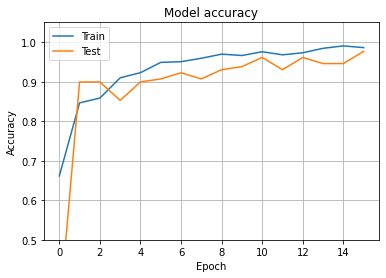

In [ ]:
plt.plot(result_list[study.best_trial.number].history["accuracy"])
plt.plot(result_list[study.best_trial.number].history["val_accuracy"])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Test"], loc="upper left")
plt.ylim(0.5, 1.05)
plt.grid()
plt.show()

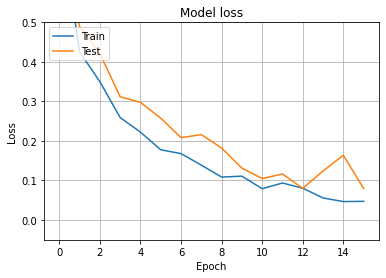

In [ ]:
plt.plot(result_list[study.best_trial.number].history["loss"])
plt.plot(result_list[study.best_trial.number].history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc="upper left")
plt.ylim(-0.05, 0.5)
plt.grid()
plt.show()

In [ ]:
model_list[study.best_trial.number].save("kurita.h5")